In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project/dandofi_cgan_excess.csv
/kaggle/input/project/dandofi_gan_excess.csv
/kaggle/input/project/dandofi_wcgan_excess.csv
/kaggle/input/project/dandofi_gan_primary.csv
/kaggle/input/project/specie_cgan_excess.csv
/kaggle/input/project/specie_wcgan_excess.csv
/kaggle/input/project/dandoww_cgan_excess.csv
/kaggle/input/project/dandofi_wgan_primary.csv
/kaggle/input/project/specie_gan_primary.csv
/kaggle/input/project/dandoww_gan_excess.csv
/kaggle/input/project/dandoww_gan_primary.csv
/kaggle/input/project/specie_cleaned_data.txt
/kaggle/input/project/dandoww_wgan_primary.csv
/kaggle/input/project/fi_dando_cleaned_data.txt
/kaggle/input/project/specie_gan_excess.csv
/kaggle/input/project/dandoww_wgan_excess.csv
/kaggle/input/project/dando_ww_cleaned_data.txt
/kaggle/input/project/dandoww_wcgan_primary.csv
/kaggle/input/project/specie_wcgan_primary.csv
/kaggle/input/project/specie_wgan_primary.csv
/kaggle/input/project/dandoww_cgan_primary.csv
/kaggle/input/project/specie_

In [2]:
# ! pip install sweetviz

# import sweetviz as sv
# import IPython

In [3]:
!pip install imbalanced-learn

In [4]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [5]:
import gc
import os
import sys

from keras import applications
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

# Loading the Data

In [7]:
df_specie = pd.read_csv('../input/project/specie_cleaned_data.txt')
df_specie.head()

,LifetimePolicyReference,PolicyReference,PriorPolicyRef,EclipsePolicyID,PriorEclipsePolicyID,GroupClass,PlacingBasis,SubClassCode,SubClass,StatsMinorClassCode,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,CG339K14A000,CG339K14A000,NaN,618908,-1,SPECIE,OM,23900,Cash in Transit,CA,...,0.000136,124.644537,0.0,0.006860,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
1,CD399J07A000,CD399J18A000,CD399J16A000,816149,-1,SPECIE,OM,23705,Precious Metal Refining/Recycling,SP,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
2,CF409G13A000,CF409G14A000,CF409G13A000,643250,588614,SPECIE,Binder,23810,Jewellers Block Facility,JB,...,0.132598,637.092249,0.0,1.976707,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
3,CN311E18A000,CN311E18A000,NaN,828190,-1,SPECIE,OM,24105,Corporate Collection,WA,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
4,CF807C14B000,CF807C14B000,NaN,610479,-1,SPECIE,Re,24000,Courier/Carrier,CA,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History


# Dropping features

In [8]:
# Dropping useless features
df_specie.drop(['LifetimePolicyReference', 'PolicyReference', 'PriorPolicyRef', 
               'EclipsePolicyID', 'PriorEclipsePolicyID', 'GroupClass',
               'StatsMinorClassDescription', 'InceptionDate', 'ExpiryDate', 
               'RenewalDate', 'SubClassCode'], axis=1, inplace=True)
df_specie.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,OM,Cash in Transit,CA,WORLDWIDE,2014.0,2.022403e+07,16045.628990,26218.991632,24685.582996,110.070722,...,0.000136,124.644537,0.0,0.006860,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
1,OM,Precious Metal Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,33210.000000,49134.600000,61500.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
2,Binder,Jewellers Block Facility,JB,WORLDWIDE,2014.0,5.615853e+06,18835.576815,30365.640383,26907.967039,37232.420949,...,0.132598,637.092249,0.0,1.976707,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
3,OM,Corporate Collection,WA,USA,2018.0,2.300000e+07,6297.524900,7881.000000,9688.499900,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History
4,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,13908.682300,23826.869500,21113.750000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,Upper Quantile,Upper Quantile,History


In [9]:
df_specie.drop(['PLR_band', 'PLR_band_ex_adj'], axis=1, inplace=True)
df_specie.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,Attachment,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,YOA_recent
0,OM,Cash in Transit,CA,WORLDWIDE,2014.0,2.022403e+07,16045.628990,26218.991632,24685.582996,110.070722,...,2528.004256,0.0,0.000136,124.644537,0.0,0.006860,0.0,0.0,0.0,History
1,OM,Precious Metal Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,33210.000000,49134.600000,61500.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History
2,Binder,Jewellers Block Facility,JB,WORLDWIDE,2014.0,5.615853e+06,18835.576815,30365.640383,26907.967039,37232.420949,...,0.000000,0.0,0.132598,637.092249,0.0,1.976707,0.0,0.0,0.0,History
3,OM,Corporate Collection,WA,USA,2018.0,2.300000e+07,6297.524900,7881.000000,9688.499900,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History
4,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,13908.682300,23826.869500,21113.750000,0.000000,...,10000.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History


In [10]:
df_specie.drop(['Exposure', 'LinePct'], axis=1, inplace=True)
df_specie.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,Attachment,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,YOA_recent
0,OM,Cash in Transit,CA,WORLDWIDE,2014.0,2.022403e+07,16045.628990,26218.991632,24685.582996,110.070722,...,2528.004256,0.0,0.000136,124.644537,0.0,0.006860,0.0,0.0,0.0,History
1,OM,Precious Metal Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,33210.000000,49134.600000,61500.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History
2,Binder,Jewellers Block Facility,JB,WORLDWIDE,2014.0,5.615853e+06,18835.576815,30365.640383,26907.967039,37232.420949,...,0.000000,0.0,0.132598,637.092249,0.0,1.976707,0.0,0.0,0.0,History
3,OM,Corporate Collection,WA,USA,2018.0,2.300000e+07,6297.524900,7881.000000,9688.499900,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History
4,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,13908.682300,23826.869500,21113.750000,0.000000,...,10000.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,History


In [11]:
# Since claims won’t be mature enough
df_specie.drop(df_specie[df_specie.YOA == 2020.0].index, axis=0, inplace=True)
df_specie.drop(df_specie[df_specie.YOA == 2021.0].index, axis=0, inplace=True)
df_specie.reset_index(drop=True, inplace=True)

In [12]:
df_specie.drop(df_specie[df_specie.PlacingBasis == 'Binder'].index, axis=0, inplace=True)
df_specie.drop(df_specie[df_specie.PlacingBasis == 'Other'].index, axis=0, inplace=True)
df_specie.reset_index(drop=True, inplace=True)

In [13]:
df_specie.replace(' ', '_', regex=True, inplace=True)
df_specie.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,Attachment,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,YOA_recent
0,OM,Cash_in_Transit,CA,WORLDWIDE,2014.0,2.022403e+07,16045.62899,26218.991632,24685.582996,110.070722,...,2.528004e+03,0.0,0.000136,124.644537,0.0,0.00686,0.0,0.0,0.0,History
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,33210.00000,49134.600000,61500.000000,0.000000,...,0.000000e+00,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,History
2,OM,Corporate_Collection,WA,USA,2018.0,2.300000e+07,6297.52490,7881.000000,9688.499900,0.000000,...,0.000000e+00,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,History
3,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,13908.68230,23826.869500,21113.750000,0.000000,...,1.000000e+04,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,History
4,OM,Gallery/Dealers,WA,USA_&_EUROPE,2015.0,1.725000e+08,12249.91500,10327.423900,12249.915000,0.000000,...,1.900000e+09,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,History


# Classification

In [14]:
df_specie.drop(['Inc', 'Inc_Cat', 'ClaimFrequency', 'CLR_Cat', 
                'CLR_ExCat', 'Full_Inc_ExCat', 'Inc_ExCat', 
               'Inc_Cat', 'ILR_Cat', 'ILR_ExCat', 'GNWP'], axis=1, inplace=True)
df_specie.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GGTP,GGWP,LeaderStatus,LeaderLinePct,...,PricingStrength,PricingStrength2,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,YOA_recent
0,OM,Cash_in_Transit,CA,WORLDWIDE,2014.0,2.022403e+07,26218.991632,24685.582996,FOLLOW,50.000000,...,0.941515,-0.058485,35.000000,2014,Primary,2.528004e+03,0.0,0.0,0.0,History
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,49134.600000,61500.000000,FOLLOW,15.000000,...,1.251664,0.251664,46.000000,2018,Primary,0.000000e+00,0.0,0.0,0.0,History
2,OM,Corporate_Collection,WA,USA,2018.0,2.300000e+07,7881.000000,9688.499900,FOLLOW,50.000000,...,1.229349,0.229349,35.000000,2018,Primary,0.000000e+00,0.0,0.0,0.0,History
3,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,23826.869500,21113.750000,FOLLOW,20.000000,...,0.886132,-0.113868,34.125002,2014,Excess,1.000000e+04,0.0,0.0,0.0,History
4,OM,Gallery/Dealers,WA,USA_&_EUROPE,2015.0,1.725000e+08,10327.423900,12249.915000,FOLLOW,14.492754,...,1.186154,0.186154,0.000000,2015,Excess,1.900000e+09,0.0,0.0,0.0,History


In [15]:
# Making 100% share basis
df_specie.GGTP = df_specie.GGTP / df_specie.EffectiveLine
df_specie.GGWP = df_specie.GGWP / df_specie.EffectiveLine
df_specie.GrossGrossModelPrice = df_specie.GrossGrossModelPrice / df_specie.EffectiveLine
df_specie.GrossNetModelPrice = df_specie.GrossNetModelPrice / df_specie.EffectiveLine
df_specie.GrossGrossTechnicalPrice = df_specie.GrossGrossTechnicalPrice / df_specie.EffectiveLine
df_specie.GrossNetTechnicalPrice = df_specie.GrossNetTechnicalPrice / df_specie.EffectiveLine

In [16]:
# Rename the columns
df_specie = df_specie.rename(columns={'GGTP': 'Full_GGTP'})
df_specie = df_specie.rename(columns={'GGWP': 'Full_GGWP'})
df_specie = df_specie.rename(columns={'GrossGrossModelPrice': 'Full_GrossGrossModelPrice'})
df_specie = df_specie.rename(columns={'GrossNetModelPrice': 'Full_GrossNetModelPrice'})
df_specie = df_specie.rename(columns={'GrossGrossTechnicalPrice': 'Full_GrossGrossTechnicalPrice'})
df_specie = df_specie.rename(columns={'GrossNetTechnicalPrice': 'Full_GrossNetTechnicalPrice'})

In [17]:
df_specie.drop('EffectiveLine', axis=1, inplace=True)

In [18]:
X = df_specie.copy()
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,...,PricingStrength,PricingStrength2,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,YOA_recent
0,OM,Cash_in_Transit,CA,WORLDWIDE,2014.0,2.022403e+07,655471.513446,617136.489207,FOLLOW,50.000000,...,0.941515,-0.058485,35.000000,2014,Primary,2.528004e+03,0.0,0.0,0.0,History
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,2018.0,1.250000e+08,327564.000000,410000.000000,FOLLOW,15.000000,...,1.251664,0.251664,46.000000,2018,Primary,0.000000e+00,0.0,0.0,0.0,History
2,OM,Corporate_Collection,WA,USA,2018.0,2.300000e+07,15762.000000,19376.999800,FOLLOW,50.000000,...,1.229349,0.229349,35.000000,2018,Primary,0.000000e+00,0.0,0.0,0.0,History
3,Re,Courier/Carrier,CA,VENEZUELA,2014.0,5.000000e+05,268018.779528,237500.000000,FOLLOW,20.000000,...,0.886132,-0.113868,34.125002,2014,Excess,1.000000e+04,0.0,0.0,0.0,History
4,OM,Gallery/Dealers,WA,USA_&_EUROPE,2015.0,1.725000e+08,145427.998704,172500.000000,FOLLOW,14.492754,...,1.186154,0.186154,0.000000,2015,Excess,1.900000e+09,0.0,0.0,0.0,History


In [19]:
df_specie.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1, inplace=True)
X = X.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1).copy()

In [20]:
X['Class'] = X['ClaimCount'] / X['ClaimCount']
X['Class'] = X['Class'].fillna(0)
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
0,OM,Cash_in_Transit,CA,WORLDWIDE,2.022403e+07,655471.513446,617136.489207,FOLLOW,50.000000,WILLIS,...,401138.719065,0.941515,-0.058485,35.000000,Primary,2.528004e+03,0.0,0.0,0.0,1.0
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,1.250000e+08,327564.000000,410000.000000,FOLLOW,15.000000,WILLIS,...,221400.000000,1.251664,0.251664,46.000000,Primary,0.000000e+00,0.0,0.0,0.0,0.0
2,OM,Corporate_Collection,WA,USA,2.300000e+07,15762.000000,19376.999800,FOLLOW,50.000000,ARTHUR_J._GALLAGHER_&_CO.,...,12595.049800,1.229349,0.229349,35.000000,Primary,0.000000e+00,0.0,0.0,0.0,0.0
3,Re,Courier/Carrier,CA,VENEZUELA,5.000000e+05,268018.779528,237500.000000,FOLLOW,20.000000,BUTCHER_ROBINSON_&_STAPLES,...,156453.119235,0.886132,-0.113868,34.125002,Excess,1.000000e+04,0.0,0.0,0.0,0.0
4,OM,Gallery/Dealers,WA,USA_&_EUROPE,1.725000e+08,145427.998704,172500.000000,FOLLOW,14.492754,JLT,...,172500.000000,1.186154,0.186154,0.000000,Excess,1.900000e+09,0.0,0.0,0.0,0.0


In [21]:
df_specie.drop('ClaimCount', axis=1, inplace=True)
X.drop('ClaimCount', axis=1, inplace=True)

In [22]:
# Divide into primary and excess business
X_p = X.copy()
X_p.drop(X_p[X_p.Excess == 'Excess'].index, axis=0, inplace=True)
X_p.drop(['Excess', 'XS_100Pct_USD'], axis=1, inplace=True)
X_p.reset_index(drop=True, inplace=True)
X_p.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
0,OM,Cash_in_Transit,CA,WORLDWIDE,2.022403e+07,655471.513446,617136.489207,FOLLOW,50.00,WILLIS,...,426056.369718,401138.719065,0.941515,-0.058485,35.000000,2528.004256,0.0,0.0,0.0,1.0
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,1.250000e+08,327564.000000,410000.000000,FOLLOW,15.00,WILLIS,...,176884.533333,221400.000000,1.251664,0.251664,46.000000,0.000000,0.0,0.0,0.0,0.0
2,OM,Corporate_Collection,WA,USA,2.300000e+07,15762.000000,19376.999800,FOLLOW,50.00,ARTHUR_J._GALLAGHER_&_CO.,...,10245.300000,12595.049800,1.229349,0.229349,35.000000,0.000000,0.0,0.0,0.0,0.0
3,OM,Corporate_Collection,WA,WORLDWIDE,1.400033e+07,25945.339893,24165.389820,LEAD,33.34,MARSH,...,14918.576438,13895.099922,0.931396,-0.068604,42.499997,1500.000000,0.0,0.0,0.0,1.0
4,Re,ART_EXHIBITIONS_&_RELATED_TRANSITS,WA,SOUTH_KOREA,4.399989e+08,306686.227826,307999.212896,FOLLOW,8.66,BESSO,...,219280.428484,220219.431460,1.004281,0.004281,28.500002,0.000000,0.0,0.0,0.0,0.0


In [23]:
# Divide into primary and excess business
X_e = X.copy()
X_e.drop(X_e[X_e.Excess == 'Primary'].index, axis=0, inplace=True)
X_e.drop('Excess', axis=1, inplace=True)
X_e.reset_index(drop=True, inplace=True)
X_e.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
0,Re,Courier/Carrier,CA,VENEZUELA,5.000000e+05,268018.779528,237500.000000,FOLLOW,20.000000,BUTCHER_ROBINSON_&_STAPLES,...,176557.367829,156453.119235,0.886132,-0.113868,34.125002,1.000000e+04,0.0,0.0,0.0,0.0
1,OM,Gallery/Dealers,WA,USA_&_EUROPE,1.725000e+08,145427.998704,172500.000000,FOLLOW,14.492754,JLT,...,145427.943786,172500.000000,1.186154,0.186154,0.000000,1.900000e+09,0.0,0.0,0.0,0.0
2,OM,Vault,SP,USA,7.500000e+08,296041.998387,312500.000000,FOLLOW,13.333333,JLT,...,296042.037763,312500.000000,1.055593,0.055593,0.000000,1.750000e+09,0.0,0.0,0.0,0.0
3,OM,Vault,SP,CANADA,1.835522e+08,89516.206073,109030.007725,FOLLOW,15.000000,ARTHUR_J._GALLAGHER_&_CO.,...,50576.533333,61601.953386,1.217992,0.217992,43.500001,1.835522e+08,0.0,0.0,0.0,0.0
4,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,1.000000e+09,248277.995887,302399.990652,FOLLOW,8.000000,HOWDEN,...,201104.879417,244943.989531,1.217989,0.217989,19.000001,5.000000e+08,0.0,0.0,0.0,0.0


In [24]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X.columns[X.dtypes != 'object'] if X[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_scaled = X.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_scaled[col] = scaled[col]
    
X_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
0,OM,Cash_in_Transit,CA,WORLDWIDE,0.010400,0.008858,0.010111,FOLLOW,0.007459,WILLIS,...,0.012520,0.167160,0.167160,0.539752,Primary,5.626937e-07,0.0,0.0,0.0,1.0
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,0.064354,0.004425,0.006716,FOLLOW,0.002152,WILLIS,...,0.006907,0.258934,0.258934,0.708510,Primary,0.000000e+00,0.0,0.0,0.0,0.0
2,OM,Corporate_Collection,WA,USA,0.011830,0.000209,0.000312,FOLLOW,0.007459,ARTHUR_J._GALLAGHER_&_CO.,...,0.000387,0.252331,0.252331,0.539752,Primary,0.000000e+00,0.0,0.0,0.0,0.0
3,Re,Courier/Carrier,CA,VENEZUELA,0.000244,0.003620,0.003888,FOLLOW,0.002910,BUTCHER_ROBINSON_&_STAPLES,...,0.004879,0.150771,0.150771,0.526328,Excess,2.225842e-06,0.0,0.0,0.0,0.0
4,OM,Gallery/Dealers,WA,USA_&_EUROPE,0.088814,0.001962,0.002822,FOLLOW,0.002075,JLT,...,0.005380,0.239550,0.239550,0.002796,Excess,4.229099e-01,0.0,0.0,0.0,0.0


In [25]:
# Divide into primary and excess business
X_p_scaled = X_scaled.copy()
X_p_scaled.drop(X_p_scaled[X_p_scaled.Excess == 'Excess'].index, axis=0, inplace=True)
X_p_scaled.drop('Excess', axis=1, inplace=True)
X_p_scaled.reset_index(drop=True, inplace=True)
# X_p_scaled.head()

X_e_scaled = X_scaled.copy()
X_e_scaled.drop(X_e_scaled[X_e_scaled.Excess == 'Primary'].index, axis=0, inplace=True)
X_e_scaled.drop('Excess', axis=1, inplace=True)
X_e_scaled.reset_index(drop=True, inplace=True)
# X_e_scaled.head()

### One-hot encoding

In [26]:
X_encoded = pd.get_dummies(X_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 
                                         'Excess'])
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName'])

In [27]:
y = X_scaled['Class'].copy()
y_p = X_p_scaled['Class'].copy()
y_e = X_e_scaled['Class'].copy()

In [28]:
X_encoded.drop('Class', axis=1, inplace=True)
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

In [29]:
len(X_encoded_p.columns)

182

### EDA

In [30]:
X.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,1.587000e+03,1.587000e+03,1.587000e+03,1587.000000,1.587000e+03,1.587000e+03,1587.000000,1587.000000,1.587000e+03,1.587000e+03,...,1.587000e+03,1.587000e+03,1587.000000,1587.000000,1587.000000,1.587000e+03,1587.000000,1587.000000,1587.000000,1587.000000
mean,1.696279e+08,3.240496e+05,3.215313e+05,35.830465,1.405984e+08,7.448795e+04,0.727987,-0.003101,6.255765e+04,4.763614e+04,...,2.414819e+05,2.394984e+05,1.102142,0.102142,26.461762,1.406729e+08,0.204708,0.233767,0.155614,0.188406
std,2.687490e+08,1.986610e+06,1.673812e+06,209.920090,4.154558e+08,9.272702e+05,0.145250,0.059778,5.228865e+05,4.055842e+05,...,1.132086e+06,9.684797e+05,0.204180,0.204180,13.380286,4.154394e+08,1.290742,1.703518,0.987837,0.391159
min,2.700000e+04,2.929910e+02,3.467705e+02,0.809323,0.000000e+00,0.000000e+00,0.205000,-0.750000,0.000000e+00,0.000000e+00,...,1.684500e+02,1.994005e+02,0.376606,-0.623394,-0.182249,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+07,4.262598e+04,4.651270e+04,14.500000,0.000000e+00,0.000000e+00,0.650000,0.000000,0.000000e+00,0.000000e+00,...,3.041071e+04,3.261562e+04,1.004283,0.004283,19.999997,3.089000e+02,0.000000,0.000000,0.000000,0.000000
50%,5.000000e+07,1.061670e+05,1.155050e+05,21.581957,0.000000e+00,0.000000e+00,0.750000,0.000000,0.000000e+00,0.000000e+00,...,7.757414e+04,8.529852e+04,1.055593,0.055593,29.000000,1.000000e+04,0.000000,0.000000,0.000000,0.000000
75%,2.000000e+08,2.549869e+05,2.843399e+05,30.000000,6.178000e+06,1.000000e+04,0.750000,0.000000,0.000000e+00,0.000000e+00,...,1.904898e+05,2.050610e+05,1.186119,0.186119,35.000000,6.178000e+06,0.000000,0.000000,0.000000,0.000000
max,1.941993e+09,7.396791e+07,6.100000e+07,6595.358774,4.492682e+09,2.500000e+07,2.000000,0.850000,1.489286e+07,1.025247e+07,...,3.883315e+07,3.202500e+07,3.756066,2.756066,65.000000,4.492682e+09,35.393357,55.075791,27.251501,1.000000


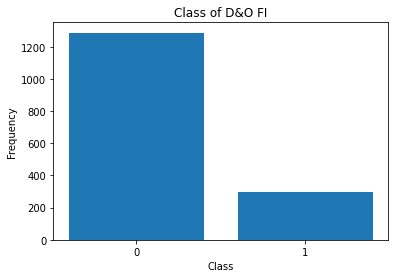

In [31]:
plt.bar(dict(Counter(y)).keys(), dict(Counter(y)).values())
plt.xticks(np.arange(2))
plt.title('Class of D&O FI')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [32]:
# report = sv.analyze(X_scaled, 'Class')
# report.show_html(filepath='Specie.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

In [33]:
# X[["Excess", "Class"]].groupby(['Excess'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [34]:
# X[["Territory", "Class"]].groupby(['Territory'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [35]:
# X[["BrokerUltimateName", "Class"]].groupby(['BrokerUltimateName'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [36]:
X_p_scaled[X_p_scaled.SubClass == 'Pawn_Broker']

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
234,OM,Pawn_Broker,SP,WORLDWIDE,0.009530,0.002297,0.002617,FOLLOW,0.004931,MARSH,...,0.004379,0.004990,0.166745,0.166745,0.002796,2.750250e-06,0.000000,0.000000,0.000000,0.0
310,OM,Pawn_Broker,SP,USA,0.001016,0.000376,0.000850,FOLLOW,0.007459,JLT,...,0.000412,0.000931,0.438471,0.438471,0.654814,1.112921e-06,0.000000,0.000000,0.000000,0.0
378,Re,Pawn_Broker,SP,MALAYSIA,0.000707,0.000861,0.001391,FOLLOW,0.002607,ARTHUR_J._GALLAGHER_&_CO.,...,0.000882,0.001425,0.282657,0.282657,0.711578,3.895869e-07,0.000000,0.000000,0.000000,1.0
418,OM,Pawn_Broker,SP,WORLDWIDE,0.010285,0.005234,0.005755,FOLLOW,0.004931,MARSH,...,0.006980,0.007675,0.156964,0.156964,0.463044,3.338763e-06,0.000000,0.000000,0.000000,1.0
499,OM,Pawn_Broker,SP,WORLDWIDE,0.009530,0.002186,0.002400,FOLLOW,0.004931,MARSH,...,0.004052,0.004450,0.156615,0.156615,0.044985,2.750250e-06,0.031189,0.018157,0.031191,1.0
731,OM,Pawn_Broker,SP,WORLDWIDE,0.005136,0.000827,0.001030,FOLLOW,0.004047,MARSH,...,0.001135,0.001414,0.192753,0.192753,0.432361,0.000000e+00,0.000000,0.000000,0.000000,0.0
757,OM,Pawn_Broker,SP,WORLDWIDE,0.010285,0.006023,0.006609,FOLLOW,0.004931,MARSH,...,0.008032,0.008814,0.156370,0.156370,0.463044,3.338763e-06,0.000000,0.000000,0.000000,1.0
805,OM,Pawn_Broker,SP,USA,0.001016,0.000507,0.000748,FOLLOW,0.007459,LLOYD_&_PARTNERS_LIMITED,...,0.000555,0.000820,0.248971,0.248971,0.654814,1.112921e-06,0.000000,0.000000,0.000000,0.0
962,OM,Pawn_Broker,SP,UNITED_KINGDOM,0.007621,0.000924,0.001151,FOLLOW,0.003289,ARTHUR_J._GALLAGHER_&_CO.,...,0.001268,0.001580,0.192752,0.192752,0.432361,0.000000e+00,0.000000,0.000000,0.000000,0.0
1096,OM,Pawn_Broker,SP,WORLDWIDE,0.009530,0.000414,0.000454,FOLLOW,0.004931,MARSH,...,0.000792,0.000869,0.156615,0.156615,0.002796,2.750250e-06,0.031189,0.018157,0.031191,1.0


#### Primary Business

In [37]:
X_p.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,Full_GrossGrossTechnicalPrice,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,1.132000e+03,1.132000e+03,1.132000e+03,1132.000000,1.132000e+03,1132.000000,1132.000000,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1132.000000,1132.000000,1132.000000,1.132000e+03,1132.000000,1132.000000,1132.000000,1132.000000
mean,1.058467e+08,3.601900e+05,3.460804e+05,41.891829,9.785964e+04,0.740037,-0.001987,5.114216e+04,3.461819e+04,3.607414e+05,2.569852e+05,2.463436e+05,1.083415,0.083415,29.757163,9.785964e+04,0.159479,0.171087,0.122477,0.228799
std,2.138194e+08,2.322533e+06,1.941495e+06,247.955771,1.081130e+06,0.158925,0.063718,4.952588e+05,3.297505e+05,2.322556e+06,1.295696e+06,1.085892e+06,0.177251,0.177251,12.051655,1.081130e+06,0.682051,0.722457,0.524201,0.420245
min,2.700000e+04,2.929910e+02,3.467705e+02,1.450000,0.000000e+00,0.405000,-0.250000,0.000000e+00,0.000000e+00,2.930000e+02,1.684500e+02,1.994005e+02,0.376606,-0.623394,-0.182249,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,5.615853e+06,4.228970e+04,4.434548e+04,17.500000,0.000000e+00,0.650000,0.000000,0.000000e+00,0.000000e+00,4.249825e+04,2.899752e+04,3.018545e+04,1.004275,0.004275,25.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,2.273171e+07,1.066965e+05,1.145260e+05,25.000000,2.500000e+03,0.750000,0.000000,0.000000e+00,0.000000e+00,1.066965e+05,7.400974e+04,7.852237e+04,1.028022,0.028022,30.000000,2.500000e+03,0.000000,0.000000,0.000000,0.000000
75%,9.000000e+07,2.691864e+05,3.000000e+05,33.330000,1.264002e+04,0.750000,0.000000,0.000000e+00,0.000000e+00,2.705388e+05,1.889189e+05,2.017007e+05,1.183531,0.183531,37.500002,1.264002e+04,0.000000,0.000000,0.000000,0.000000
max,1.941993e+09,7.396791e+07,6.100000e+07,6595.358774,2.500000e+07,2.000000,0.850000,1.489286e+07,9.680357e+06,7.396791e+07,3.883315e+07,3.202500e+07,1.901237,0.901237,65.000000,2.500000e+07,17.792578,19.022499,13.700004,1.000000


In [38]:
X_p_scaled.skew()

Limit_100Pct_USD                  3.401255
Full_GGTP                        28.546551
Full_GGWP                        27.614767
LeaderLinePct                    20.856761
XS_100Pct_USD                     0.000000
Ded_100Pct_USD                   21.783595
PLR                               4.197643
RARC                              5.407824
Full_GrossGrossModelPrice        25.152627
Full_GrossNetModelPrice          24.062163
Full_GrossGrossTechnicalPrice    28.544996
Full_GrossNetTechnicalPrice      24.189381
Full_GNWP                        23.328620
PricingStrength                   0.433832
PricingStrength2                  0.433832
BrokerFeePct                     -0.488756
Attachment                       21.783595
ModelToActualRto                 16.420366
ModelToTechnicalRto              16.775910
PLR_ex_adj                       16.501045
Class                             1.292967
dtype: float64

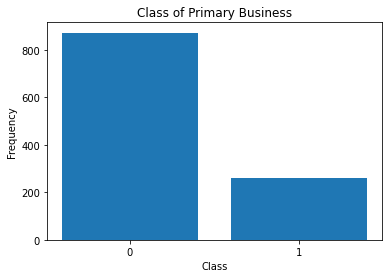

In [39]:
plt.bar(dict(Counter(y_p)).keys(), dict(Counter(y_p)).values())
plt.xticks(np.arange(2))
plt.title('Class of Primary Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [40]:
# report_p = sv.analyze(X_p_scaled, 'Class')
# report_p.show_html(filepath='Specie Primary.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


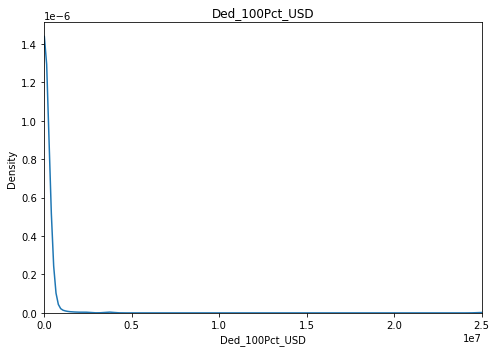

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


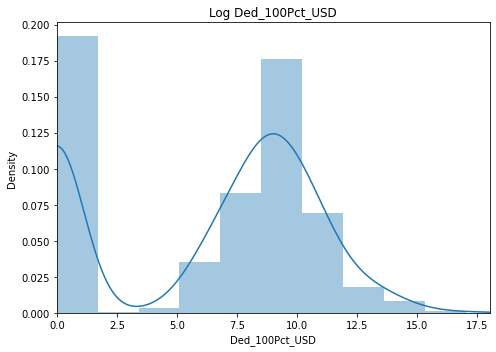

In [41]:
# Looking at the skewness of Full_GrossGrossModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.Ded_100Pct_USD, hist=False)
plt.title(f"Ded_100Pct_USD")
plt.xlim(0, X_p.Ded_100Pct_USD.max()+1)
plt.tight_layout()
plt.show()

# Log-transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.Ded_100Pct_USD))
plt.title(f"Log Ded_100Pct_USD")
plt.xlim(0, np.log1p(X_p.Ded_100Pct_USD).max()+1)
plt.tight_layout()
plt.show()

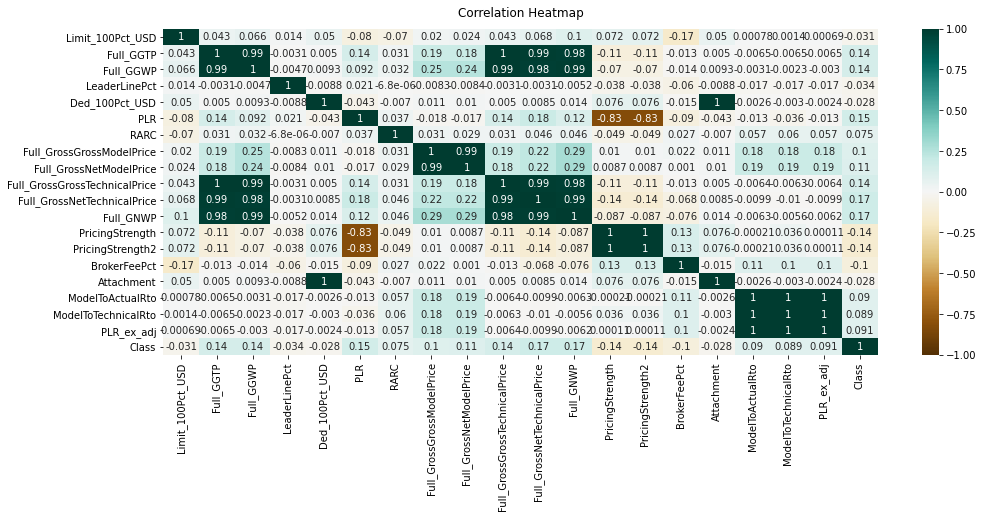

In [42]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_p.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Excess Business

In [43]:
X_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,4.550000e+02,4.550000e+02,4.550000e+02,455.000000,4.550000e+02,4.550000e+02,455.000000,455.000000,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,455.000000,455.000000,455.000000,4.550000e+02,455.000000,455.000000,455.000000,455.000000
mean,3.283097e+08,2.341354e+05,2.604550e+05,20.750325,4.903949e+08,1.634123e+04,0.698008,-0.005873,9.095838e+04,8.002364e+04,...,2.029109e+05,2.224680e+05,1.148732,0.148732,18.263096,4.904112e+08,0.317234,0.389709,0.238053,0.087912
std,3.210003e+08,5.812569e+05,6.258680e+05,21.409808,6.565483e+08,2.952380e+05,0.097566,0.048566,5.856228e+05,5.498215e+05,...,5.411333e+05,5.819926e+05,0.253613,0.253613,13.006123,6.565533e+08,2.154847,2.967037,1.647675,0.283479
min,2.977963e+05,4.753863e+02,5.412497e+02,0.809323,5.000000e+03,0.000000e+00,0.205000,-0.750000,0.000000e+00,0.000000e+00,...,4.039310e+02,4.600733e+02,0.880764,-0.119236,0.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000
25%,8.004612e+07,4.374687e+04,5.000000e+04,10.000000,2.807927e+07,0.000000e+00,0.650000,0.000000,0.000000e+00,0.000000e+00,...,3.506903e+04,3.987167e+04,1.025725,0.025725,5.000000,2.807927e+07,0.000000,0.000000,0.000000,0.000000
50%,2.000000e+08,1.053473e+05,1.168750e+05,15.060000,2.000000e+08,0.000000e+00,0.750000,0.000000,0.000000e+00,0.000000e+00,...,8.815643e+04,9.580507e+04,1.068947,0.068947,20.000000,2.000000e+08,0.000000,0.000000,0.000000,0.000000
75%,5.000000e+08,2.253170e+05,2.521539e+05,25.000000,7.300609e+08,0.000000e+00,0.750000,0.000000,0.000000e+00,0.000000e+00,...,1.918413e+05,2.095000e+05,1.197426,0.197426,30.000000,7.300609e+08,0.000000,0.000000,0.000000,0.000000
max,1.800000e+09,7.905195e+06,8.700000e+06,323.275862,4.492682e+09,6.178000e+06,0.900000,0.200000,1.079207e+07,1.025247e+07,...,7.509935e+06,8.265000e+06,3.756066,2.756066,53.150001,4.492682e+09,35.393357,55.075791,27.251501,1.000000


In [44]:
X_e.skew()

Limit_100Pct_USD                  1.671103
Full_GGTP                         8.650061
Full_GGWP                         8.756203
LeaderLinePct                     7.130904
XS_100Pct_USD                     2.523946
Ded_100Pct_USD                   20.266646
PLR                              -1.217316
RARC                             -7.981658
Full_GrossGrossModelPrice        14.627525
Full_GrossNetModelPrice          15.043913
Full_GrossGrossTechnicalPrice     8.618576
Full_GrossNetTechnicalPrice       9.041120
Full_GNWP                         9.223652
PricingStrength                   5.234290
PricingStrength2                  5.234290
BrokerFeePct                     -0.009590
Attachment                        2.523835
ModelToActualRto                 14.100094
ModelToTechnicalRto              16.030411
PLR_ex_adj                       14.349236
Class                             2.920200
dtype: float64

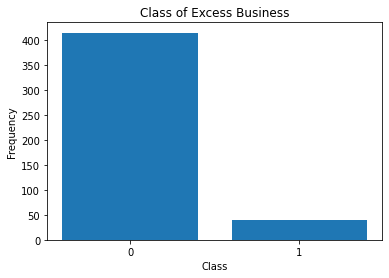

In [45]:
plt.bar(dict(Counter(y_e)).keys(), dict(Counter(y_e)).values())
plt.xticks(np.arange(2))
plt.title('Class of Excess Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [46]:
# report_e = sv.analyze(X_e_scaled, 'Class')
# report_e.show_html(filepath='Specie Excess.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

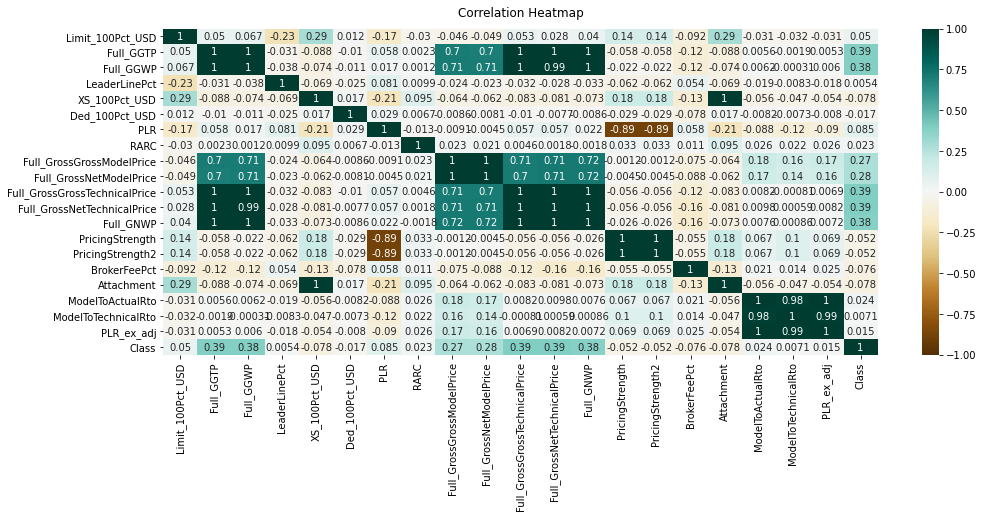

In [47]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_e.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Changing the data into log-transform

In [48]:
# Primary business
X_p['Full_GGTP'] = np.log1p(X_p.Full_GGTP)
X_p['Full_GGWP'] = np.log1p(X_p.Full_GGWP)
X_p['LeaderLinePct'] = np.log1p(X_p.LeaderLinePct)
X_p['Ded_100Pct_USD'] = np.log1p(X_p.Ded_100Pct_USD)
X_p['Full_GrossGrossModelPrice'] = np.log1p(X_p.Full_GrossGrossModelPrice)
X_p['Full_GrossNetModelPrice'] = np.log1p(X_p.Full_GrossNetModelPrice)
X_p['Full_GrossGrossTechnicalPrice'] = np.log1p(X_p.Full_GrossGrossTechnicalPrice)
X_p['Full_GrossNetTechnicalPrice'] = np.log1p(X_p.Full_GrossNetTechnicalPrice)
X_p['Full_GNWP'] = np.log1p(X_p.Full_GNWP)
X_p['Attachment'] = np.log1p(X_p.Attachment)
X_p['ModelToActualRto'] = np.log1p(X_p.ModelToActualRto)
X_p['ModelToTechnicalRto'] = np.log1p(X_p.ModelToTechnicalRto)
X_p['PLR_ex_adj'] = np.log1p(X_p.PLR_ex_adj)

# Excess business
X_e['Ded_100Pct_USD'] = np.log1p(X_e.Ded_100Pct_USD)
X_e['Full_GrossGrossModelPrice'] = np.log1p(X_e.Full_GrossGrossModelPrice)
X_e['Full_GrossNetModelPrice'] = np.log1p(X_e.Full_GrossNetModelPrice)
X_e['ModelToActualRto'] = np.log1p(X_e.ModelToActualRto)
X_e['ModelToTechnicalRto'] = np.log1p(X_e.ModelToTechnicalRto)
X_e['PLR_ex_adj'] = np.log1p(X_e.PLR_ex_adj)

In [49]:
correlated_features = set()
correlation_matrix = X_p.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_p.drop(labels=correlated_features, axis=1, inplace=True)
X_p.head()

{'ModelToActualRto', 'PLR_ex_adj', 'PricingStrength2', 'Attachment', 'Full_GrossNetModelPrice', 'Full_GrossGrossTechnicalPrice', 'Full_GGWP', 'ModelToTechnicalRto', 'Full_GNWP', 'Full_GrossNetTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,Class
0,OM,Cash_in_Transit,CA,WORLDWIDE,2.022403e+07,13.393112,FOLLOW,3.931826,WILLIS,7.835581,0.80,0.0,0.0,0.941515,35.000000,1.0
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,1.250000e+08,12.699442,FOLLOW,2.772589,WILLIS,0.000000,0.65,0.0,0.0,1.251664,46.000000,0.0
2,OM,Corporate_Collection,WA,USA,2.300000e+07,9.665421,FOLLOW,3.931826,ARTHUR_J._GALLAGHER_&_CO.,0.000000,0.65,0.0,0.0,1.229349,35.000000,0.0
3,OM,Corporate_Collection,WA,WORLDWIDE,1.400033e+07,10.163786,LEAD,3.536311,MARSH,7.313887,0.85,0.0,0.0,0.931396,42.499997,1.0
4,Re,ART_EXHIBITIONS_&_RELATED_TRANSITS,WA,SOUTH_KOREA,4.399989e+08,12.633584,FOLLOW,2.267994,BESSO,0.000000,0.75,0.0,0.0,1.004281,28.500002,0.0


In [50]:
correlated_features = set()
correlation_matrix = X_e.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_e.drop(labels=correlated_features, axis=1, inplace=True)
X_e.head()

{'PLR_ex_adj', 'PricingStrength2', 'Attachment', 'Full_GrossNetModelPrice', 'Full_GrossGrossTechnicalPrice', 'Full_GGWP', 'ModelToTechnicalRto', 'Full_GNWP', 'Full_GrossNetTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,Class
0,Re,Courier/Carrier,CA,VENEZUELA,5.000000e+05,268018.779528,FOLLOW,20.000000,BUTCHER_ROBINSON_&_STAPLES,1.000000e+04,0.0,0.85,0.00,0.0,0.886132,34.125002,0.0,0.0
1,OM,Gallery/Dealers,WA,USA_&_EUROPE,1.725000e+08,145427.998704,FOLLOW,14.492754,JLT,1.900000e+09,0.0,0.65,0.00,0.0,1.186154,0.000000,0.0,0.0
2,OM,Vault,SP,USA,7.500000e+08,296041.998387,FOLLOW,13.333333,JLT,1.750000e+09,0.0,0.75,0.00,0.0,1.055593,0.000000,0.0,0.0
3,OM,Vault,SP,CANADA,1.835522e+08,89516.206073,FOLLOW,15.000000,ARTHUR_J._GALLAGHER_&_CO.,1.835522e+08,0.0,0.65,-0.06,0.0,1.217992,43.500001,0.0,0.0
4,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,1.000000e+09,248277.995887,FOLLOW,8.000000,HOWDEN,5.000000e+08,0.0,0.65,0.00,0.0,1.217989,19.000001,0.0,0.0


In [51]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_p.columns[X_p.dtypes != 'object'] if X_p[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_p[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_p_scaled = X_p.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_p_scaled[col] = scaled[col]
    
X_p_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,Class
0,OM,Cash_in_Transit,CA,WORLDWIDE,0.010400,0.619959,FOLLOW,0.384359,WILLIS,0.459986,0.247649,0.0,0.0,0.370522,0.539752,1.0
1,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,0.064354,0.564178,FOLLOW,0.237586,WILLIS,0.000000,0.153605,0.0,0.0,0.573947,0.708510,0.0
2,OM,Corporate_Collection,WA,USA,0.011830,0.320200,FOLLOW,0.384359,ARTHUR_J._GALLAGHER_&_CO.,0.000000,0.153605,0.0,0.0,0.559311,0.539752,0.0
3,OM,Corporate_Collection,WA,WORLDWIDE,0.007195,0.360275,LEAD,0.334282,MARSH,0.429360,0.278997,0.0,0.0,0.363885,0.654814,1.0
4,Re,ART_EXHIBITIONS_&_RELATED_TRANSITS,WA,SOUTH_KOREA,0.226560,0.558882,FOLLOW,0.173699,BESSO,0.000000,0.216301,0.0,0.0,0.411690,0.440032,0.0


In [52]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_e.columns[X_e.dtypes != 'object'] if X_e[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_e[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_e_scaled = X_e.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_e_scaled[col] = scaled[col]
    
X_e_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,Class
0,Re,Courier/Carrier,CA,VENEZUELA,0.000112,0.033846,FOLLOW,0.059512,BUTCHER_ROBINSON_&_STAPLES,0.000001,0.0,0.85,0.00,0.0,0.001867,0.642051,0.0,0.0
1,OM,Gallery/Dealers,WA,USA_&_EUROPE,0.095684,0.018337,FOLLOW,0.042434,JLT,0.422909,0.0,0.65,0.00,0.0,0.106211,0.000000,0.0,0.0
2,OM,Vault,SP,USA,0.416570,0.037391,FOLLOW,0.038838,JLT,0.389522,0.0,0.75,0.00,0.0,0.060804,0.000000,0.0,0.0
3,OM,Vault,SP,CANADA,0.101825,0.011264,FOLLOW,0.044007,ARTHUR_J._GALLAGHER_&_CO.,0.040855,0.0,0.65,-0.06,0.0,0.117284,0.818438,0.0,0.0
4,OM,Precious_Metal_Refining/Recycling,SP,WORLDWIDE,0.555482,0.031349,FOLLOW,0.022299,HOWDEN,0.111291,0.0,0.65,0.00,0.0,0.117283,0.357479,0.0,0.0


In [53]:
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName'])
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

### XGBoost

#### Primary business

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [55]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [2, 3, 4]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [56]:
# print(optimal_params.best_params_)

In [57]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.41894
[1]	validation_0-aucpr:0.47685
[2]	validation_0-aucpr:0.42923
[3]	validation_0-aucpr:0.47182
[4]	validation_0-aucpr:0.49304
[5]	validation_0-aucpr:0.47370
[6]	validation_0-aucpr:0.48404


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-aucpr:0.49767
[8]	validation_0-aucpr:0.50563
[9]	validation_0-aucpr:0.49031
[10]	validation_0-aucpr:0.50009
[11]	validation_0-aucpr:0.49415
[12]	validation_0-aucpr:0.50092
[13]	validation_0-aucpr:0.48614
[14]	validation_0-aucpr:0.49244
[15]	validation_0-aucpr:0.50048
[16]	validation_0-aucpr:0.50323
[17]	validation_0-aucpr:0.50053
[18]	validation_0-aucpr:0.50925
[19]	validation_0-aucpr:0.50245
[20]	validation_0-aucpr:0.49825
[21]	validation_0-aucpr:0.50645
[22]	validation_0-aucpr:0.50972
[23]	validation_0-aucpr:0.51125
[24]	validation_0-aucpr:0.50128
[25]	validation_0-aucpr:0.49847
[26]	validation_0-aucpr:0.50968
[27]	validation_0-aucpr:0.51607
[28]	validation_0-aucpr:0.51848
[29]	validation_0-aucpr:0.52342
[30]	validation_0-aucpr:0.52130
[31]	validation_0-aucpr:0.51956
[32]	validation_0-aucpr:0.52662
[33]	validation_0-aucpr:0.53259
[34]	validation_0-aucpr:0.52873
[35]	validation_0-aucpr:0.52805
[36]	validation_0-aucpr:0.52783
[37]	validation_0-aucpr:0.52991
[38]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [58]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.532588
Best iteration: 33


Top 10 most important features
Feature: BrokerUltimateName_WILLIS 
 Score: 0.02759
Feature: SubClass_Precious_Metal_Refining/Recycling 
 Score: 0.02820
Feature: SubClass_Private_Collection 
 Score: 0.02898
Feature: BrokerUltimateName_AON 
 Score: 0.02978
Feature: StatsMinorClassCode_SP 
 Score: 0.02991
Feature: BrokerUltimateName_LOCKTON 
 Score: 0.02999
Feature: SubClass_Excess_SIPA 
 Score: 0.03033
Feature: Ded_100Pct_USD 
 Score: 0.03276
Feature: Full_GGTP 
 Score: 0.03886
Feature: Territory_USA 
 Score: 0.04114


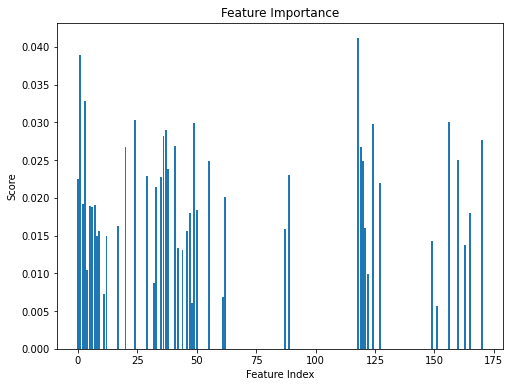

In [59]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.show()

In [60]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_p.drop(drop_cols, axis=1, inplace=True)

In [61]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 79.74%
ROC AUC: 0.6590659340659341
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       175
         1.0       0.58      0.40      0.48        52

    accuracy                           0.80       227
   macro avg       0.71      0.66      0.68       227
weighted avg       0.78      0.80      0.78       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7701098901098901
Precision-Recall AUC: 0.5310872744270962


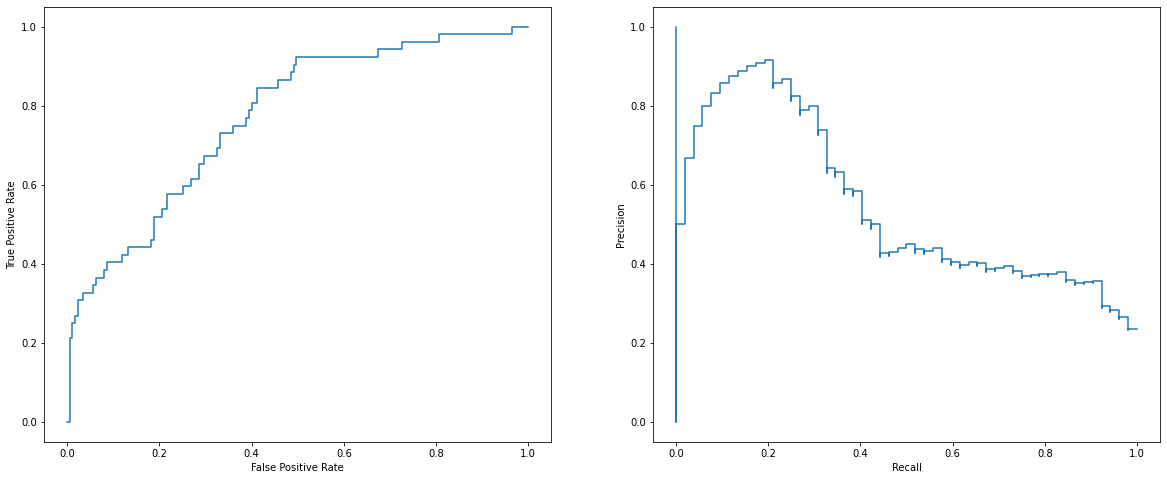

In [62]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_p, tpr_p, _ = roc_curve(y_test, probabilities)
roc_display_p = RocCurveDisplay(fpr=fpr_p, tpr=tpr_p)
roc_auc_p = auc(fpr_p, tpr_p)

prec_p, recall_p, _ = precision_recall_curve(y_test, probabilities)
pr_auc_p = auc(recall_p, prec_p)
pr_display_p = PrecisionRecallDisplay(precision=prec_p, recall=recall_p)

print('ROC AUC:', roc_auc_p)
print('Precision-Recall AUC:', pr_auc_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_p.plot(ax=ax1)
pr_display_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


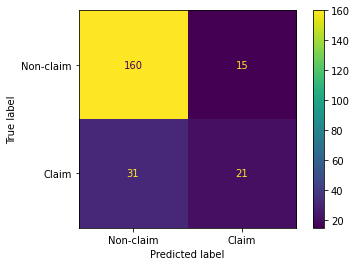

In [63]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 5, 'SubClass_Shippers_&_Packers': 1, 'Territory_AUSTRALIA': 1, 'RARC': 1, 'Limit_100Pct_USD': 1, 'LeaderLinePct': 1, 'Ded_100Pct_USD': 2, 'BrokerUltimateName_R_K_HARRISON': 1, 'SubClass_Private_Collection': 1}
gain:  {'Full_GGTP': 31.116365044, 'SubClass_Shippers_&_Packers': 17.8500366, 'Territory_AUSTRALIA': 9.4959259, 'RARC': 8.80000305, 'Limit_100Pct_USD': 0.666666627, 'LeaderLinePct': 0.666666627, 'Ded_100Pct_USD': 42.318799999999996, 'BrokerUltimateName_R_K_HARRISON': 4.71184158, 'SubClass_Private_Collection': 19.8390617}
cover:  {'Full_GGTP': 75.15, 'SubClass_Shippers_&_Packers': 127.25, 'Territory_AUSTRALIA': 122.0, 'RARC': 120.0, 'Limit_100Pct_USD': 2.0, 'LeaderLinePct': 2.0, 'Ded_100Pct_USD': 133.125, 'Brok

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


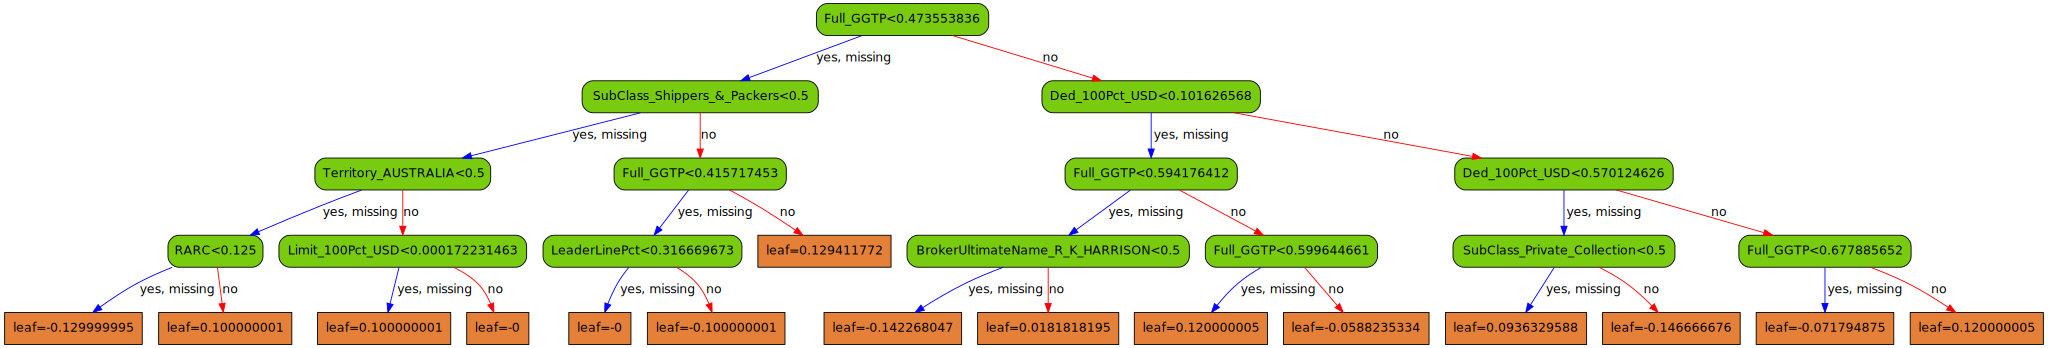

In [64]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [66]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [9, 10, 11]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [67]:
# print(optimal_params.best_params_)

In [68]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=5,
                          scale_pos_weight=10,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.20530
[1]	validation_0-aucpr:0.41358
[2]	validation_0-aucpr:0.42252
[3]	validation_0-aucpr:0.44282
[4]	validation_0-aucpr:0.45930
[5]	validation_0-aucpr:0.51249
[6]	validation_0-aucpr:0.50794
[7]	validation_0-aucpr:0.49770
[8]	validation_0-aucpr:0.49242
[9]	validation_0-aucpr:0.53418
[10]	validation_0-aucpr:0.56012
[11]	validation_0-aucpr:0.58773
[12]	validation_0-aucpr:0.57028
[13]	validation_0-aucpr:0.59264
[14]	validation_0-aucpr:0.60896
[15]	validation_0-aucpr:0.59007
[16]	validation_0-aucpr:0.59775
[17]	validation_0-aucpr:0.58882
[18]	validation_0-aucpr:0.61067
[19]	validation_0-aucpr:0.61445
[20]	validation_0-aucpr:0.61175
[21]	validation_0-aucpr:0.60498
[22]	validation_0-aucpr:0.62230
[23]	validation_0-aucpr:0.61978
[24]	validation_0-aucpr:0.63074
[25]	validation_0-aucpr:0.62446
[26]	validation_0-aucpr:0.62571
[27]	validation_0-aucpr:0.62553
[28]	validation_0-aucpr:0.63231
[29]	validation_0-aucpr:0.63928
[30]	validation_0-aucpr:0.63869
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=10, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [69]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.665638
Best iteration: 31


Top 10 most important features
Feature: Full_GGTP 
 Score: 0.02962
Feature: BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES 
 Score: 0.03006
Feature: PLR 
 Score: 0.03362
Feature: Territory_QATAR 
 Score: 0.03553
Feature: SubClass_Retail 
 Score: 0.03590
Feature: SubClass_ATM 
 Score: 0.03751
Feature: BrokerUltimateName_THB_GROUP 
 Score: 0.03818
Feature: Territory_ARGENTINA 
 Score: 0.04250
Feature: BrokerUltimateName_MARSH 
 Score: 0.05439
Feature: Territory_WORLDWIDE 
 Score: 0.10104


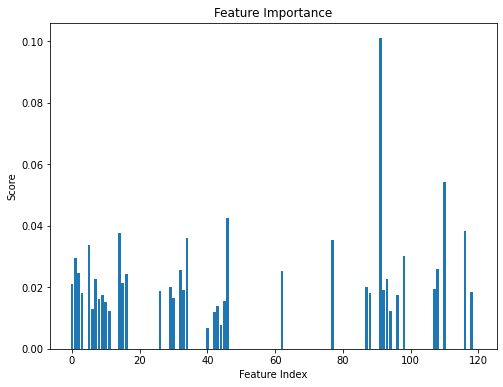

In [70]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.show()

In [71]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_e.drop(drop_cols, axis=1, inplace=True)

In [72]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 90.11%
ROC AUC: 0.7763554216867469
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94        83
         1.0       0.45      0.62      0.53         8

    accuracy                           0.90        91
   macro avg       0.71      0.78      0.74        91
weighted avg       0.92      0.90      0.91        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8795180722891566
Precision-Recall AUC: 0.665409103364666


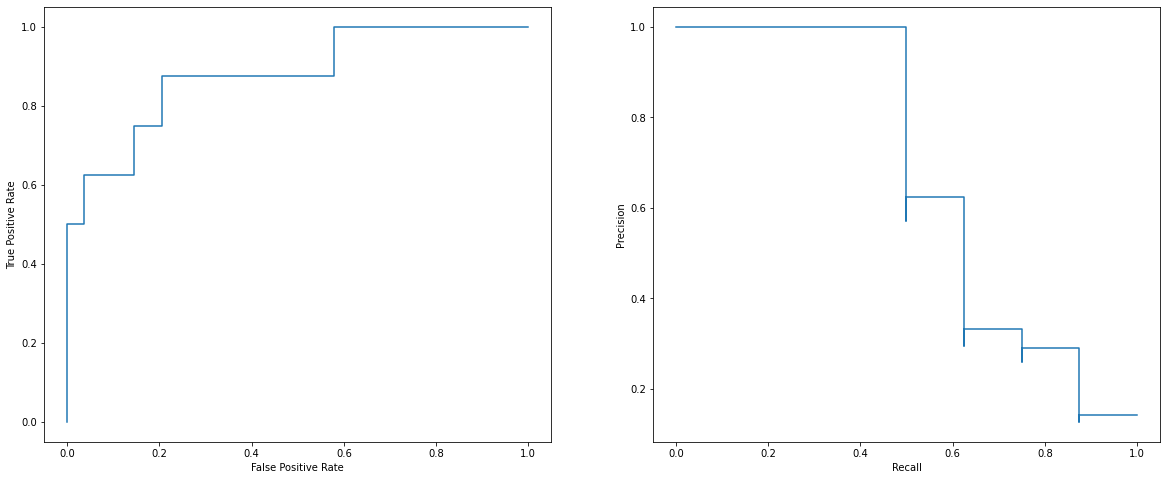

In [73]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_e, tpr_e, _ = roc_curve(y_test, probabilities)
roc_display_e = RocCurveDisplay(fpr=fpr_e, tpr=tpr_e)
roc_auc_e = auc(fpr_e, tpr_e)

prec_e, recall_e, _ = precision_recall_curve(y_test, probabilities)
pr_auc_e = auc(recall_e, prec_e)
pr_display_e = PrecisionRecallDisplay(precision=prec_e, recall=recall_e)

print('ROC AUC:', roc_auc_e)
print('Precision-Recall AUC:', pr_auc_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_e.plot(ax=ax1)
pr_display_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


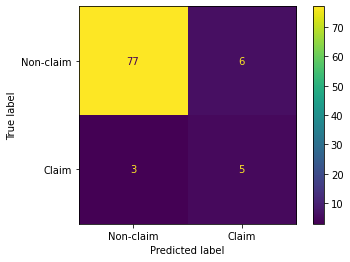

In [74]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_WORLDWIDE': 1, 'BrokerUltimateName_MARSH': 1, 'SubClass_Retail': 1, 'Territory_GERMANY': 1, 'BrokerFeePct': 2, 'PricingStrength': 2, 'Full_GGTP': 2, 'StatsMinorClassCode_WA': 1, 'BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED': 1, 'BrokerUltimateName_WILLIS': 1}
gain:  {'Territory_WORLDWIDE': 127.909004, 'BrokerUltimateName_MARSH': 51.917923, 'SubClass_Retail': 23.3012009, 'Territory_GERMANY': 11.1317291, 'BrokerFeePct': 8.895257465, 'PricingStrength': 9.55365563, 'Full_GGTP': 20.670162649999998, 'StatsMinorClassCode_WA': 17.7645397, 'BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED': 11.1225204, 'BrokerUltimateName_WILLIS': 11.0955124}
cover:  {'Territory_WORLDWIDE': 163.0, 'BrokerUltimateName_MARSH': 68.0, 'SubClass_Retail'

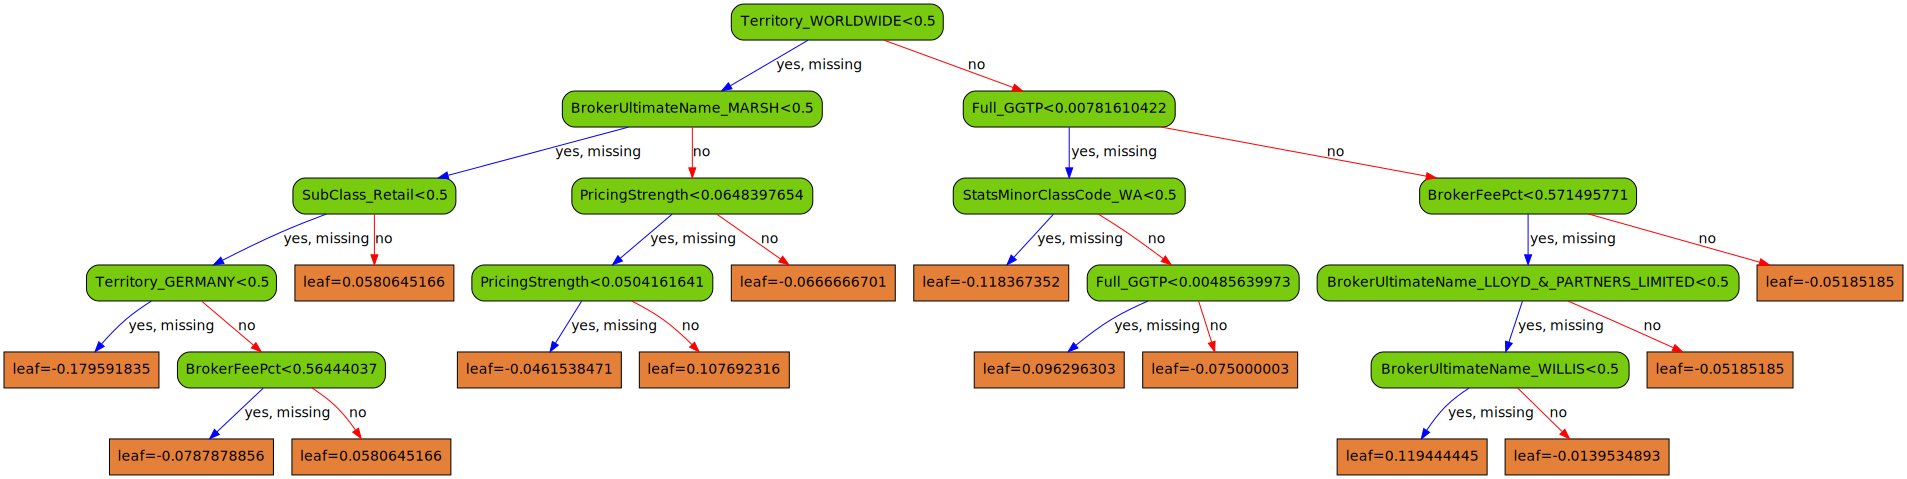

In [75]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=5,
                          scale_pos_weight=10,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Splitting the Dataset into Training and Testing

In [76]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)

## Random Over Sampler

In [77]:
ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_res_p, y_train_res_p = ros.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_res_e, y_train_res_e = ros.fit_resample(X_train_e, y_train_e)

### XGBoost (ROS)

#### Primary business

In [78]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_p, y_train_res_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [79]:
# print(optimal_params.best_params_)

In [80]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_res_p, y_train_res_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.34968
[1]	validation_0-aucpr:0.36391
[2]	validation_0-aucpr:0.42620
[3]	validation_0-aucpr:0.40788
[4]	validation_0-aucpr:0.41292
[5]	validation_0-aucpr:0.44548
[6]	validation_0-aucpr:0.46052
[7]	validation_0-aucpr:0.42943
[8]	validation_0-aucpr:0.45113
[9]	validation_0-aucpr:0.46234
[10]	validation_0-aucpr:0.44803
[11]	validation_0-aucpr:0.44676
[12]	validation_0-aucpr:0.45700
[13]	validation_0-aucpr:0.46424
[14]	validation_0-aucpr:0.46433
[15]	validation_0-aucpr:0.46603
[16]	validation_0-aucpr:0.46799
[17]	validation_0-aucpr:0.46568
[18]	validation_0-aucpr:0.47316
[19]	validation_0-aucpr:0.46482
[20]	validation_0-aucpr:0.46358
[21]	validation_0-aucpr:0.45446
[22]	validation_0-aucpr:0.46105
[23]	validation_0-aucpr:0.44787
[24]	validation_0-aucpr:0.44056
[25]	validation_0-aucpr:0.45712
[26]	validation_0-aucpr:0.46076
[27]	validation_0-aucpr:0.45337


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [81]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.473163
Best iteration: 18


In [82]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 68.28%
ROC AUC: 0.7131868131868131
              precision    recall  f1-score   support

         0.0       0.91      0.66      0.76       175
         1.0       0.40      0.77      0.53        52

    accuracy                           0.68       227
   macro avg       0.65      0.71      0.64       227
weighted avg       0.79      0.68      0.71       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.757032967032967
Precision-Recall AUC: 0.4717060760207553


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


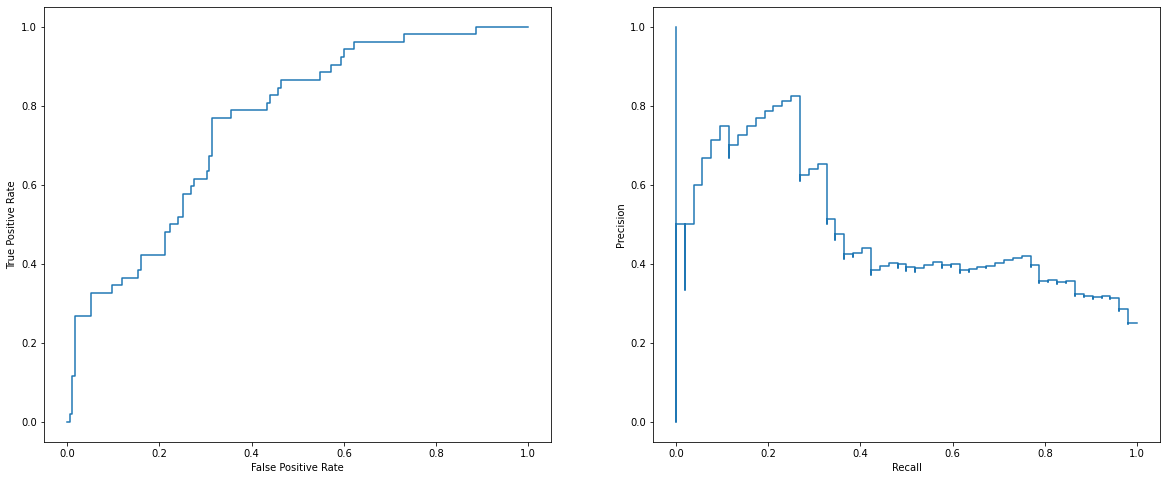

In [83]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_ros_p, tpr_ros_p, _ = roc_curve(y_test_p, probabilities)
roc_display_ros_p = RocCurveDisplay(fpr=fpr_ros_p, tpr=tpr_ros_p)
roc_auc_ros_p = auc(fpr_ros_p, tpr_ros_p)

prec_ros_p, recall_ros_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_ros_p = auc(recall_ros_p, prec_ros_p)
pr_display_ros_p = PrecisionRecallDisplay(precision=prec_ros_p, recall=recall_ros_p)

print('ROC AUC:', roc_auc_ros_p)
print('Precision-Recall AUC:', pr_auc_ros_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_p.plot(ax=ax1)
pr_display_ros_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


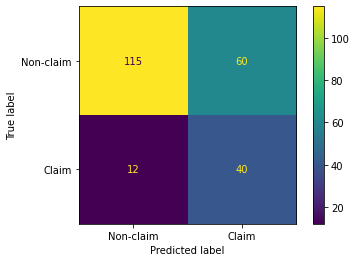

In [84]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 6, 'Limit_100Pct_USD': 1, 'BrokerFeePct': 3, 'Territory_WORLDWIDE': 1, 'PricingStrength': 1, 'SubClass_Wholesale_': 1, 'SubClass_Excess_SIPA': 1, 'SubClass_Corporate_Collection': 1, 'LeaderLinePct': 2, 'Territory_USA': 1}
gain:  {'Full_GGTP': 62.76387858333333, 'Limit_100Pct_USD': 65.9211044, 'BrokerFeePct': 25.997208900000004, 'Territory_WORLDWIDE': 15.4293671, 'PricingStrength': 24.3153706, 'SubClass_Wholesale_': 25.8123474, 'SubClass_Excess_SIPA': 115.40271, 'SubClass_Corporate_Collection': 45.2939453, 'LeaderLinePct': 20.9862671, 'Territory_USA': 31.6865501}
cover:  {'Full_GGTP': 402.0, 'Limit_100Pct_USD': 38.0, 'BrokerFeePct': 316.8333333333333, 'Territory_WORLDWIDE': 71.25, 'PricingStrength': 43.75, 'SubClass_

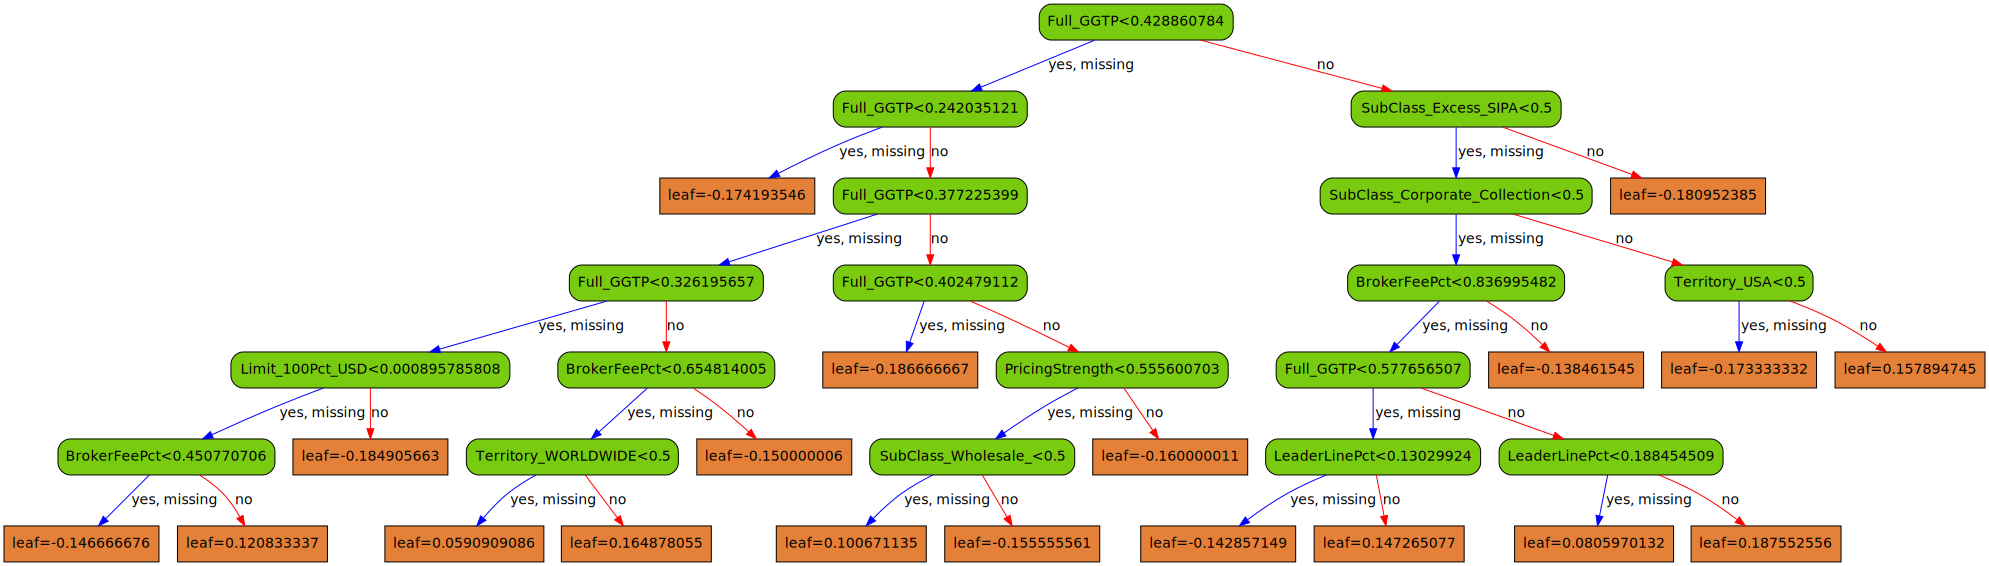

In [85]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=5,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_p, y_train_res_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [86]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_e, y_train_res_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [87]:
# print(optimal_params.best_params_)

In [88]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_res_e, y_train_res_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.27289
[1]	validation_0-aucpr:0.44492


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.36992
[3]	validation_0-aucpr:0.52439
[4]	validation_0-aucpr:0.38739
[5]	validation_0-aucpr:0.52524
[6]	validation_0-aucpr:0.39753
[7]	validation_0-aucpr:0.39919
[8]	validation_0-aucpr:0.41531
[9]	validation_0-aucpr:0.53434
[10]	validation_0-aucpr:0.54700
[11]	validation_0-aucpr:0.53010
[12]	validation_0-aucpr:0.52520
[13]	validation_0-aucpr:0.52740
[14]	validation_0-aucpr:0.52669
[15]	validation_0-aucpr:0.54485
[16]	validation_0-aucpr:0.60713
[17]	validation_0-aucpr:0.60887
[18]	validation_0-aucpr:0.61634
[19]	validation_0-aucpr:0.60991
[20]	validation_0-aucpr:0.60328
[21]	validation_0-aucpr:0.60132
[22]	validation_0-aucpr:0.55805
[23]	validation_0-aucpr:0.59516
[24]	validation_0-aucpr:0.58793
[25]	validation_0-aucpr:0.53461
[26]	validation_0-aucpr:0.53451
[27]	validation_0-aucpr:0.53159
[28]	validation_0-aucpr:0.51172


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [89]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.616343
Best iteration: 18


In [90]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 81.32%
ROC AUC: 0.8411144578313254
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89        83
         1.0       0.30      0.88      0.45         8

    accuracy                           0.81        91
   macro avg       0.64      0.84      0.67        91
weighted avg       0.93      0.81      0.85        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9262048192771084
Precision-Recall AUC: 0.615940688579507


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


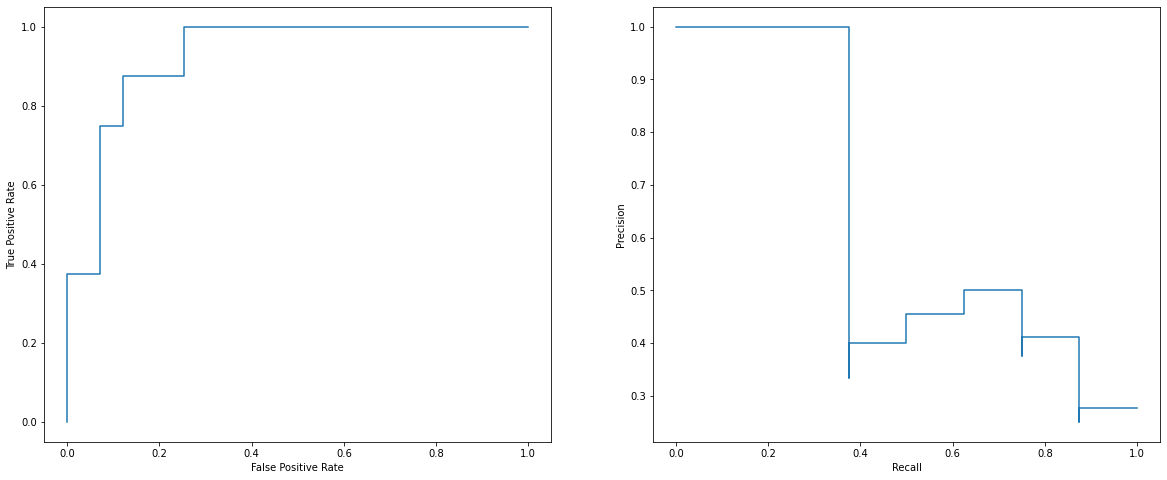

In [91]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_ros_e, tpr_ros_e, _ = roc_curve(y_test_e, probabilities)
roc_display_ros_e = RocCurveDisplay(fpr=fpr_ros_e, tpr=tpr_ros_e)
roc_auc_ros_e = auc(fpr_ros_e, tpr_ros_e)

prec_ros_e, recall_ros_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_ros_e = auc(recall_ros_e, prec_ros_e)
pr_display_ros_e = PrecisionRecallDisplay(precision=prec_ros_e, recall=recall_ros_e)

print('ROC AUC:', roc_auc_ros_e)
print('Precision-Recall AUC:', pr_auc_ros_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_e.plot(ax=ax1)
pr_display_ros_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


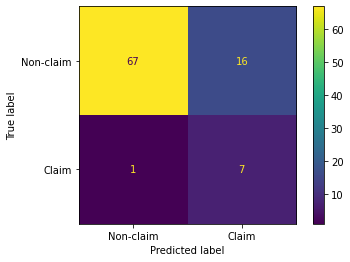

In [92]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_WORLDWIDE': 1, 'BrokerUltimateName_MARSH': 1, 'BrokerFeePct': 1, 'PricingStrength': 4, 'StatsMinorClassCode_SP': 1, 'PLR': 1, 'LeaderLinePct': 1, 'Limit_100Pct_USD': 1, 'Full_GGTP': 1, 'LeaderStatus_FOLLOW': 1, 'StatsMinorClassCode_JB': 1, 'BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED': 1}
gain:  {'Territory_WORLDWIDE': 168.043091, 'BrokerUltimateName_MARSH': 144.255447, 'BrokerFeePct': 93.0973969, 'PricingStrength': 26.098068225, 'StatsMinorClassCode_SP': 28.9972725, 'PLR': 12.21064, 'LeaderLinePct': 1.30780792, 'Limit_100Pct_USD': 11.8844442, 'Full_GGTP': 33.6141663, 'LeaderStatus_FOLLOW': 25.3314209, 'StatsMinorClassCode_JB': 22.7871704, 'BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED': 20.1036987}
cover:  {'Territory_

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


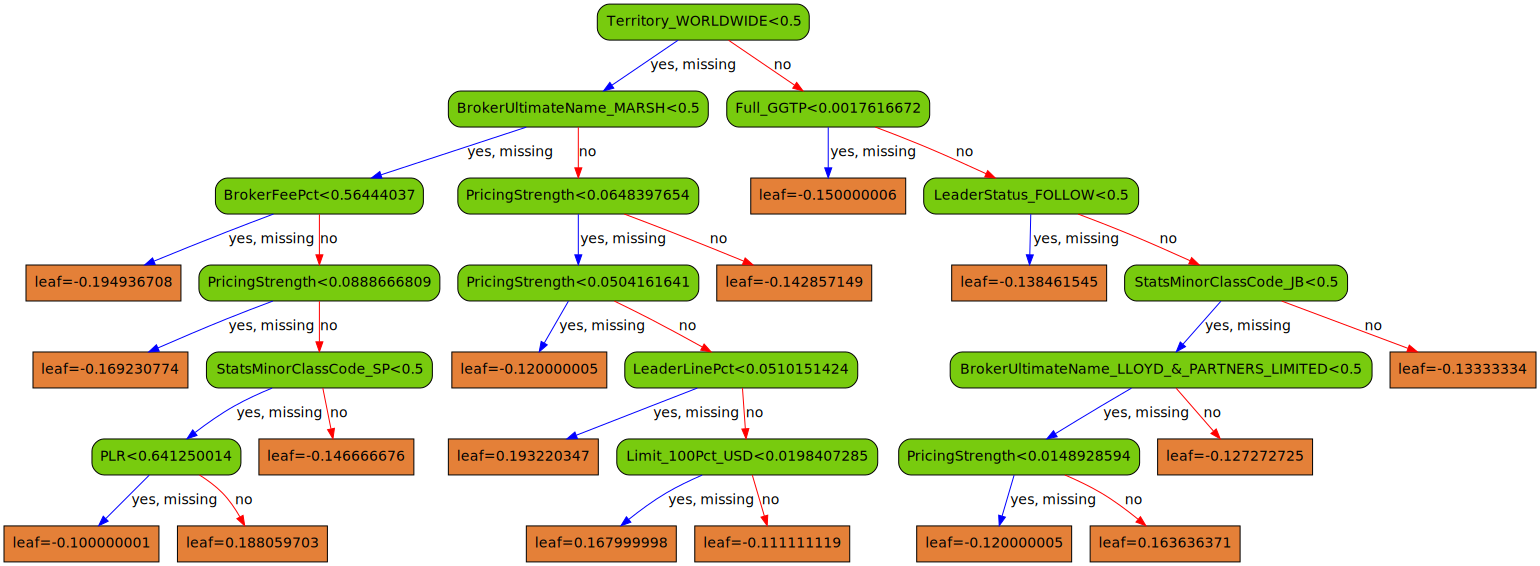

In [93]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_e, y_train_res_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## SMOTE

In [94]:
sm = SMOTE(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_sm_p, y_train_sm_p = sm.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_sm_e, y_train_sm_e = sm.fit_resample(X_train_e, y_train_e)

### XGBoost (SMOTE)

#### Primary business

In [95]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_p, y_train_sm_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [96]:
# print(optimal_params.best_params_)

In [97]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_sm_p, y_train_sm_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.34040
[1]	validation_0-aucpr:0.39687
[2]	validation_0-aucpr:0.37827
[3]	validation_0-aucpr:0.37382
[4]	validation_0-aucpr:0.44193
[5]	validation_0-aucpr:0.42805
[6]	validation_0-aucpr:0.45769
[7]	validation_0-aucpr:0.46963
[8]	validation_0-aucpr:0.45628
[9]	validation_0-aucpr:0.47646
[10]	validation_0-aucpr:0.48196
[11]	validation_0-aucpr:0.47974
[12]	validation_0-aucpr:0.47765
[13]	validation_0-aucpr:0.49240
[14]	validation_0-aucpr:0.50432
[15]	validation_0-aucpr:0.49970
[16]	validation_0-aucpr:0.50116
[17]	validation_0-aucpr:0.49417
[18]	validation_0-aucpr:0.50912
[19]	validation_0-aucpr:0.49430
[20]	validation_0-aucpr:0.50031
[21]	validation_0-aucpr:0.51026
[22]	validation_0-aucpr:0.50568
[23]	validation_0-aucpr:0.50813
[24]	validation_0-aucpr:0.50916
[25]	validation_0-aucpr:0.51344
[26]	validation_0-aucpr:0.50876
[27]	validation_0-aucpr:0.51328
[28]	validation_0-aucpr:0.51441
[29]	validation_0-aucpr:0.51884
[30]	validation_0-aucpr:0.51481
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [98]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.525485
Best iteration: 34


In [99]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 63.00%
ROC AUC: 0.6653846153846155
              precision    recall  f1-score   support

         0.0       0.88      0.60      0.71       175
         1.0       0.35      0.73      0.48        52

    accuracy                           0.63       227
   macro avg       0.62      0.67      0.59       227
weighted avg       0.76      0.63      0.66       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7636263736263736
Precision-Recall AUC: 0.5253607387369138


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


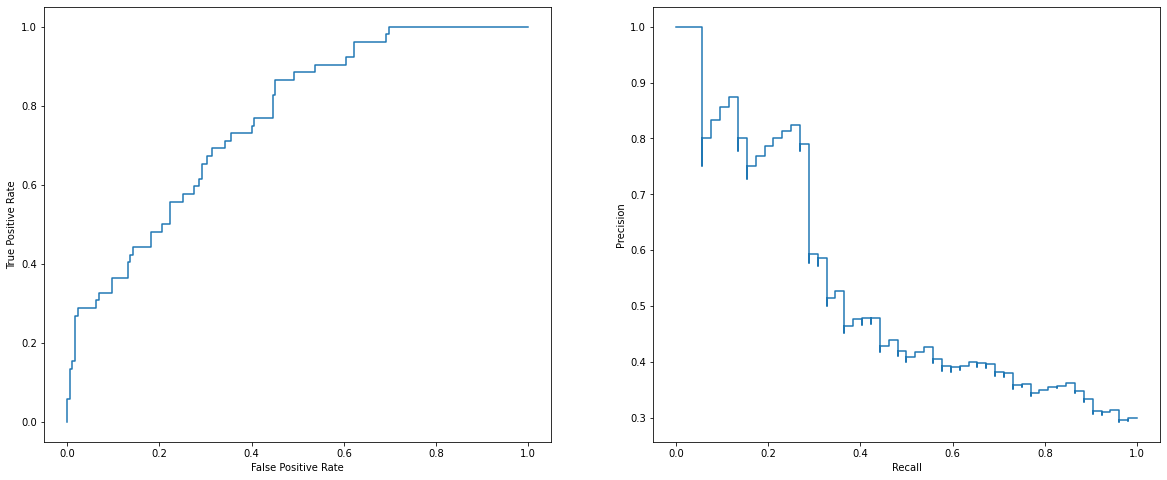

In [100]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_sm_p, tpr_sm_p, _ = roc_curve(y_test_p, probabilities)
roc_display_sm_p = RocCurveDisplay(fpr=fpr_sm_p, tpr=tpr_sm_p)
roc_auc_sm_p = auc(fpr_sm_p, tpr_sm_p)

prec_sm_p, recall_sm_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_sm_p = auc(recall_sm_p, prec_sm_p)
pr_display_sm_p = PrecisionRecallDisplay(precision=prec_sm_p, recall=recall_sm_p)

print('ROC AUC:', roc_auc_sm_p)
print('Precision-Recall AUC:', pr_auc_sm_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_p.plot(ax=ax1)
pr_display_sm_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


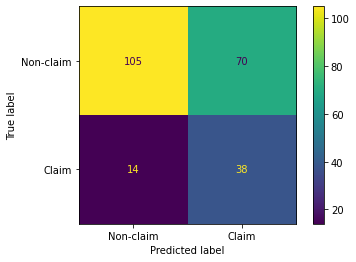

In [101]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 7, 'Limit_100Pct_USD': 1, 'Territory_MALAYSIA': 1, 'Territory_USA': 1, 'PLR': 2, 'BrokerFeePct': 3, 'BrokerUltimateName_WILLIS': 2, 'PricingStrength': 4, 'Full_GrossGrossModelPrice': 1, 'LeaderLinePct': 3, 'SubClass_Pawn_Broker': 1, 'Territory_CANADA': 1, 'Ded_100Pct_USD': 4, 'BrokerUltimateName_MARSH': 1, 'RARC': 1, 'SubClass_Excess_SIPA': 1}
gain:  {'Full_GGTP': 53.586157372857144, 'Limit_100Pct_USD': 16.9882164, 'Territory_MALAYSIA': 13.8103027, 'Territory_USA': 6.08026886, 'PLR': 25.2648115, 'BrokerFeePct': 19.372984573333333, 'BrokerUltimateName_WILLIS': 6.95742796, 'PricingStrength': 13.1704125395, 'Full_GrossGrossModelPrice': 2.39574051, 'LeaderLinePct': 9.805156085, 'SubClass_Pawn_Broker': 8.91441154, 'Terri

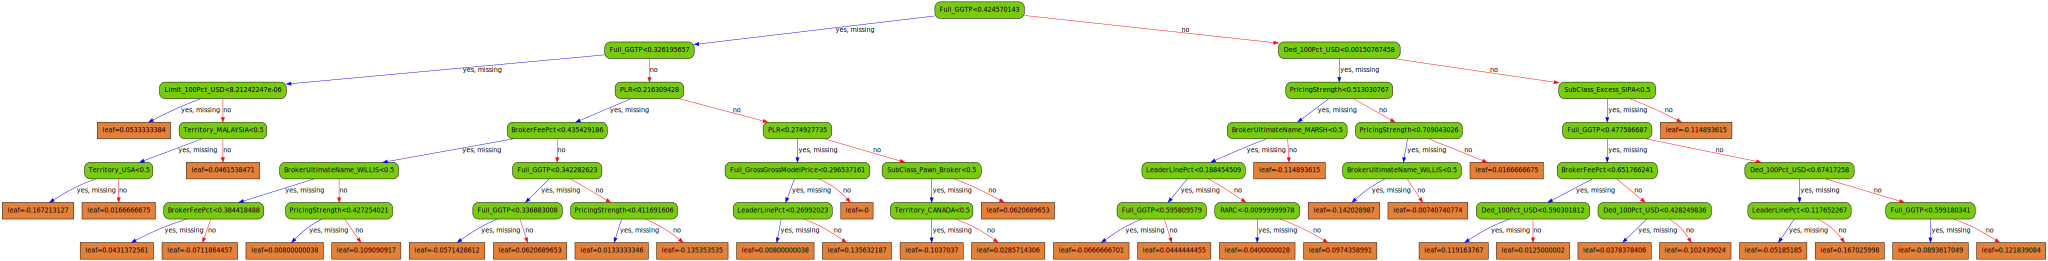

In [102]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [103]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_e, y_train_sm_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [104]:
# print(optimal_params.best_params_)

In [105]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_sm_e, y_train_sm_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.12660
[1]	validation_0-aucpr:0.15436


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.27602
[3]	validation_0-aucpr:0.26790
[4]	validation_0-aucpr:0.26845
[5]	validation_0-aucpr:0.26989
[6]	validation_0-aucpr:0.34272
[7]	validation_0-aucpr:0.31007
[8]	validation_0-aucpr:0.35276
[9]	validation_0-aucpr:0.34137
[10]	validation_0-aucpr:0.35124
[11]	validation_0-aucpr:0.34904
[12]	validation_0-aucpr:0.35161
[13]	validation_0-aucpr:0.34670
[14]	validation_0-aucpr:0.35686
[15]	validation_0-aucpr:0.35177
[16]	validation_0-aucpr:0.37021
[17]	validation_0-aucpr:0.34147
[18]	validation_0-aucpr:0.33217
[19]	validation_0-aucpr:0.33468
[20]	validation_0-aucpr:0.31799
[21]	validation_0-aucpr:0.33263
[22]	validation_0-aucpr:0.31496
[23]	validation_0-aucpr:0.31543
[24]	validation_0-aucpr:0.48438
[25]	validation_0-aucpr:0.43271
[26]	validation_0-aucpr:0.43428
[27]	validation_0-aucpr:0.48452
[28]	validation_0-aucpr:0.49248
[29]	validation_0-aucpr:0.50790
[30]	validation_0-aucpr:0.51270
[31]	validation_0-aucpr:0.51560
[32]	validation_0-aucpr:0.51311
[33]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [106]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.538994
Best iteration: 38


In [107]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 73.63%
ROC AUC: 0.7989457831325302
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83        83
         1.0       0.23      0.88      0.37         8

    accuracy                           0.74        91
   macro avg       0.61      0.80      0.60        91
weighted avg       0.92      0.74      0.79        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.878012048192771
Precision-Recall AUC: 0.5381182275541796


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


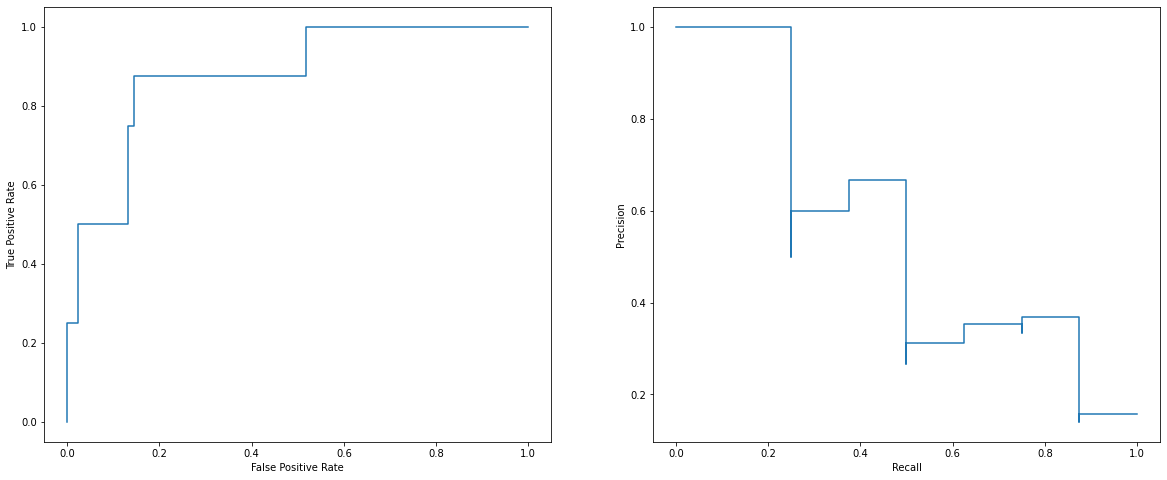

In [108]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_sm_e, tpr_sm_e, _ = roc_curve(y_test_e, probabilities)
roc_display_sm_e = RocCurveDisplay(fpr=fpr_sm_e, tpr=tpr_sm_e)
roc_auc_sm_e = auc(fpr_sm_e, tpr_sm_e)

prec_sm_e, recall_sm_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_sm_e = auc(recall_sm_e, prec_sm_e)
pr_display_sm_e = PrecisionRecallDisplay(precision=prec_sm_e, recall=recall_sm_e)

print('ROC AUC:', roc_auc_sm_e)
print('Precision-Recall AUC:', pr_auc_sm_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_e.plot(ax=ax1)
pr_display_sm_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


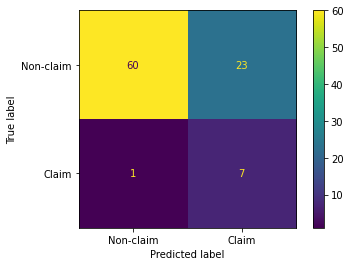

In [109]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 8, 'Limit_100Pct_USD': 2, 'Territory_MALAYSIA': 1, 'Territory_USA': 2, 'PLR': 3, 'BrokerFeePct': 2, 'PricingStrength': 3, 'Full_GrossGrossModelPrice': 1, 'LeaderLinePct': 2, 'SubClass_Pawn_Broker': 1, 'Territory_CANADA': 1, 'Ded_100Pct_USD': 3, 'BrokerUltimateName_MARSH': 1, 'RARC': 1, 'BrokerUltimateName_WILLIS': 1, 'SubClass_Excess_SIPA': 1, 'SubClass_Mining': 1}
gain:  {'Full_GGTP': 41.05154531700001, 'Limit_100Pct_USD': 8.542331710000001, 'Territory_MALAYSIA': 11.1441765, 'Territory_USA': 11.484077450000001, 'PLR': 17.10744348333333, 'BrokerFeePct': 21.501031849999997, 'PricingStrength': 14.273337040000001, 'Full_GrossGrossModelPrice': 1.63438225, 'LeaderLinePct': 4.6151266115, 'SubClass_Pawn_Broker': 6.20492363

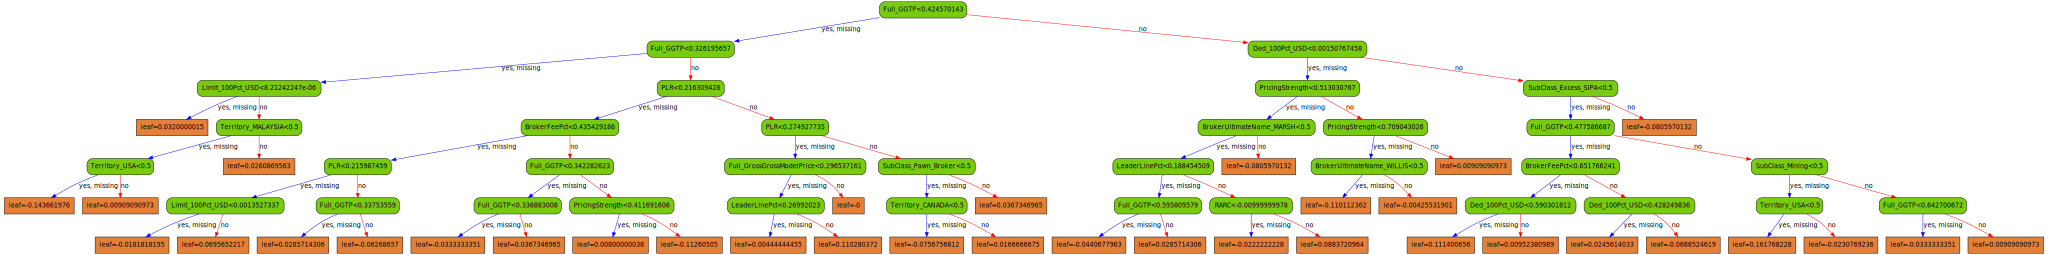

In [110]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## GAN

In [111]:
def generator_network(x, data_dim, base_n_count): 
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    x = layers.Dense(data_dim)(x)    
    return x

def discriminator_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    # x = layers.Dense(1)(x)
    return x

In [112]:
def generator_network_w_label(x, labels, data_dim, label_dim, base_n_count): 
    x = layers.concatenate([x,labels])
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    x = layers.Dense(data_dim)(x)    
    x = layers.concatenate([x,labels])
    return x

In [113]:
def get_data_batch(train, batch_size, seed=42):
    # # random sampling - some samples will have excessively low or high sampling, but easy to implement
    # np.random.seed(seed)
    # x = train.loc[ np.random.choice(train.index, batch_size) ].values
    
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )

In [114]:
def CheckAccuracy( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

In [115]:
def CheckAccuracyConditional( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols_w_class)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols_w_class)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

#### Primary Business

In [116]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS,Class
46,0.003643,0.316038,0.334282,0.000000,0.153605,0.00,0.000000,0.530972,0.424690,1,...,0,0,0,0,0,0,0,0,0,0.0
59,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,1,1.0
828,0.010285,0.358672,0.299057,0.635174,0.216301,0.00,0.000000,0.445331,0.396154,0,...,0,0,0,0,0,0,0,0,0,0.0
100,0.025733,0.543195,0.237586,0.675864,0.122257,-0.05,0.000000,0.618436,0.885705,1,...,0,0,0,0,0,0,0,0,0,0.0
760,0.007505,0.519434,0.286257,0.506829,0.156677,0.10,0.749134,0.524216,0.627966,1,...,0,0,0,0,0,1,0,0,0,0.0


In [117]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,0,1
1,0.020109,0.436800,0.255968,0.000000,0.184953,0.00,0.000000,0.494795,0.363324,0,...,0,0,0,0,0,0,0,0,0,1
2,0.025733,0.452556,0.334282,0.000000,0.166082,0.00,0.704578,0.506837,0.081038,1,...,0,0,1,0,0,0,0,0,0,0
3,0.010285,0.577677,0.334245,0.564498,0.278997,0.00,0.000000,0.347922,0.463044,1,...,0,0,0,0,0,0,1,0,0,0
4,0.031799,0.794542,0.299057,0.512429,0.291536,0.75,0.000000,0.349847,0.186895,1,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [119]:
# with_class=False
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [120]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [121]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [122]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1)-1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [123]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [124]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [125]:
# gan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_p.to_csv('specie_gan_primary.csv',index=False)

In [126]:
gan_samples_p = pd.read_csv('../input/project/specie_gan_primary.csv')
gan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,-0.000775,0.713888,0.294897,0.539721,0.285183,-0.000212,0.002377,0.320570,0.412081,0.003390,...,-0.004304,0.000655,-0.000494,0.001274,-0.001044,0.001867,-0.001523,0.001658,-0.001341,0.006477
1,-0.000775,0.713888,0.294897,0.539721,0.285183,-0.000212,0.002377,0.320570,0.412081,0.003390,...,-0.004304,0.000655,-0.000494,0.001274,-0.001044,0.001867,-0.001523,0.001658,-0.001341,0.006477
2,0.001417,0.634023,0.283157,0.552152,0.350442,0.000168,0.002113,0.250122,0.496469,0.003725,...,-0.003020,0.000775,0.001037,0.001918,0.001121,0.000884,-0.003751,-0.000400,-0.004116,0.006870
3,-0.000398,0.667702,0.300951,0.540017,0.256622,-0.000515,0.002787,0.342385,0.380013,0.002742,...,-0.004377,0.000285,0.000510,0.001481,0.000283,0.001919,-0.000928,0.000825,-0.001831,0.006733
4,-0.000775,0.713888,0.294897,0.539721,0.285183,-0.000212,0.002377,0.320570,0.412081,0.003390,...,-0.004304,0.000655,-0.000494,0.001274,-0.001044,0.001867,-0.001523,0.001658,-0.001341,0.006477


In [127]:
# # Placing Basis
# column = [i for i in gen_samples_p.columns if 'PlacingBasis' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Subclass
# column = [i for i in gen_samples_p.columns if 'SubClass' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Stats Minor Class Code
# column = [i for i in gen_samples_p.columns if 'StatsMinorClassCode' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Territory
# column = [i for i in gen_samples_p.columns if 'Territory' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Leader Status
# column = [i for i in gen_samples_p.columns if 'LeaderStatus' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples


# # Broker
# column = [i for i in gen_samples_p.columns if 'BrokerUltimateName' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

In [128]:
X_gan_p = X_train_p.append(gan_samples_p, ignore_index = True)
X_gan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,0.036028,0.526655,0.296088,0.429177,0.244722,-0.002234,0.062207,0.406806,0.456125,0.507833,...,0.136671,0.038247,0.105805,0.016934,0.010529,0.022132,0.123193,0.010177,0.025901,0.143548
std,0.093703,0.128902,0.070941,0.238172,0.100051,0.050995,0.201023,0.127086,0.159158,0.498735,...,0.344884,0.191126,0.306880,0.127284,0.099634,0.144971,0.329991,0.099663,0.163019,0.347297
min,-0.001368,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,...,-0.004448,0.000000,-0.004819,-0.012289,-0.008814,-0.005381,-0.004932,-0.002109,-0.009612,-0.009330
25%,0.000847,0.443258,0.272016,0.364945,0.197586,-0.000212,0.000000,0.320570,0.382096,0.003390,...,-0.000612,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001523,0.000000,-0.001847,0.000000
50%,0.003851,0.551727,0.294897,0.539721,0.220185,0.000000,0.000000,0.408142,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.023158,0.605711,0.321327,0.577618,0.285183,0.000000,0.002377,0.461914,0.557805,1.000000,...,0.000000,0.000655,0.001823,0.001274,0.000250,0.001642,0.000000,0.000174,0.000000,0.007114
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,...,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.054874,0.469149,0.293514,0.357168,0.209510,-0.003977,0.094861,0.463288,0.460382,0.781215,...,0.212155,0.058564,0.162431,0.025414,0.015470,0.033149,0.191160,0.015470,0.041989,0.217680
std,0.111966,0.120602,0.087138,0.269372,0.095258,0.063262,0.243563,0.116280,0.186778,0.413651,...,0.409060,0.234936,0.369050,0.157467,0.123479,0.179125,0.393432,0.123479,0.200675,0.412897
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002878,0.398031,0.255968,0.000000,0.153605,0.000000,0.000000,0.410269,0.386336,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011553,0.472519,0.299057,0.459332,0.216301,0.000000,0.000000,0.427261,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.042934,0.549160,0.334245,0.549755,0.228840,0.000000,0.000000,0.529260,0.578106,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [130]:
ones = np.ones((len(gan_samples_p),))
one = pd.Series(ones)
y_gan_p = y_train_p.append(one, ignore_index=True)
# y_gan_p

#### Excess Business

In [131]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,Class
135,0.444353,0.022647,0.020748,0.044516,0.65,0.0,0.0,0.117284,0.511007,0.0,...,0,0,0,0,0,0,1,0,0,0.0
292,0.019282,0.000692,0.218997,0.244842,0.84,0.0,0.0,0.025610,0.517404,0.0,...,1,0,0,0,0,0,0,0,1,0.0
418,0.006780,0.001924,0.100850,0.002225,0.75,0.0,0.0,0.042955,0.564440,0.0,...,0,0,0,0,0,1,0,0,0,0.0
127,0.222094,0.052329,0.036254,0.267100,0.85,0.0,0.0,0.029610,0.531515,0.0,...,0,0,0,0,0,0,1,0,0,1.0
226,0.138746,0.019172,0.031602,0.055645,0.75,0.0,0.0,0.065443,0.103481,0.0,...,0,0,0,0,1,0,0,0,0,0.0


In [132]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.222094,0.052329,0.036254,0.267100,0.850000,0.000,0.0,0.029610,0.531515,0.0,...,1,0,0,0,0,0,0,1,0,0
1,0.139024,0.014540,0.009870,0.380785,0.760449,0.084,0.0,0.029609,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0
2,0.027617,0.712532,0.091453,0.003894,0.750000,0.000,0.0,0.064238,0.113082,0.0,...,1,0,0,0,0,0,0,0,0,0
3,0.000195,0.008375,0.100850,0.000002,0.750000,0.000,0.0,0.065443,0.517403,0.0,...,1,0,0,0,1,0,0,0,0,0
4,0.102818,0.017770,0.019198,0.013750,0.750000,0.000,0.0,0.050415,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0


In [133]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 64 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [134]:
# with_class=False
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [135]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [136]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [137]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual fraud data
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [138]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [139]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [140]:
# gan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_e.to_csv('specie_gan_excess.csv',index=False)

In [141]:
gan_samples_e = pd.read_csv('../input/project/specie_gan_excess.csv')
gan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.382284,0.042692,0.012266,0.091013,0.577025,-0.000277,-0.000788,0.110050,0.023276,-0.004660,...,0.897175,-0.000701,-0.004792,-0.003473,0.000272,-0.003378,-0.000253,0.003033,-0.005676,0.002518
1,0.433982,0.036852,0.009188,0.106752,0.637560,-0.001472,-0.004313,0.122471,0.023959,-0.006462,...,0.991981,-0.003600,-0.001712,-0.005806,0.001582,-0.003255,-0.000782,0.005352,-0.006965,0.004047
2,0.486078,0.043485,0.008731,0.124738,0.719717,0.001874,-0.004399,0.142746,0.016438,-0.004396,...,1.117511,-0.002324,-0.001459,-0.003627,0.000194,-0.001841,-0.002601,0.001633,-0.004705,0.003895
3,0.430285,0.093508,0.010009,0.108995,0.695175,-0.001820,-0.005736,0.132840,0.021486,-0.004506,...,1.068843,-0.000589,-0.004361,-0.005184,-0.000296,-0.008795,-0.006221,0.003219,-0.006194,0.000266
4,0.455433,0.072647,0.008114,0.120049,0.707197,-0.000117,-0.005554,0.134458,0.017628,-0.008744,...,1.093410,-0.003130,-0.001138,-0.007372,-0.005759,-0.002335,-0.004925,0.005339,-0.006000,0.004444


In [142]:
# # Placing Basis
# column = [i for i in gan_samples_e.columns if 'PlacingBasis' in i]
# samples = gan_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gan_samples_e[column] = samples

# # Subclass
# column = [i for i in gan_samples_e.columns if 'SubClass' in i]
# samples = gan_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gan_samples_e[column] = samples

# # Stats Minor Class Code
# column = [i for i in gan_samples_e.columns if 'StatsMinorClassCode' in i]
# samples = gan_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gan_samples_e[column] = samples

# # Territory
# column = [i for i in gan_samples_e.columns if 'Territory' in i]
# samples = gan_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gan_samples_e[column] = samples

# # # Leader Status
# # column = [i for i in gan_samples_e.columns if 'LeaderStatus' in i]
# # samples = gan_samples_e[column]
# # max_column = samples.idxmax(axis=1)
# # for col in samples.columns:
# #     samples[col].values[:] = 0
# # for i in range(len(samples)):
# #     samples.iloc[i][max_column[i]] = 1
# # gan_samples_e[column] = samples


# # Broker
# column = [i for i in gan_samples_e.columns if 'BrokerUltimateName' in i]
# samples = gan_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gan_samples_e[column] = samples

In [143]:
X_gan_e = X_train_e.append(gan_samples_e, ignore_index = True)
X_gan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,...,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.243680,0.124129,0.049100,0.094165,0.692156,-0.002698,0.072352,0.099037,0.216570,0.014718,...,0.970839,0.035027,0.039580,0.039864,0.009982,0.021164,0.029309,0.131543,0.001431,0.131350
std,0.187954,0.226793,0.056759,0.110962,0.089281,0.025766,0.225427,0.069724,0.235711,0.065249,...,0.196608,0.187019,0.197892,0.201629,0.094630,0.148939,0.171199,0.335261,0.067450,0.335330
min,0.000000,0.000000,0.000000,-0.006139,0.205000,-0.200000,-0.016395,0.000000,0.000000,-0.022947,...,0.000000,-0.011118,-0.014057,-0.011731,-0.005759,-0.009429,-0.010733,-0.005354,-0.023098,-0.007710
25%,0.055399,0.011685,0.012945,0.012599,0.650000,-0.000792,-0.004901,0.061371,0.022274,-0.006375,...,1.000000,-0.002160,-0.001679,-0.004573,0.000000,-0.003125,-0.001343,0.000000,-0.005761,0.000000
50%,0.222707,0.038506,0.034548,0.089033,0.680696,0.000000,0.000000,0.105299,0.103481,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001542,0.000000,0.001848
75%,0.416570,0.061790,0.075018,0.112487,0.750000,0.000000,0.000000,0.121614,0.413922,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.001778,0.000000,0.000000,0.005847,0.000000,0.005486
max,1.000000,0.973574,1.000000,1.000000,1.021707,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.364931,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.181911,0.026712,0.061285,0.108199,0.700350,-0.004566,0.136421,0.091782,0.353522,0.032548,...,0.934066,0.065934,0.074176,0.076923,0.016484,0.041209,0.054945,0.236264,0.008242,0.236264
std,0.184121,0.055609,0.067703,0.142676,0.097118,0.034634,0.289307,0.090924,0.241497,0.084037,...,0.248508,0.248508,0.262418,0.266836,0.127501,0.199046,0.228187,0.425371,0.090534,0.425371
min,0.000000,0.000000,0.000000,0.000001,0.205000,-0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044925,0.005374,0.028501,0.006249,0.650000,0.000000,0.000000,0.050415,0.103481,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.110964,0.012898,0.044007,0.044521,0.750000,0.000000,0.000000,0.065443,0.376294,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277658,0.026079,0.075018,0.162982,0.750000,0.000000,0.000000,0.107250,0.564440,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.712532,1.000000,1.000000,0.900000,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
ones = np.ones((len(gan_samples_e),))
one = pd.Series(ones)
y_gan_e = y_train_e.append(one, ignore_index=True)
# y_gan

### XGBoost (GAN)

#### Primary Business

In [146]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_p, y_gan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [147]:
# print(optimal_params.best_params_)

In [148]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_p, y_gan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.39034
[1]	validation_0-aucpr:0.43356
[2]	validation_0-aucpr:0.42135
[3]	validation_0-aucpr:0.40201
[4]	validation_0-aucpr:0.41655
[5]	validation_0-aucpr:0.42331
[6]	validation_0-aucpr:0.43698
[7]	validation_0-aucpr:0.46025


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.46564
[9]	validation_0-aucpr:0.48237
[10]	validation_0-aucpr:0.48454
[11]	validation_0-aucpr:0.47666
[12]	validation_0-aucpr:0.47666
[13]	validation_0-aucpr:0.47177
[14]	validation_0-aucpr:0.48205
[15]	validation_0-aucpr:0.48725
[16]	validation_0-aucpr:0.47656
[17]	validation_0-aucpr:0.47845
[18]	validation_0-aucpr:0.48555
[19]	validation_0-aucpr:0.48335
[20]	validation_0-aucpr:0.48524
[21]	validation_0-aucpr:0.48253
[22]	validation_0-aucpr:0.48512
[23]	validation_0-aucpr:0.48392
[24]	validation_0-aucpr:0.48756
[25]	validation_0-aucpr:0.48477
[26]	validation_0-aucpr:0.49388
[27]	validation_0-aucpr:0.49516
[28]	validation_0-aucpr:0.49233
[29]	validation_0-aucpr:0.49390
[30]	validation_0-aucpr:0.49624
[31]	validation_0-aucpr:0.49631
[32]	validation_0-aucpr:0.49601
[33]	validation_0-aucpr:0.49894
[34]	validation_0-aucpr:0.49944
[35]	validation_0-aucpr:0.49769
[36]	validation_0-aucpr:0.49772
[37]	validation_0-aucpr:0.50034
[38]	validation_0-aucpr:0.49635
[39]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [149]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.500338
Best iteration: 37


In [150]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 77.53%
ROC AUC: 0.5163736263736265
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       175
         1.0       0.67      0.04      0.07        52

    accuracy                           0.78       227
   macro avg       0.72      0.52      0.47       227
weighted avg       0.75      0.78      0.69       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.766043956043956
Precision-Recall AUC: 0.49882259822904995


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


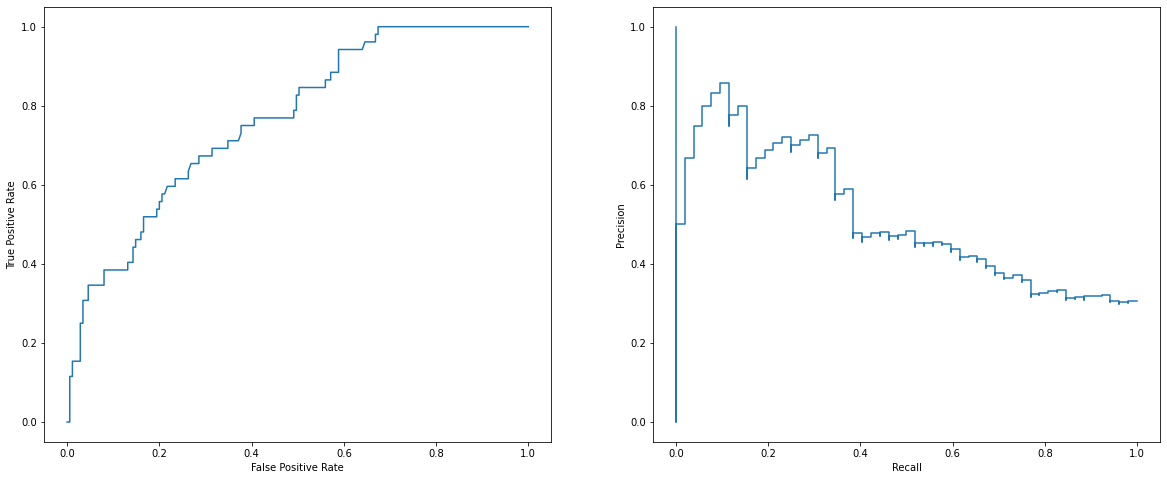

In [151]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_gan_p, tpr_gan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_gan_p = RocCurveDisplay(fpr=fpr_gan_p, tpr=tpr_gan_p)
roc_auc_gan_p = auc(fpr_gan_p, tpr_gan_p)

prec_gan_p, recall_gan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_gan_p = auc(recall_gan_p, prec_gan_p)
pr_display_gan_p = PrecisionRecallDisplay(precision=prec_gan_p, recall=recall_gan_p)

print('ROC AUC:', roc_auc_gan_p)
print('Precision-Recall AUC:', pr_auc_gan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_p.plot(ax=ax1)
pr_display_gan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


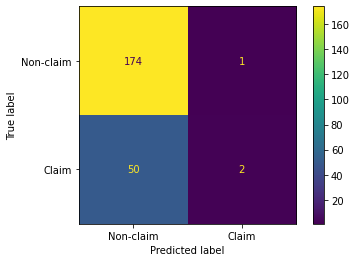

In [152]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_Specie_Facility': 1, 'Full_GGTP': 2, 'SubClass_Shippers_&_Packers': 1, 'Ded_100Pct_USD': 2, 'StatsMinorClassCode_CA': 1, 'Territory_WORLDWIDE': 1}
gain:  {'SubClass_Specie_Facility': 752.247925, 'Full_GGTP': 32.714279149999996, 'SubClass_Shippers_&_Packers': 8.35931396, 'Ded_100Pct_USD': 7.123831249999999, 'StatsMinorClassCode_CA': 19.6356525, 'Territory_WORLDWIDE': 10.5929184}
cover:  {'SubClass_Specie_Facility': 349.0, 'Full_GGTP': 208.25, 'SubClass_Shippers_&_Packers': 114.0, 'Ded_100Pct_USD': 42.0, 'StatsMinorClassCode_CA': 36.0, 'Territory_WORLDWIDE': 28.25}
total_gain:  {'SubClass_Specie_Facility': 752.247925, 'Full_GGTP': 65.42855829999999, 'SubClass_Shippers_&_Packers': 8.35931396, 'Ded_100Pct_USD': 14.24766249

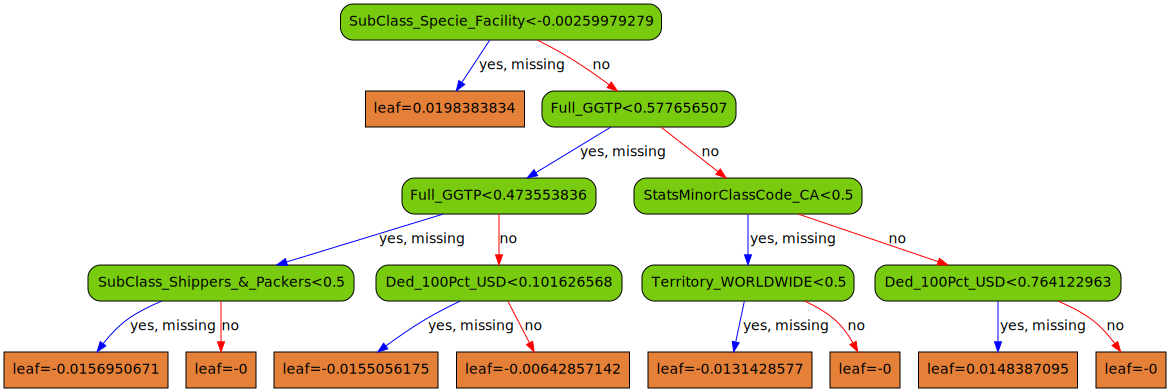

In [153]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                           gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_gan_p, y_gan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [154]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_e, y_gan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [155]:
# print(optimal_params.best_params_)

In [156]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_e, y_gan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.56867
[1]	validation_0-aucpr:0.65584
[2]	validation_0-aucpr:0.65871


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-aucpr:0.69106
[4]	validation_0-aucpr:0.67534
[5]	validation_0-aucpr:0.69402
[6]	validation_0-aucpr:0.72305
[7]	validation_0-aucpr:0.67014
[8]	validation_0-aucpr:0.68927
[9]	validation_0-aucpr:0.68924
[10]	validation_0-aucpr:0.67010
[11]	validation_0-aucpr:0.67873
[12]	validation_0-aucpr:0.67873
[13]	validation_0-aucpr:0.67783
[14]	validation_0-aucpr:0.67395
[15]	validation_0-aucpr:0.67395
[16]	validation_0-aucpr:0.66193


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [157]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.723052
Best iteration: 6


In [158]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 92.31%
ROC AUC: 0.5625
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        83
         1.0       1.00      0.12      0.22         8

    accuracy                           0.92        91
   macro avg       0.96      0.56      0.59        91
weighted avg       0.93      0.92      0.89        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9081325301204819
Precision-Recall AUC: 0.7270913049214935


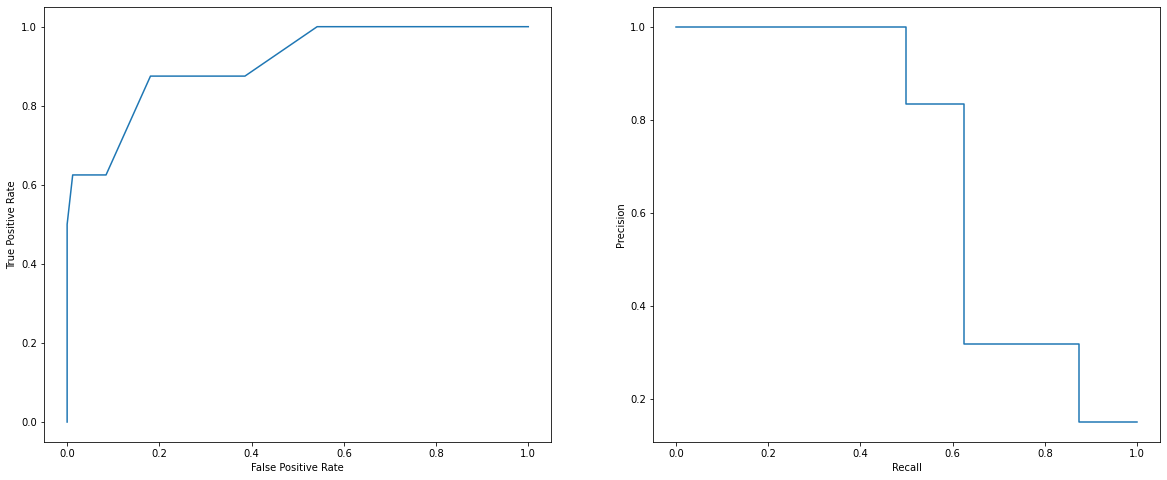

In [159]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_gan_e, tpr_gan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_gan_e = RocCurveDisplay(fpr=fpr_gan_e, tpr=tpr_gan_e)
roc_auc_gan_e = auc(fpr_gan_e, tpr_gan_e)

prec_gan_e, recall_gan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_gan_e = PrecisionRecallDisplay(precision=prec_gan_e, recall=recall_gan_e)
pr_auc_gan_e = auc(recall_gan_e, prec_gan_e)

print('ROC AUC:', roc_auc_gan_e)
print('Precision-Recall AUC:', pr_auc_gan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_e.plot(ax=ax1)
pr_display_gan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


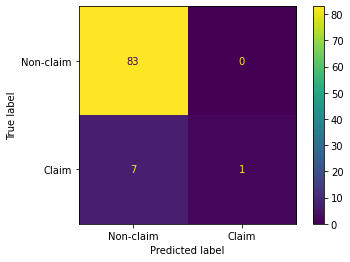

In [160]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_GERMANY': 1, 'Full_GGTP': 1, 'BrokerUltimateName_MARSH': 1, 'Limit_100Pct_USD': 2, 'LeaderLinePct': 1}
gain:  {'Territory_GERMANY': 540.617859, 'Full_GGTP': 13.2028503, 'BrokerUltimateName_MARSH': 5.88949585, 'Limit_100Pct_USD': 1.408960341, 'LeaderLinePct': 8.25465775}
cover:  {'Territory_GERMANY': 166.0, 'Full_GGTP': 91.0, 'BrokerUltimateName_MARSH': 88.25, 'Limit_100Pct_USD': 35.125, 'LeaderLinePct': 20.75}
total_gain:  {'Territory_GERMANY': 540.617859, 'Full_GGTP': 13.2028503, 'BrokerUltimateName_MARSH': 5.88949585, 'Limit_100Pct_USD': 2.817920682, 'LeaderLinePct': 8.25465775}
total_cover:  {'Territory_GERMANY': 166.0, 'Full_GGTP': 91.0, 'BrokerUltimateName_MARSH': 88.25, 'Limit_100Pct_USD': 70.25, 'LeaderLinePct'

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


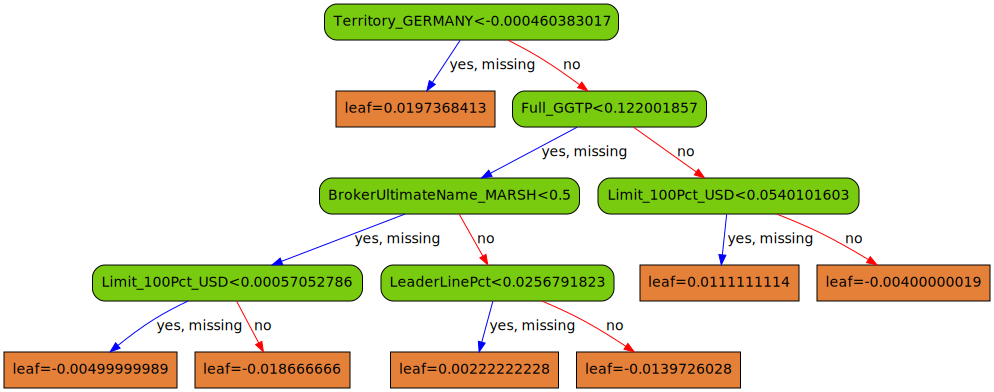

In [161]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1
                           )
clf_xgb.fit(X_gan_e, y_gan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## cGAN

#### Primary Business

In [162]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [163]:
# with_class = True
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [164]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [165]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [166]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1)-1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [167]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [168]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [169]:
# cgan_samples_p = pd.DataFrame(new_g_z, columns=train_p.columns)
# # Saving the dataset
# cgan_samples_p.to_csv('specie_cgan_primary.csv',index=False)

In [170]:
# Loading the dataset
cgan_samples_p = pd.read_csv('../input/project/specie_cgan_primary.csv')
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS,Class
0,0.002880,0.646738,0.316825,0.546591,0.317966,0.000647,-0.000440,0.306136,0.471292,0.002239,...,-0.001504,0.001193,-0.000938,-0.000081,-0.002537,0.002830,0.001959,-0.000522,-0.002220,1.0
1,0.004085,0.587880,0.321721,0.564102,0.371809,0.000813,-0.001224,0.259426,0.542163,0.001912,...,-0.001337,0.001669,-0.001383,-0.000080,-0.002900,0.002771,0.002202,-0.000495,-0.002310,1.0
2,0.001648,0.688793,0.312573,0.536455,0.284743,0.000313,-0.000346,0.335581,0.425983,0.001506,...,-0.000936,0.001481,-0.000940,-0.000234,-0.001631,0.001713,0.001271,-0.000365,-0.001860,1.0
3,0.004026,0.584560,0.321520,0.566280,0.379226,0.000907,-0.001341,0.254506,0.551452,0.002614,...,-0.001564,0.001696,-0.001562,-0.000060,-0.002902,0.002559,0.002300,-0.000432,-0.002574,1.0
4,0.004091,0.587488,0.321757,0.564312,0.372433,0.000828,-0.001244,0.258986,0.542934,0.001945,...,-0.001342,0.001685,-0.001401,-0.000074,-0.002911,0.002766,0.002211,-0.000498,-0.002316,1.0


In [171]:
# # Placing Basis
# column = [i for i in gen_samples_p.columns if 'PlacingBasis' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Subclass
# column = [i for i in gen_samples_p.columns if 'SubClass' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Stats Minor Class Code
# column = [i for i in gen_samples_p.columns if 'StatsMinorClassCode' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Territory
# column = [i for i in gen_samples_p.columns if 'Territory' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

# # Leader Status
# column = [i for i in gen_samples_p.columns if 'LeaderStatus' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples


# # Broker
# column = [i for i in gen_samples_p.columns if 'BrokerUltimateName' in i]
# samples = gen_samples_p[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_p[column] = samples

In [172]:
cgan_samples_p.drop('Class', axis=1, inplace=True)
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,0.002880,0.646738,0.316825,0.546591,0.317966,0.000647,-0.000440,0.306136,0.471292,0.002239,...,0.000856,-0.001504,0.001193,-0.000938,-0.000081,-0.002537,0.002830,0.001959,-0.000522,-0.002220
1,0.004085,0.587880,0.321721,0.564102,0.371809,0.000813,-0.001224,0.259426,0.542163,0.001912,...,0.001132,-0.001337,0.001669,-0.001383,-0.000080,-0.002900,0.002771,0.002202,-0.000495,-0.002310
2,0.001648,0.688793,0.312573,0.536455,0.284743,0.000313,-0.000346,0.335581,0.425983,0.001506,...,0.000799,-0.000936,0.001481,-0.000940,-0.000234,-0.001631,0.001713,0.001271,-0.000365,-0.001860
3,0.004026,0.584560,0.321520,0.566280,0.379226,0.000907,-0.001341,0.254506,0.551452,0.002614,...,0.001104,-0.001564,0.001696,-0.001562,-0.000060,-0.002902,0.002559,0.002300,-0.000432,-0.002574
4,0.004091,0.587488,0.321757,0.564312,0.372433,0.000828,-0.001244,0.258986,0.542934,0.001945,...,0.001139,-0.001342,0.001685,-0.001401,-0.000074,-0.002911,0.002766,0.002211,-0.000498,-0.002316


In [173]:
X_cgan_p = X_train_p.append(cgan_samples_p, ignore_index = True)
X_cgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,0.036671,0.520884,0.306249,0.425889,0.233689,-0.002269,0.061247,0.423868,0.448380,0.507070,...,0.137881,0.037680,0.105897,0.016184,0.010079,0.020721,0.124578,0.010636,0.027057,0.140552
std,0.093464,0.125406,0.073232,0.236213,0.089919,0.050979,0.201314,0.113395,0.156319,0.499507,...,0.344398,0.191239,0.306847,0.127380,0.099671,0.145181,0.329370,0.099618,0.162812,0.348498
min,-0.004644,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.001349,0.000000,0.000000,0.000000,...,0.000000,-0.003030,-0.001476,-0.004058,-0.000303,-0.002995,0.000000,0.000000,-0.002041,-0.003103
25%,0.002315,0.443258,0.272016,0.364945,0.197586,0.000000,-0.000420,0.344669,0.365949,0.001504,...,0.000000,-0.000164,0.000000,-0.000410,0.000000,-0.002050,0.000000,0.000000,-0.000394,-0.001186
50%,0.004162,0.546467,0.310780,0.535446,0.218411,0.000000,0.000000,0.419722,0.432361,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.023158,0.600414,0.334282,0.565203,0.278720,0.000641,0.000000,0.461914,0.539752,1.000000,...,0.001079,0.000000,0.001790,0.000000,0.000000,0.000000,0.001618,0.001544,0.000000,0.000000
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [174]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,...,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.054874,0.469149,0.293514,0.357168,0.209510,-0.003977,0.094861,0.463288,0.460382,0.781215,...,0.212155,0.058564,0.162431,0.025414,0.015470,0.033149,0.191160,0.015470,0.041989,0.217680
std,0.111966,0.120602,0.087138,0.269372,0.095258,0.063262,0.243563,0.116280,0.186778,0.413651,...,0.409060,0.234936,0.369050,0.157467,0.123479,0.179125,0.393432,0.123479,0.200675,0.412897
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002878,0.398031,0.255968,0.000000,0.153605,0.000000,0.000000,0.410269,0.386336,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011553,0.472519,0.299057,0.459332,0.216301,0.000000,0.000000,0.427261,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.042934,0.549160,0.334245,0.549755,0.228840,0.000000,0.000000,0.529260,0.578106,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
ones = np.ones((len(cgan_samples_p),))
one = pd.Series(ones)
y_cgan_p = y_train_p.append(one, ignore_index=True)
# y_cgan_p

#### Excess Business

In [176]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 64 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [177]:
# with_class = True
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [178]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [179]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [180]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual fraud data
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [181]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [182]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [183]:
# cgan_samples_e = pd.DataFrame(new_g_z, columns=train_e.columns)
# # Saving the dataset
# cgan_samples_e.to_csv('specie_cgan_excess.csv',index=False)

In [184]:
# Loading the dataset
cgan_samples_e = pd.read_csv('../input/project/specie_cgan_excess.csv')
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,Class
0,0.397296,0.056829,0.008443,0.106959,0.641794,0.003254,-0.005404,0.111372,0.023853,0.005112,...,0.010501,0.005725,-0.001145,0.001200,0.007669,0.004340,-0.004735,0.002366,-0.003057,1.0
1,0.393684,0.060542,0.007651,0.108956,0.640537,0.003345,-0.007258,0.108496,0.023506,0.005694,...,0.009708,0.005078,-0.000678,0.000237,0.010242,0.006376,-0.005583,0.002389,-0.002399,1.0
2,0.426811,0.051449,0.005868,0.114936,0.683165,0.004305,-0.004560,0.122815,0.021190,0.003419,...,0.011762,0.005846,-0.001932,0.000195,0.008483,0.004155,-0.005548,0.001356,-0.002368,1.0
3,0.402262,0.067617,0.006259,0.110485,0.657614,0.000104,-0.006881,0.112091,0.032221,0.006752,...,0.005215,0.012484,-0.003450,-0.001806,0.008291,0.001546,0.000199,-0.006339,-0.002301,1.0
4,0.418087,0.048221,0.005743,0.113111,0.669351,0.005058,-0.003219,0.119265,0.024522,0.006200,...,0.010468,0.008498,-0.004297,0.000079,0.010819,0.003702,-0.003291,0.003260,-0.002972,1.0


In [185]:
# # Placing Basis
# column = [i for i in gen_samples_e.columns if 'PlacingBasis' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples

# # Subclass
# column = [i for i in gen_samples_e.columns if 'SubClass' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples

# # Stats Minor Class Code
# column = [i for i in gen_samples_e.columns if 'StatsMinorClassCode' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples

# # Territory
# column = [i for i in gen_samples_e.columns if 'Territory' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples

# # Leader Status
# column = [i for i in gen_samples_e.columns if 'LeaderStatus' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples


# # Broker
# column = [i for i in gen_samples_e.columns if 'BrokerUltimateName' in i]
# samples = gen_samples_e[column]
# max_column = samples.idxmax(axis=1)
# for col in samples.columns:
#     samples[col].values[:] = 0
# for i in range(len(samples)):
#     samples.iloc[i][max_column[i]] = 1
# gen_samples_e[column] = samples

In [186]:
cgan_samples_e.drop('Class', axis=1, inplace=True)
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.397296,0.056829,0.008443,0.106959,0.641794,0.003254,-0.005404,0.111372,0.023853,0.005112,...,0.977230,0.010501,0.005725,-0.001145,0.001200,0.007669,0.004340,-0.004735,0.002366,-0.003057
1,0.393684,0.060542,0.007651,0.108956,0.640537,0.003345,-0.007258,0.108496,0.023506,0.005694,...,0.967400,0.009708,0.005078,-0.000678,0.000237,0.010242,0.006376,-0.005583,0.002389,-0.002399
2,0.426811,0.051449,0.005868,0.114936,0.683165,0.004305,-0.004560,0.122815,0.021190,0.003419,...,1.045985,0.011762,0.005846,-0.001932,0.000195,0.008483,0.004155,-0.005548,0.001356,-0.002368
3,0.402262,0.067617,0.006259,0.110485,0.657614,0.000104,-0.006881,0.112091,0.032221,0.006752,...,0.988364,0.005215,0.012484,-0.003450,-0.001806,0.008291,0.001546,0.000199,-0.006339,-0.002301
4,0.418087,0.048221,0.005743,0.113111,0.669351,0.005058,-0.003219,0.119265,0.024522,0.006200,...,1.019808,0.010468,0.008498,-0.004297,0.000079,0.010819,0.003702,-0.003291,0.003260,-0.002972


In [187]:
X_cgan_e = X_train_e.append(cgan_samples_e, ignore_index = True)
X_cgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,...,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.281071,0.043587,0.036668,0.108660,0.680426,-0.001161,0.071713,0.101331,0.205258,0.019972,...,0.961642,0.040810,0.043632,0.041213,0.009000,0.026420,0.032071,0.127457,0.005367,0.128320
std,0.175982,0.055914,0.057137,0.105747,0.075990,0.025947,0.225645,0.068239,0.242227,0.063724,...,0.187240,0.185959,0.197077,0.201332,0.094711,0.148186,0.170723,0.336831,0.067075,0.336494
min,0.000000,0.000000,-0.005908,0.000001,0.205000,-0.200000,-0.013367,0.000000,0.000000,-0.002980,...,0.000000,0.000000,-0.003263,-0.007288,-0.005777,0.000000,-0.004290,-0.012302,-0.013002,-0.008514
25%,0.102818,0.011685,0.006422,0.044516,0.650000,0.000000,-0.006643,0.064238,0.022998,0.000000,...,0.991541,0.000000,0.000000,-0.001800,0.000000,0.000000,0.000000,-0.004666,0.000000,-0.002414
50%,0.384433,0.049434,0.015430,0.108313,0.658906,0.000000,0.000000,0.108329,0.028109,0.002499,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.407555,0.057557,0.051759,0.113922,0.750000,0.002941,0.000000,0.116154,0.413922,0.005525,...,1.000000,0.010522,0.006658,0.000000,0.000000,0.008371,0.004258,0.000000,0.001811,0.000000
max,1.000000,0.712532,1.000000,1.000000,0.900000,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.093918,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.181911,0.026712,0.061285,0.108199,0.700350,-0.004566,0.136421,0.091782,0.353522,0.032548,...,0.934066,0.065934,0.074176,0.076923,0.016484,0.041209,0.054945,0.236264,0.008242,0.236264
std,0.184121,0.055609,0.067703,0.142676,0.097118,0.034634,0.289307,0.090924,0.241497,0.084037,...,0.248508,0.248508,0.262418,0.266836,0.127501,0.199046,0.228187,0.425371,0.090534,0.425371
min,0.000000,0.000000,0.000000,0.000001,0.205000,-0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044925,0.005374,0.028501,0.006249,0.650000,0.000000,0.000000,0.050415,0.103481,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.110964,0.012898,0.044007,0.044521,0.750000,0.000000,0.000000,0.065443,0.376294,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277658,0.026079,0.075018,0.162982,0.750000,0.000000,0.000000,0.107250,0.564440,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.712532,1.000000,1.000000,0.900000,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [189]:
ones = np.ones((len(cgan_samples_e),))
one = pd.Series(ones)
y_cgan_e = y_train_e.append(one, ignore_index=True)
# y_cgan_e

### XGBoost (cGAN)

#### Primary Business

In [190]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_p, y_cgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [191]:
# print(optimal_params.best_params_)

In [192]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_p, y_cgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.39034
[1]	validation_0-aucpr:0.42909
[2]	validation_0-aucpr:0.42795
[3]	validation_0-aucpr:0.40219
[4]	validation_0-aucpr:0.42941
[5]	validation_0-aucpr:0.43562
[6]	validation_0-aucpr:0.44769
[7]	validation_0-aucpr:0.46080


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.46130
[9]	validation_0-aucpr:0.47704
[10]	validation_0-aucpr:0.46118
[11]	validation_0-aucpr:0.46551
[12]	validation_0-aucpr:0.47240
[13]	validation_0-aucpr:0.46543
[14]	validation_0-aucpr:0.46442
[15]	validation_0-aucpr:0.46543
[16]	validation_0-aucpr:0.45986
[17]	validation_0-aucpr:0.46500
[18]	validation_0-aucpr:0.47424


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [193]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.477038
Best iteration: 9


In [194]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 77.97%
ROC AUC: 0.5327472527472527
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       175
         1.0       0.67      0.08      0.14        52

    accuracy                           0.78       227
   macro avg       0.72      0.53      0.51       227
weighted avg       0.76      0.78      0.71       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7517032967032967
Precision-Recall AUC: 0.47688056305949683


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


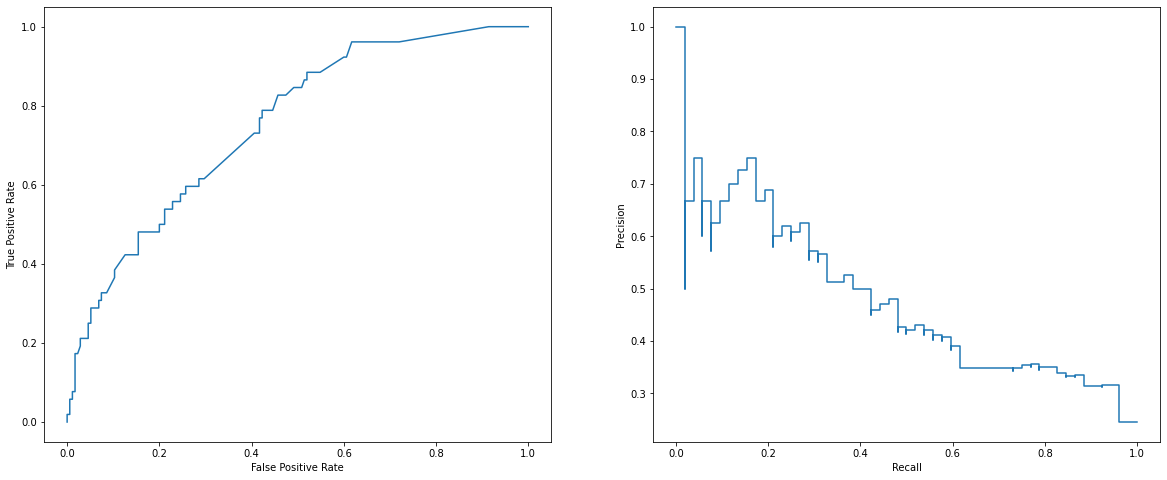

In [195]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_cgan_p, tpr_cgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_cgan_p = RocCurveDisplay(fpr=fpr_cgan_p, tpr=tpr_cgan_p)
roc_auc_cgan_p = auc(fpr_cgan_p, tpr_cgan_p)

prec_cgan_p, recall_cgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_cgan_p = PrecisionRecallDisplay(precision=prec_cgan_p, recall=recall_cgan_p)
pr_auc_cgan_p = auc(recall_cgan_p, prec_cgan_p)

print('ROC AUC:', roc_auc_cgan_p)
print('Precision-Recall AUC:', pr_auc_cgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_p.plot(ax=ax1)
pr_display_cgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


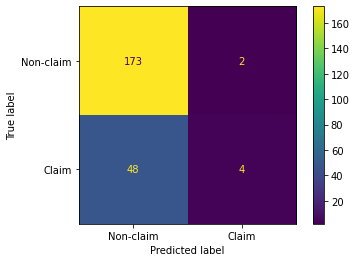

In [196]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_Specie_Facility': 1, 'Full_GGTP': 2, 'SubClass_Shippers_&_Packers': 1, 'Ded_100Pct_USD': 2, 'StatsMinorClassCode_CA': 1, 'Territory_WORLDWIDE': 1, 'LeaderLinePct': 1}
gain:  {'SubClass_Specie_Facility': 753.251099, 'Full_GGTP': 32.9959564, 'SubClass_Shippers_&_Packers': 8.44439697, 'Ded_100Pct_USD': 7.5291314, 'StatsMinorClassCode_CA': 19.6356525, 'Territory_WORLDWIDE': 10.5929184, 'LeaderLinePct': 0.460083008}
cover:  {'SubClass_Specie_Facility': 349.0, 'Full_GGTP': 207.5, 'SubClass_Shippers_&_Packers': 113.75, 'Ded_100Pct_USD': 41.75, 'StatsMinorClassCode_CA': 36.0, 'Territory_WORLDWIDE': 28.25, 'LeaderLinePct': 123.5}
total_gain:  {'SubClass_Specie_Facility': 753.251099, 'Full_GGTP': 65.9919128, 'SubClass_Shippers_&

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


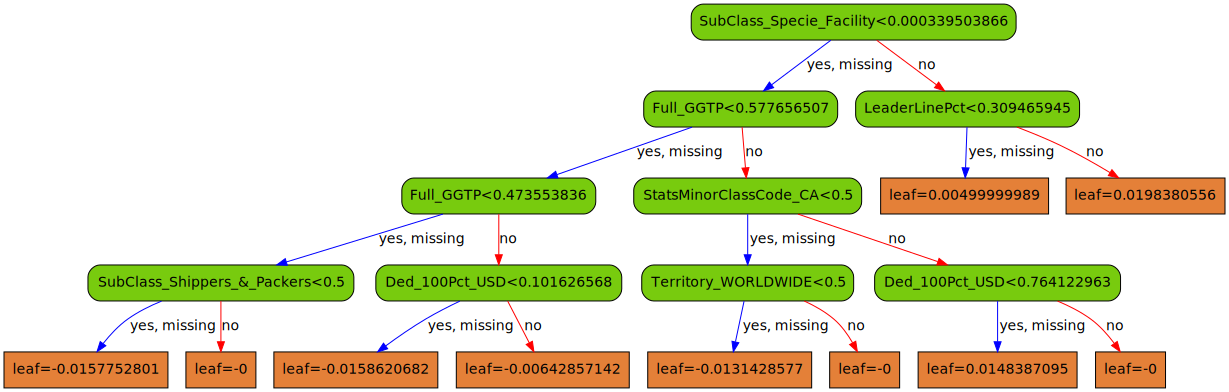

In [197]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_p, y_cgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [198]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_e, y_cgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [199]:
# print(optimal_params.best_params_)

In [200]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_e, y_cgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.34461
[1]	validation_0-aucpr:0.62121


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.59638
[3]	validation_0-aucpr:0.65178
[4]	validation_0-aucpr:0.55256
[5]	validation_0-aucpr:0.57296
[6]	validation_0-aucpr:0.48889
[7]	validation_0-aucpr:0.50214
[8]	validation_0-aucpr:0.58794
[9]	validation_0-aucpr:0.58475
[10]	validation_0-aucpr:0.56518
[11]	validation_0-aucpr:0.55095
[12]	validation_0-aucpr:0.63318


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [201]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.651784
Best iteration: 3


In [202]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 94.51%
ROC AUC: 0.7439759036144579
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        83
         1.0       0.80      0.50      0.62         8

    accuracy                           0.95        91
   macro avg       0.88      0.74      0.79        91
weighted avg       0.94      0.95      0.94        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9231927710843374
Precision-Recall AUC: 0.6522190995981318


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


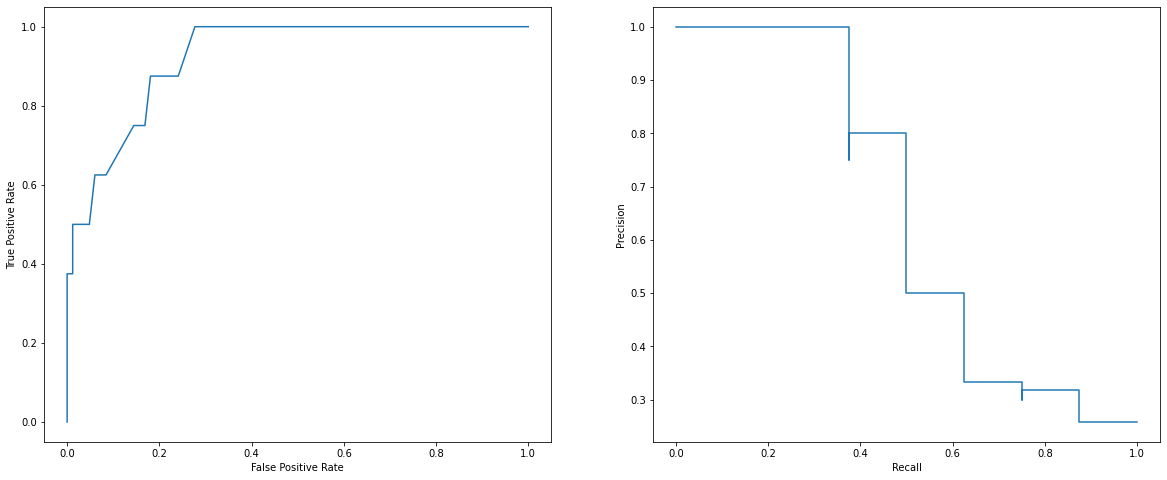

In [203]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_cgan_e, tpr_cgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_cgan_e = RocCurveDisplay(fpr=fpr_cgan_e, tpr=tpr_cgan_e)
roc_auc_cgan_e = auc(fpr_cgan_e, tpr_cgan_e)

prec_cgan_e, recall_cgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_cgan_e = PrecisionRecallDisplay(precision=prec_cgan_e, recall=recall_cgan_e)
pr_auc_cgan_e = auc(recall_cgan_e, prec_cgan_e)

print('ROC AUC:', roc_auc_cgan_e)
print('Precision-Recall AUC:', pr_auc_cgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_e.plot(ax=ax1)
pr_display_cgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


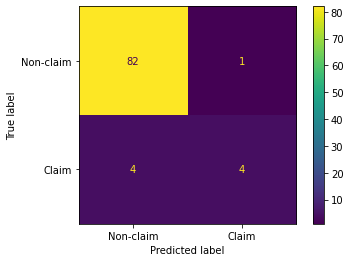

In [204]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_ATM': 1, 'Territory_WORLDWIDE': 1, 'SubClass_Corporate_Collection': 1, 'SubClass_Retail': 1, 'Full_GGTP': 1, 'LeaderLinePct': 1, 'BrokerUltimateName_MARSH': 1, 'Limit_100Pct_USD': 1}
gain:  {'SubClass_ATM': 697.382507, 'Territory_WORLDWIDE': 44.0217285, 'SubClass_Corporate_Collection': 12.8681488, 'SubClass_Retail': 7.49414062, 'Full_GGTP': 22.8749104, 'LeaderLinePct': 17.3881893, 'BrokerUltimateName_MARSH': 1.10489941, 'Limit_100Pct_USD': 0.478027344}
cover:  {'SubClass_ATM': 332.0, 'Territory_WORLDWIDE': 106.0, 'SubClass_Corporate_Collection': 56.75, 'SubClass_Retail': 54.5, 'Full_GGTP': 49.25, 'LeaderLinePct': 43.25, 'BrokerUltimateName_MARSH': 6.0, 'Limit_100Pct_USD': 226.0}
total_gain:  {'SubClass_ATM': 697.382507

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


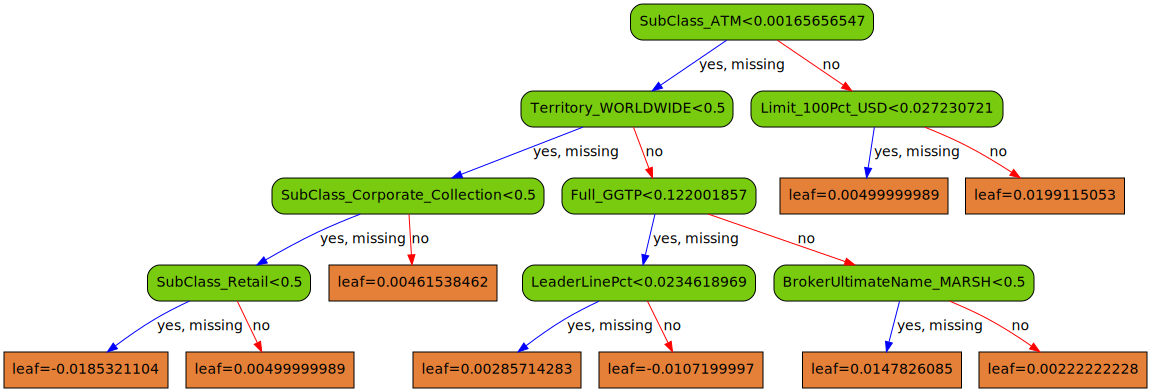

In [205]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_e, y_cgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## WGAN

In [206]:
def critic_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dense(1)(x)
    return x

In [207]:
def em_loss(y_coefficients, y_pred):
    # define earth mover distance (wasserstein loss)
    # literally the weighted average of the critic network output
    # this is defined separately so it can be fed as a loss function to the optimizer in the WGANs
    return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

In [208]:
def train_discriminator_step_p(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_p, batch_size, seed=seed),
            _labels: get_data_batch(train_p, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_p, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

In [209]:
def train_discriminator_step_e(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_e, batch_size, seed=seed),
            _labels: get_data_batch(train_e, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_e, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

#### Primary Business

In [210]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS,Class
46,0.003643,0.316038,0.334282,0.000000,0.153605,0.00,0.000000,0.530972,0.424690,1,...,0,0,0,0,0,0,0,0,0,0.0
59,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,1,1.0
828,0.010285,0.358672,0.299057,0.635174,0.216301,0.00,0.000000,0.445331,0.396154,0,...,0,0,0,0,0,0,0,0,0,0.0
100,0.025733,0.543195,0.237586,0.675864,0.122257,-0.05,0.000000,0.618436,0.885705,1,...,0,0,0,0,0,0,0,0,0,0.0
760,0.007505,0.519434,0.286257,0.506829,0.156677,0.10,0.749134,0.524216,0.627966,1,...,0,0,0,0,0,1,0,0,0,0.0


In [211]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,0,1
1,0.020109,0.436800,0.255968,0.000000,0.184953,0.00,0.000000,0.494795,0.363324,0,...,0,0,0,0,0,0,0,0,0,1
2,0.025733,0.452556,0.334282,0.000000,0.166082,0.00,0.704578,0.506837,0.081038,1,...,0,0,1,0,0,0,0,0,0,0
3,0.010285,0.577677,0.334245,0.564498,0.278997,0.00,0.000000,0.347922,0.463044,1,...,0,0,0,0,0,0,1,0,0,0
4,0.031799,0.794542,0.299057,0.512429,0.291536,0.75,0.000000,0.349847,0.186895,1,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [213]:
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [214]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [215]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [216]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [217]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [218]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [219]:
# wgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_p.to_csv('specie_wgan_primary.csv',index=False)

In [220]:
# Loading the dataset
wgan_samples_p = pd.read_csv('../input/project/specie_wgan_primary.csv')
wgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,0.139736,0.473824,0.220601,0.017750,0.195196,-0.001367,0.115181,0.373717,0.311400,1.014308,...,-0.000618,0.009794,-0.001787,0.061422,-0.048661,-0.058413,0.015119,0.032397,-0.006028,0.618953
1,0.089532,0.725417,0.244353,0.632246,0.278602,0.040259,0.024065,0.469782,0.379059,-0.005794,...,-0.078682,-0.032706,0.024205,0.017443,0.033010,0.519314,-0.037255,0.016419,0.024087,0.541499
2,0.073516,0.340763,0.222203,0.436754,0.056316,0.062234,0.284770,0.591687,0.650771,1.115588,...,1.061098,0.160831,-0.047577,-0.001298,-0.014652,-0.099205,0.047110,-0.031284,-0.044731,0.223144
3,0.035141,0.669971,0.270372,0.584684,0.259435,-0.077410,-0.067514,0.451238,0.189915,1.076212,...,-0.031817,0.013239,0.981014,-0.048635,-0.007866,-0.019245,-0.019153,0.015078,-0.023883,0.034262
4,0.317235,0.563157,0.242507,0.403793,0.125850,0.001716,-0.030980,0.515433,0.286761,0.959549,...,0.049286,0.006418,0.797738,-0.026916,0.032138,0.028013,-0.065461,0.017235,-0.078348,0.182583


In [221]:
X_wgan_p = X_train_p.append(wgan_samples_p, ignore_index = True)
X_wgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,0.051356,0.492632,0.290550,0.381205,0.219660,-0.002569,0.110323,0.451642,0.443529,0.776574,...,0.175182,0.052503,0.189026,0.021837,0.011292,0.037146,0.165676,0.012237,0.037080,0.236118
std,0.103546,0.118416,0.079809,0.248542,0.111687,0.064006,0.241662,0.118006,0.180745,0.403363,...,0.377620,0.206710,0.375260,0.150553,0.102736,0.188571,0.357838,0.102098,0.192120,0.412338
min,-0.159587,0.000000,0.000000,-0.678309,-0.019928,-0.250000,-0.303241,-0.154673,-0.116966,-0.498576,...,-0.258063,-0.269338,-0.224630,-0.215682,-0.120748,-0.162331,-0.386574,-0.113349,-0.267091,-0.254884
25%,0.002675,0.421676,0.251002,0.169788,0.153605,-0.013388,0.000000,0.389153,0.353821,0.791926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.016588,0.500229,0.299057,0.459332,0.216301,0.000000,0.000000,0.433466,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.051480,0.567632,0.334036,0.552677,0.247649,0.000000,0.097659,0.529257,0.553364,1.000000,...,0.017251,0.000020,0.065401,0.000000,0.000000,0.000000,0.046417,0.000000,0.000000,0.296661
max,1.000000,0.906009,1.000000,1.000000,1.060759,0.850000,1.224371,1.000000,1.000000,1.217418,...,1.107771,1.249819,1.423220,1.542170,1.000000,1.604290,1.227907,1.000000,1.415237,1.284322


In [222]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,...,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.054874,0.469149,0.293514,0.357168,0.209510,-0.003977,0.094861,0.463288,0.460382,0.781215,...,0.212155,0.058564,0.162431,0.025414,0.015470,0.033149,0.191160,0.015470,0.041989,0.217680
std,0.111966,0.120602,0.087138,0.269372,0.095258,0.063262,0.243563,0.116280,0.186778,0.413651,...,0.409060,0.234936,0.369050,0.157467,0.123479,0.179125,0.393432,0.123479,0.200675,0.412897
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002878,0.398031,0.255968,0.000000,0.153605,0.000000,0.000000,0.410269,0.386336,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011553,0.472519,0.299057,0.459332,0.216301,0.000000,0.000000,0.427261,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.042934,0.549160,0.334245,0.549755,0.228840,0.000000,0.000000,0.529260,0.578106,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [223]:
ones = np.ones((len(wgan_samples_p),))
one = pd.Series(ones)
y_wgan_p = y_train_p.append(one, ignore_index=True)
# y_wgan_p

#### Excess Business

In [224]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,Class
135,0.444353,0.022647,0.020748,0.044516,0.65,0.0,0.0,0.117284,0.511007,0.0,...,0,0,0,0,0,0,1,0,0,0.0
292,0.019282,0.000692,0.218997,0.244842,0.84,0.0,0.0,0.025610,0.517404,0.0,...,1,0,0,0,0,0,0,0,1,0.0
418,0.006780,0.001924,0.100850,0.002225,0.75,0.0,0.0,0.042955,0.564440,0.0,...,0,0,0,0,0,1,0,0,0,0.0
127,0.222094,0.052329,0.036254,0.267100,0.85,0.0,0.0,0.029610,0.531515,0.0,...,0,0,0,0,0,0,1,0,0,1.0
226,0.138746,0.019172,0.031602,0.055645,0.75,0.0,0.0,0.065443,0.103481,0.0,...,0,0,0,0,1,0,0,0,0,0.0


In [225]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.222094,0.052329,0.036254,0.267100,0.850000,0.000,0.0,0.029610,0.531515,0.0,...,1,0,0,0,0,0,0,1,0,0
1,0.139024,0.014540,0.009870,0.380785,0.760449,0.084,0.0,0.029609,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0
2,0.027617,0.712532,0.091453,0.003894,0.750000,0.000,0.0,0.064238,0.113082,0.0,...,1,0,0,0,0,0,0,0,0,0
3,0.000195,0.008375,0.100850,0.000002,0.750000,0.000,0.0,0.065443,0.517403,0.0,...,1,0,0,0,1,0,0,0,0,0
4,0.102818,0.017770,0.019198,0.013750,0.750000,0.000,0.0,0.050415,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0


In [226]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 64 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [227]:
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [228]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [229]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [230]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [231]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [232]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [233]:
# wgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_e.to_csv('specie_wgan_excess.csv',index=False)

In [234]:
# Loading the dataset
wgan_samples_e = pd.read_csv('../input/project/specie_wgan_excess.csv')
wgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.088457,-0.018186,0.020346,-0.046805,0.792901,-0.026087,0.038240,0.039075,0.332025,-0.000020,...,1.024199,-0.008291,0.001001,0.019571,0.002405,-0.015404,-0.028254,1.031383,0.005263,-0.003600
1,0.030883,0.402288,0.089818,0.022426,0.760958,-0.003301,0.852155,0.054149,0.127758,0.158861,...,0.976525,-0.008879,-0.004042,-0.005726,0.013967,-0.006049,0.015119,0.022833,-0.012055,0.010232
2,0.227409,0.039523,0.019180,0.215858,0.615331,-0.050336,0.009131,0.142339,0.137346,-0.010765,...,1.088360,-0.008151,0.012828,-0.001716,0.024999,-0.021796,-0.005138,1.042342,0.015122,-0.026019
3,0.095607,0.027001,0.118269,0.089104,0.700934,-0.063699,-0.022577,0.055652,0.530319,0.018185,...,1.005426,-0.012284,0.000011,-0.010145,0.026896,-0.004332,-0.025645,0.992285,-0.003798,-0.044693
4,0.104981,0.594940,0.057460,0.001655,0.712865,-0.028555,0.022520,0.067211,0.113551,-0.030081,...,0.970553,-0.002141,-0.065467,0.017533,0.030594,0.012482,0.039903,0.002284,-0.018047,-0.020625


In [235]:
X_wgan_e = X_train_e.append(wgan_samples_e, ignore_index = True)
X_wgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,...,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.188624,0.061017,0.062491,0.088656,0.715480,-0.006432,0.150161,0.079764,0.338775,0.035672,...,0.947197,0.047781,0.057855,0.039229,0.026646,0.023105,0.048486,0.382575,0.018594,0.156731
std,0.207593,0.115516,0.059775,0.124316,0.087748,0.035629,0.294545,0.076997,0.228405,0.081254,...,0.209239,0.210019,0.220149,0.202284,0.146776,0.149195,0.207537,0.464330,0.126962,0.353835
min,-0.147021,-0.051898,-0.086931,-0.133645,0.205000,-0.200000,-0.192081,-0.070890,-0.126224,-0.093041,...,-0.001764,-0.120141,-0.078944,-0.083418,-0.112427,-0.073756,-0.084785,-0.107087,-0.210660,-0.102363
25%,0.043118,0.007804,0.028501,0.005563,0.650000,-0.016762,0.000000,0.042958,0.154494,0.000000,...,0.984692,-0.002199,0.000000,-0.002530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.109698,0.020864,0.052122,0.046148,0.738105,0.000000,0.000000,0.065441,0.330244,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027561,0.000000,0.000000
75%,0.293490,0.056213,0.084068,0.127362,0.750002,0.000000,0.092492,0.105400,0.564440,0.026659,...,1.000000,0.000000,0.002972,0.000000,0.005483,0.001390,0.000000,0.989752,0.000000,0.034294
max,1.304337,0.977763,1.000000,1.000000,1.067228,0.200000,0.961652,1.000000,1.000000,0.932198,...,1.163164,1.023098,1.000000,1.000000,1.325892,1.000000,1.327122,1.360385,1.112392,1.509876


In [236]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.181911,0.026712,0.061285,0.108199,0.700350,-0.004566,0.136421,0.091782,0.353522,0.032548,...,0.934066,0.065934,0.074176,0.076923,0.016484,0.041209,0.054945,0.236264,0.008242,0.236264
std,0.184121,0.055609,0.067703,0.142676,0.097118,0.034634,0.289307,0.090924,0.241497,0.084037,...,0.248508,0.248508,0.262418,0.266836,0.127501,0.199046,0.228187,0.425371,0.090534,0.425371
min,0.000000,0.000000,0.000000,0.000001,0.205000,-0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044925,0.005374,0.028501,0.006249,0.650000,0.000000,0.000000,0.050415,0.103481,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.110964,0.012898,0.044007,0.044521,0.750000,0.000000,0.000000,0.065443,0.376294,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277658,0.026079,0.075018,0.162982,0.750000,0.000000,0.000000,0.107250,0.564440,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.712532,1.000000,1.000000,0.900000,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [237]:
ones = np.ones((len(wgan_samples_e),))
one = pd.Series(ones)
y_wgan_e = y_train_e.append(one, ignore_index=True)
# y_wgan_e

### XGBoost (WGAN)

#### Primary Business

In [238]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_p, y_wgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [239]:
# print(optimal_params.best_params_)

In [240]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_p, y_wgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.34762
[1]	validation_0-aucpr:0.33482
[2]	validation_0-aucpr:0.35560
[3]	validation_0-aucpr:0.35354
[4]	validation_0-aucpr:0.39768
[5]	validation_0-aucpr:0.39647
[6]	validation_0-aucpr:0.40752
[7]	validation_0-aucpr:0.42295


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.41017
[9]	validation_0-aucpr:0.42717
[10]	validation_0-aucpr:0.43371
[11]	validation_0-aucpr:0.43044
[12]	validation_0-aucpr:0.43615
[13]	validation_0-aucpr:0.43518
[14]	validation_0-aucpr:0.44278
[15]	validation_0-aucpr:0.44628
[16]	validation_0-aucpr:0.45265
[17]	validation_0-aucpr:0.45299
[18]	validation_0-aucpr:0.45953
[19]	validation_0-aucpr:0.45482
[20]	validation_0-aucpr:0.45765
[21]	validation_0-aucpr:0.45533
[22]	validation_0-aucpr:0.46404
[23]	validation_0-aucpr:0.45077
[24]	validation_0-aucpr:0.46018
[25]	validation_0-aucpr:0.45190
[26]	validation_0-aucpr:0.46060
[27]	validation_0-aucpr:0.44807
[28]	validation_0-aucpr:0.44827
[29]	validation_0-aucpr:0.44790
[30]	validation_0-aucpr:0.45491
[31]	validation_0-aucpr:0.45964
[32]	validation_0-aucpr:0.45870


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [241]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.46404
Best iteration: 22


In [242]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 77.53%
ROC AUC: 0.5163736263736265
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       175
         1.0       0.67      0.04      0.07        52

    accuracy                           0.78       227
   macro avg       0.72      0.52      0.47       227
weighted avg       0.75      0.78      0.69       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.749945054945055
Precision-Recall AUC: 0.4636556563761973


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


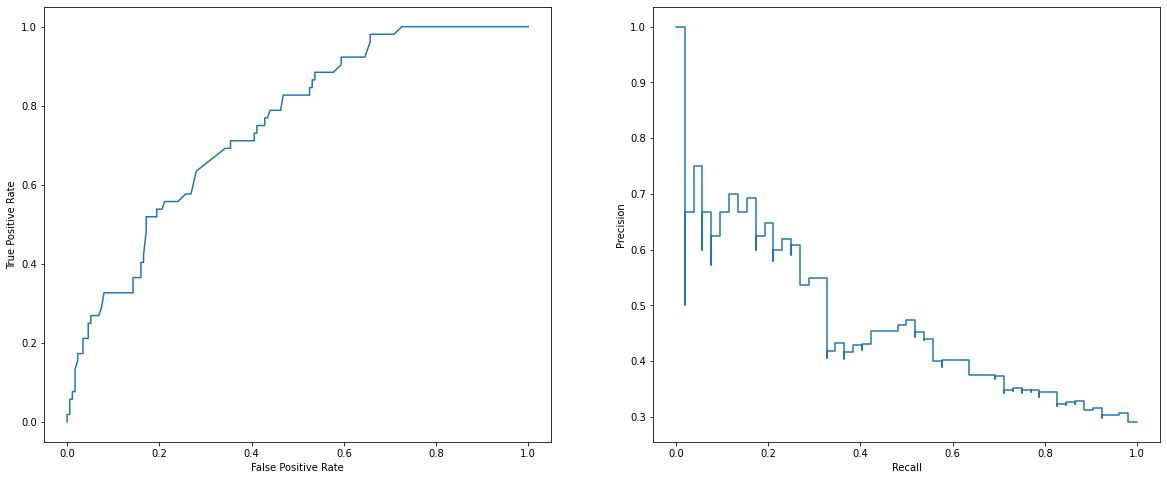

In [243]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wgan_p, tpr_wgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wgan_p = RocCurveDisplay(fpr=fpr_wgan_p, tpr=tpr_wgan_p)
roc_auc_wgan_p = auc(fpr_wgan_p, tpr_wgan_p)

prec_wgan_p, recall_wgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wgan_p = PrecisionRecallDisplay(precision=prec_wgan_p, recall=recall_wgan_p)
pr_auc_wgan_p = auc(recall_wgan_p, prec_wgan_p)

print('ROC AUC:', roc_auc_wgan_p)
print('Precision-Recall AUC:', pr_auc_wgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_p.plot(ax=ax1)
pr_display_wgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


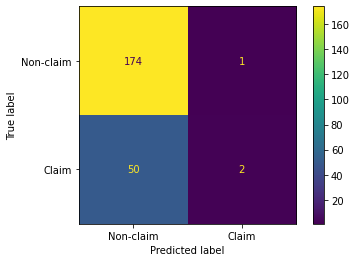

In [244]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_Mining': 3, 'Full_GGTP': 2, 'StatsMinorClassCode_CA': 1, 'Limit_100Pct_USD': 1}
gain:  {'SubClass_Mining': 246.73406976666664, 'Full_GGTP': 33.77700805, 'StatsMinorClassCode_CA': 18.6227779, 'Limit_100Pct_USD': 7.96866417}
cover:  {'SubClass_Mining': 224.08333333333334, 'Full_GGTP': 201.875, 'StatsMinorClassCode_CA': 34.75, 'Limit_100Pct_USD': 7.75}
total_gain:  {'SubClass_Mining': 740.2022092999999, 'Full_GGTP': 67.5540161, 'StatsMinorClassCode_CA': 18.6227779, 'Limit_100Pct_USD': 7.96866417}
total_cover:  {'SubClass_Mining': 672.25, 'Full_GGTP': 403.75, 'StatsMinorClassCode_CA': 34.75, 'Limit_100Pct_USD': 7.75}


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


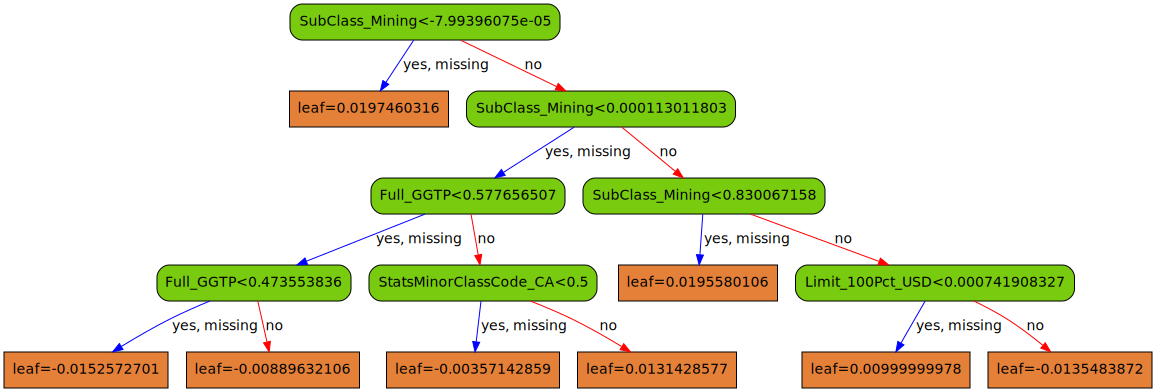

In [245]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_p, y_wgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [246]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_e, y_wgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [247]:
# print(optimal_params.best_params_)

In [248]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.05,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_e, y_wgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.39738
[1]	validation_0-aucpr:0.44506
[2]	validation_0-aucpr:0.48308


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-aucpr:0.65336
[4]	validation_0-aucpr:0.68661
[5]	validation_0-aucpr:0.58316
[6]	validation_0-aucpr:0.58022
[7]	validation_0-aucpr:0.59285
[8]	validation_0-aucpr:0.60241
[9]	validation_0-aucpr:0.58821
[10]	validation_0-aucpr:0.65833
[11]	validation_0-aucpr:0.57729
[12]	validation_0-aucpr:0.65521
[13]	validation_0-aucpr:0.65266


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [249]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.686605
Best iteration: 4


In [250]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 94.51%
ROC AUC: 0.6875
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        83
         1.0       1.00      0.38      0.55         8

    accuracy                           0.95        91
   macro avg       0.97      0.69      0.76        91
weighted avg       0.95      0.95      0.93        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9480421686746988
Precision-Recall AUC: 0.692834595959596


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


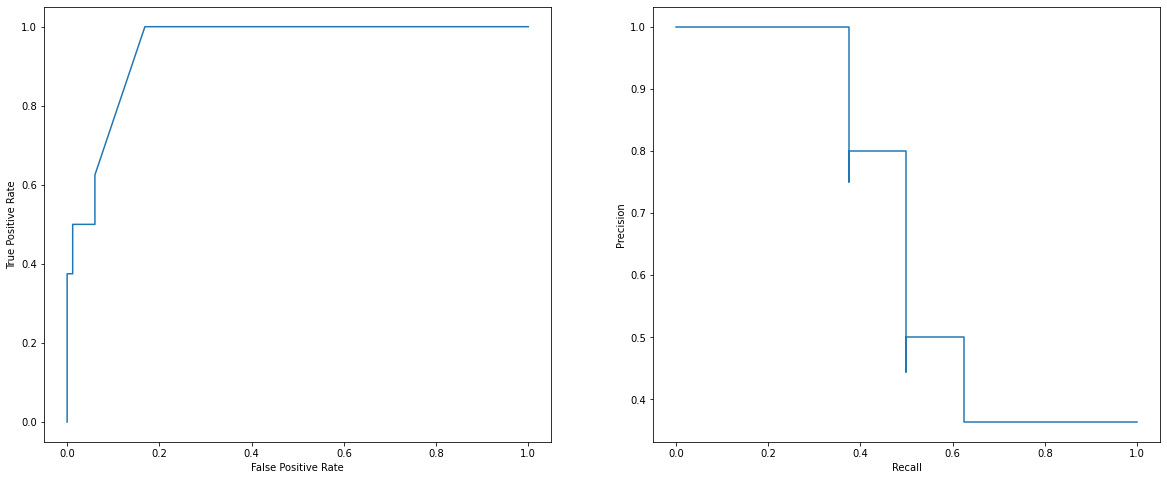

In [251]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wgan_e, tpr_wgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wgan_e = RocCurveDisplay(fpr=fpr_wgan_e, tpr=tpr_wgan_e)
roc_auc_wgan_e = auc(fpr_wgan_e, tpr_wgan_e)

prec_wgan_e, recall_wgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wgan_e = PrecisionRecallDisplay(precision=prec_wgan_e, recall=recall_wgan_e)
pr_auc_wgan_e = auc(recall_wgan_e, prec_wgan_e)

print('ROC AUC:', roc_auc_wgan_e)
print('Precision-Recall AUC:', pr_auc_wgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_e.plot(ax=ax1)
pr_display_wgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


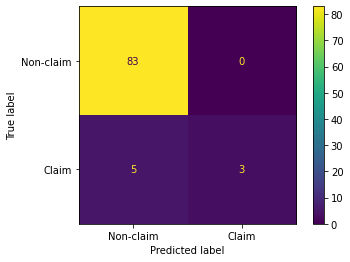

In [252]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_WORLDWIDE': 1, 'SubClass_Corporate_Collection': 1, 'BrokerUltimateName_THB_GROUP': 1, 'BrokerUltimateName_MARSH': 4, 'Full_GGTP': 1, 'Limit_100Pct_USD': 1, 'XS_100Pct_USD': 1, 'LeaderLinePct': 1, 'BrokerFeePct': 1}
gain:  {'Territory_WORLDWIDE': 354.297821, 'SubClass_Corporate_Collection': 36.444809, 'BrokerUltimateName_THB_GROUP': 2.4854126, 'BrokerUltimateName_MARSH': 44.855899799999996, 'Full_GGTP': 13.7897301, 'Limit_100Pct_USD': 3.63096809, 'XS_100Pct_USD': 2.36918259, 'LeaderLinePct': 11.4669838, 'BrokerFeePct': 4.37157917}
cover:  {'Territory_WORLDWIDE': 249.0, 'SubClass_Corporate_Collection': 59.5, 'BrokerUltimateName_THB_GROUP': 54.25, 'BrokerUltimateName_MARSH': 106.9375, 'Full_GGTP': 24.25, 'Limit_100Pct_US

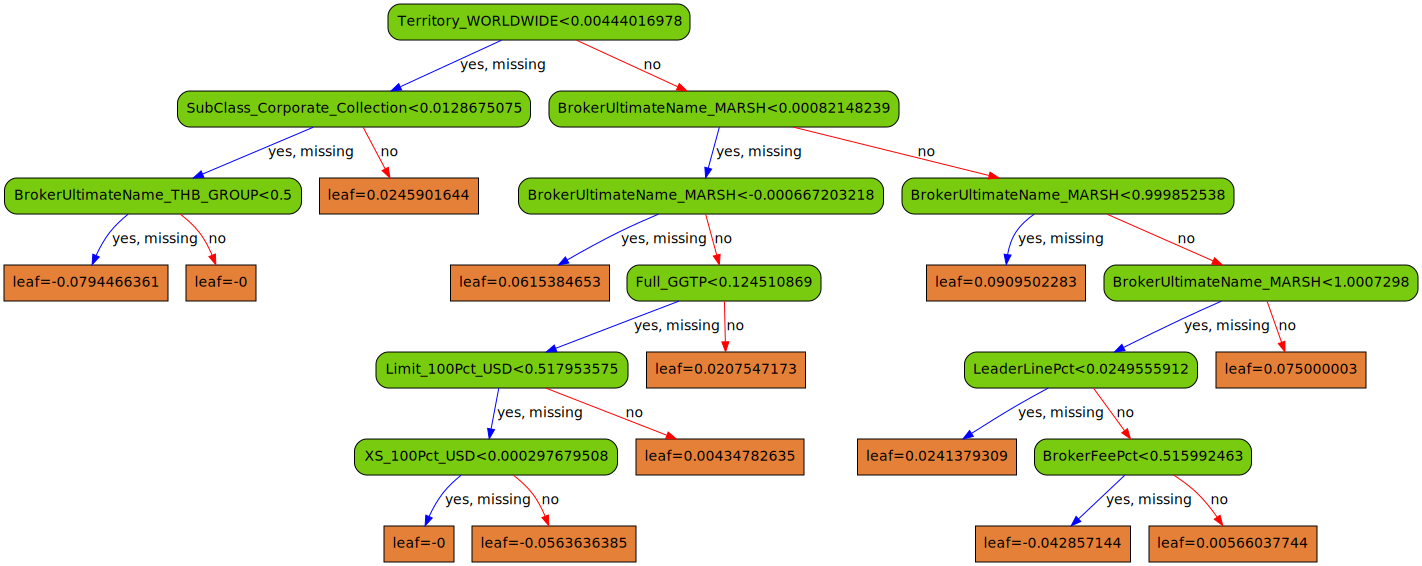

In [253]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.05,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_e, y_wgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


# WCGAN

#### Primary Business

In [254]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS,Class
46,0.003643,0.316038,0.334282,0.000000,0.153605,0.00,0.000000,0.530972,0.424690,1,...,0,0,0,0,0,0,0,0,0,0.0
59,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,1,1.0
828,0.010285,0.358672,0.299057,0.635174,0.216301,0.00,0.000000,0.445331,0.396154,0,...,0,0,0,0,0,0,0,0,0,0.0
100,0.025733,0.543195,0.237586,0.675864,0.122257,-0.05,0.000000,0.618436,0.885705,1,...,0,0,0,0,0,0,0,0,0,0.0
760,0.007505,0.519434,0.286257,0.506829,0.156677,0.10,0.749134,0.524216,0.627966,1,...,0,0,0,0,0,1,0,0,0,0.0


In [255]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,0.375925,0.596980,0.190146,0.000000,0.222571,0.00,0.000000,0.436234,0.463044,1,...,0,0,0,0,0,0,0,0,0,1
1,0.020109,0.436800,0.255968,0.000000,0.184953,0.00,0.000000,0.494795,0.363324,0,...,0,0,0,0,0,0,0,0,0,1
2,0.025733,0.452556,0.334282,0.000000,0.166082,0.00,0.704578,0.506837,0.081038,1,...,0,0,1,0,0,0,0,0,0,0
3,0.010285,0.577677,0.334245,0.564498,0.278997,0.00,0.000000,0.347922,0.463044,1,...,0,0,0,0,0,0,1,0,0,0
4,0.031799,0.794542,0.299057,0.512429,0.291536,0.75,0.000000,0.349847,0.186895,1,...,0,0,0,0,0,0,0,0,0,0


In [256]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [257]:
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [258]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [259]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [260]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [261]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [262]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [263]:
# wcgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_p.to_csv('specie_wcgan_primary.csv',index=False)

In [264]:
# Loading the dataset
wcgan_samples_p = pd.read_csv('../input/project/specie_wcgan_primary.csv')
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS,Class
0,-0.027870,0.608004,0.244256,0.475385,0.209541,-0.040727,-0.132244,0.490276,0.189523,0.370820,...,0.051203,-0.106845,-0.082367,-0.038358,-0.002062,0.738725,0.019677,-0.011431,0.073711,1.0
1,0.106710,0.632745,0.214253,0.602469,0.117664,-0.045154,0.692369,0.668426,0.701382,0.938625,...,-0.013034,-0.047630,0.727655,-0.012039,-0.019927,-0.032533,0.025604,0.126166,0.020615,1.0
2,0.037977,0.510632,0.423006,0.324392,0.141633,0.040771,0.008115,0.471395,0.609319,1.024281,...,-0.039370,0.407509,-0.003010,0.019996,-0.054993,-0.075982,-0.061316,-0.016904,0.351847,1.0
3,-0.017020,0.543230,0.317492,0.639554,0.204713,0.080376,0.939804,0.522669,0.072393,0.923558,...,-0.053632,0.952203,-0.008685,-0.051272,-0.017096,0.043521,0.007108,-0.011506,-0.003722,1.0
4,0.081652,0.673592,0.401378,0.393294,0.711293,-0.052839,0.018037,0.023624,0.180847,0.879959,...,0.001877,-0.006978,0.043550,0.005436,-0.007709,0.011362,-0.043581,-0.001032,1.005211,1.0


In [265]:
wcgan_samples_p.drop('Class', axis=1, inplace=True)
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
0,-0.027870,0.608004,0.244256,0.475385,0.209541,-0.040727,-0.132244,0.490276,0.189523,0.370820,...,0.795498,0.051203,-0.106845,-0.082367,-0.038358,-0.002062,0.738725,0.019677,-0.011431,0.073711
1,0.106710,0.632745,0.214253,0.602469,0.117664,-0.045154,0.692369,0.668426,0.701382,0.938625,...,0.062141,-0.013034,-0.047630,0.727655,-0.012039,-0.019927,-0.032533,0.025604,0.126166,0.020615
2,0.037977,0.510632,0.423006,0.324392,0.141633,0.040771,0.008115,0.471395,0.609319,1.024281,...,0.947802,-0.039370,0.407509,-0.003010,0.019996,-0.054993,-0.075982,-0.061316,-0.016904,0.351847
3,-0.017020,0.543230,0.317492,0.639554,0.204713,0.080376,0.939804,0.522669,0.072393,0.923558,...,0.016429,-0.053632,0.952203,-0.008685,-0.051272,-0.017096,0.043521,0.007108,-0.011506,-0.003722
4,0.081652,0.673592,0.401378,0.393294,0.711293,-0.052839,0.018037,0.023624,0.180847,0.879959,...,-0.019797,0.001877,-0.006978,0.043550,0.005436,-0.007709,0.011362,-0.043581,-0.001032,1.005211


In [266]:
X_wcgan_p = X_train_p.append(wcgan_samples_p, ignore_index = True)
X_wcgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,0.053867,0.494215,0.298451,0.385361,0.226795,-0.000881,0.103788,0.449336,0.453485,0.782014,...,0.191185,0.044062,0.196791,0.020755,0.011090,0.028338,0.178983,0.007200,0.036209,0.238911
std,0.103262,0.119398,0.079910,0.240923,0.108197,0.061805,0.261643,0.114740,0.180664,0.394754,...,0.384335,0.214966,0.378895,0.145369,0.101881,0.159644,0.372620,0.102197,0.191727,0.419228
min,-0.126575,0.000000,-0.031269,-0.402280,-0.035245,-0.250000,-0.401313,-0.142847,-0.173717,-0.589289,...,-0.179625,-0.215043,-0.147853,-0.215723,-0.106590,-0.162675,-0.202918,-0.122065,-0.160636,-0.259404
25%,0.002878,0.425321,0.261897,0.220766,0.155855,-0.012281,0.000000,0.397528,0.370026,0.853947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.017651,0.502983,0.299057,0.459332,0.216301,0.000000,0.000000,0.428606,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.058433,0.566138,0.334282,0.552448,0.259877,0.000000,0.033182,0.515303,0.570694,1.000000,...,0.039088,0.000000,0.084907,0.000000,0.000000,0.000000,0.055605,0.000000,0.000000,0.235479
max,1.000000,0.940223,1.000000,1.000000,1.175341,0.850000,1.885466,1.000000,1.000000,1.182236,...,1.225166,1.831921,1.192846,1.086515,1.000000,1.221879,1.327966,1.000000,1.376696,1.153623


In [267]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,PlacingBasis_OM,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_HOWDEN,BrokerUltimateName_INTERNATIONAL_RISK_SOLUTIONS,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_WILLIS
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,...,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.054874,0.469149,0.293514,0.357168,0.209510,-0.003977,0.094861,0.463288,0.460382,0.781215,...,0.212155,0.058564,0.162431,0.025414,0.015470,0.033149,0.191160,0.015470,0.041989,0.217680
std,0.111966,0.120602,0.087138,0.269372,0.095258,0.063262,0.243563,0.116280,0.186778,0.413651,...,0.409060,0.234936,0.369050,0.157467,0.123479,0.179125,0.393432,0.123479,0.200675,0.412897
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002878,0.398031,0.255968,0.000000,0.153605,0.000000,0.000000,0.410269,0.386336,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011553,0.472519,0.299057,0.459332,0.216301,0.000000,0.000000,0.427261,0.463044,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.042934,0.549160,0.334245,0.549755,0.228840,0.000000,0.000000,0.529260,0.578106,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.832089,1.000000,1.000000,1.000000,0.850000,0.934316,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [268]:
ones = np.ones((len(wcgan_samples_p),))
one = pd.Series(ones)
y_wcgan_p = y_train_p.append(one, ignore_index=True)
# y_wcgan_p

#### Excess Business

In [269]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,Class
135,0.444353,0.022647,0.020748,0.044516,0.65,0.0,0.0,0.117284,0.511007,0.0,...,0,0,0,0,0,0,1,0,0,0.0
292,0.019282,0.000692,0.218997,0.244842,0.84,0.0,0.0,0.025610,0.517404,0.0,...,1,0,0,0,0,0,0,0,1,0.0
418,0.006780,0.001924,0.100850,0.002225,0.75,0.0,0.0,0.042955,0.564440,0.0,...,0,0,0,0,0,1,0,0,0,0.0
127,0.222094,0.052329,0.036254,0.267100,0.85,0.0,0.0,0.029610,0.531515,0.0,...,0,0,0,0,0,0,1,0,0,1.0
226,0.138746,0.019172,0.031602,0.055645,0.75,0.0,0.0,0.065443,0.103481,0.0,...,0,0,0,0,1,0,0,0,0,0.0


In [270]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_p.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.222094,0.052329,0.036254,0.267100,0.850000,0.000,0.0,0.029610,0.531515,0.0,...,1,0,0,0,0,0,0,1,0,0
1,0.139024,0.014540,0.009870,0.380785,0.760449,0.084,0.0,0.029609,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0
2,0.027617,0.712532,0.091453,0.003894,0.750000,0.000,0.0,0.064238,0.113082,0.0,...,1,0,0,0,0,0,0,0,0,0
3,0.000195,0.008375,0.100850,0.000002,0.750000,0.000,0.0,0.065443,0.517403,0.0,...,1,0,0,0,1,0,0,0,0,0
4,0.102818,0.017770,0.019198,0.013750,0.750000,0.000,0.0,0.050415,0.282220,0.0,...,1,0,0,0,0,0,0,1,0,0


In [271]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 64 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [272]:
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [273]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [274]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [275]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [276]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [277]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [278]:
# wcgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_e.to_csv('specie_wcgan_excess.csv',index=False)

In [279]:
# Loading the dataset
wcgan_samples_e = pd.read_csv('../input/project/specie_wcgan_excess.csv')
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,Class
0,0.082197,0.619599,0.072427,0.026763,0.704712,-0.000954,-0.041939,0.064542,0.003479,0.002121,...,-0.007187,-0.069106,-0.009014,0.007355,0.024747,-0.026802,0.005149,0.003310,-0.030533,1.0
1,0.079330,0.008321,0.012109,-0.005584,0.761987,-0.007951,-0.011543,0.032992,0.314263,-0.034547,...,-0.009972,-0.010010,0.006260,-0.004766,-0.002816,-0.020674,1.025907,0.005024,0.006472,1.0
2,0.031594,0.004988,0.084151,0.037514,0.755312,0.039166,-0.000122,0.050177,0.455572,0.020280,...,-0.048220,-0.014495,0.008202,0.715561,-0.025916,-0.023251,0.026762,0.041103,0.018550,1.0
3,0.121490,-0.013847,0.015374,0.013148,0.750108,0.014490,-0.006270,0.044697,0.231602,-0.018329,...,0.001264,-0.005187,0.009479,-0.008051,0.021776,-0.000343,1.024188,0.006133,-0.013368,1.0
4,0.138512,0.025523,0.043403,0.042127,0.792833,0.018619,0.074709,0.040699,0.303510,0.001576,...,0.018812,-0.040512,0.022134,-0.002979,-0.043290,0.594599,0.060937,-0.025293,0.043368,1.0


In [280]:
wcgan_samples_e.drop('Class', axis=1, inplace=True)
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
0,0.082197,0.619599,0.072427,0.026763,0.704712,-0.000954,-0.041939,0.064542,0.003479,0.002121,...,1.005334,-0.007187,-0.069106,-0.009014,0.007355,0.024747,-0.026802,0.005149,0.003310,-0.030533
1,0.079330,0.008321,0.012109,-0.005584,0.761987,-0.007951,-0.011543,0.032992,0.314263,-0.034547,...,1.016895,-0.009972,-0.010010,0.006260,-0.004766,-0.002816,-0.020674,1.025907,0.005024,0.006472
2,0.031594,0.004988,0.084151,0.037514,0.755312,0.039166,-0.000122,0.050177,0.455572,0.020280,...,1.008738,-0.048220,-0.014495,0.008202,0.715561,-0.025916,-0.023251,0.026762,0.041103,0.018550
3,0.121490,-0.013847,0.015374,0.013148,0.750108,0.014490,-0.006270,0.044697,0.231602,-0.018329,...,1.026446,0.001264,-0.005187,0.009479,-0.008051,0.021776,-0.000343,1.024188,0.006133,-0.013368
4,0.138512,0.025523,0.043403,0.042127,0.792833,0.018619,0.074709,0.040699,0.303510,0.001576,...,0.984912,0.018812,-0.040512,0.022134,-0.002979,-0.043290,0.594599,0.060937,-0.025293,0.043368


In [281]:
X_wcgan_e = X_train_e.append(wcgan_samples_e, ignore_index = True)
X_wcgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,...,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.215349,0.060747,0.059031,0.095446,0.716726,-0.001252,0.164623,0.085712,0.328161,0.036689,...,0.947664,0.055355,0.045647,0.047587,0.015242,0.019970,0.039916,0.384243,0.018470,0.154787
std,0.233519,0.115745,0.064049,0.122214,0.086054,0.035522,0.307565,0.075388,0.228368,0.085438,...,0.217864,0.218476,0.214655,0.200601,0.116675,0.149796,0.185255,0.471979,0.128021,0.353360
min,-0.090927,-0.070988,-0.078437,-0.302718,0.205000,-0.200000,-0.135760,-0.040865,-0.246062,-0.082097,...,-0.090320,-0.078625,-0.122090,-0.059967,-0.086093,-0.093232,-0.120498,-0.399053,-0.090326,-0.113167
25%,0.053945,0.005586,0.025400,0.013859,0.650000,-0.007059,0.000000,0.047395,0.125014,0.000000,...,0.999307,0.000000,-0.011934,0.000000,-0.000006,-0.003157,0.000000,0.000000,-0.000159,0.000000
50%,0.137724,0.018196,0.044128,0.058990,0.743432,0.000000,0.000000,0.070886,0.320317,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005115,0.000000,0.000000
75%,0.310487,0.060246,0.080617,0.122814,0.752791,0.003127,0.155064,0.106214,0.545087,0.035174,...,1.000000,0.003930,0.000000,0.014163,0.000000,0.000000,0.000008,0.989621,0.000000,0.022622
max,1.267386,0.803817,1.000000,1.000000,0.956652,0.200000,1.280379,1.000000,1.000000,0.932198,...,1.380551,1.236507,1.000000,1.000000,1.000000,1.000000,1.000000,1.297904,1.384228,1.145465


In [282]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,LeaderStatus_FOLLOW,LeaderStatus_LEAD,BrokerUltimateName_AON,BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.,BrokerUltimateName_BUTCHER_ROBINSON_&_STAPLES,BrokerUltimateName_LLOYD_&_PARTNERS_LIMITED,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.181911,0.026712,0.061285,0.108199,0.700350,-0.004566,0.136421,0.091782,0.353522,0.032548,...,0.934066,0.065934,0.074176,0.076923,0.016484,0.041209,0.054945,0.236264,0.008242,0.236264
std,0.184121,0.055609,0.067703,0.142676,0.097118,0.034634,0.289307,0.090924,0.241497,0.084037,...,0.248508,0.248508,0.262418,0.266836,0.127501,0.199046,0.228187,0.425371,0.090534,0.425371
min,0.000000,0.000000,0.000000,0.000001,0.205000,-0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044925,0.005374,0.028501,0.006249,0.650000,0.000000,0.000000,0.050415,0.103481,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.110964,0.012898,0.044007,0.044521,0.750000,0.000000,0.000000,0.065443,0.376294,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277658,0.026079,0.075018,0.162982,0.750000,0.000000,0.000000,0.107250,0.564440,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.712532,1.000000,1.000000,0.900000,0.200000,0.937087,1.000000,1.000000,0.932198,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [283]:
ones = np.ones((len(wcgan_samples_e),))
one = pd.Series(ones)
y_wcgan_e = y_train_e.append(one, ignore_index=True)
# y_wcgan_e

### XGBoost (WCGAN)

#### Primary Business

In [284]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_p, y_wcgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [285]:
# print(optimal_params.best_params_)

In [286]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_p, y_wcgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.39034
[1]	validation_0-aucpr:0.41124
[2]	validation_0-aucpr:0.44621
[3]	validation_0-aucpr:0.44572
[4]	validation_0-aucpr:0.45430
[5]	validation_0-aucpr:0.47289
[6]	validation_0-aucpr:0.46669
[7]	validation_0-aucpr:0.48059


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.47372
[9]	validation_0-aucpr:0.50221
[10]	validation_0-aucpr:0.49523
[11]	validation_0-aucpr:0.49907
[12]	validation_0-aucpr:0.49516
[13]	validation_0-aucpr:0.50375
[14]	validation_0-aucpr:0.51488
[15]	validation_0-aucpr:0.51279
[16]	validation_0-aucpr:0.49522
[17]	validation_0-aucpr:0.48567
[18]	validation_0-aucpr:0.47968
[19]	validation_0-aucpr:0.48669
[20]	validation_0-aucpr:0.48354
[21]	validation_0-aucpr:0.49262
[22]	validation_0-aucpr:0.49892
[23]	validation_0-aucpr:0.49607
[24]	validation_0-aucpr:0.49475


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [287]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.514876
Best iteration: 14


In [288]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 78.85%
ROC AUC: 0.551978021978022
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       175
         1.0       0.75      0.12      0.20        52

    accuracy                           0.79       227
   macro avg       0.77      0.55      0.54       227
weighted avg       0.78      0.79      0.72       227



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7843406593406593
Precision-Recall AUC: 0.5144904492070173


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


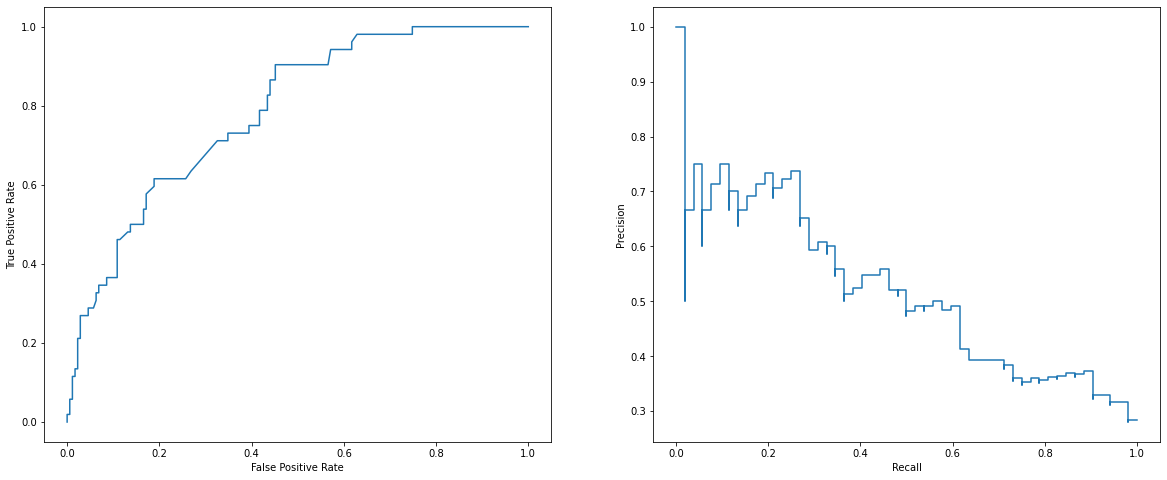

In [289]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wcgan_p, tpr_wcgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wcgan_p = RocCurveDisplay(fpr=fpr_wcgan_p, tpr=tpr_wcgan_p)
roc_auc_wcgan_p = auc(fpr_wcgan_p, tpr_wcgan_p)

prec_wcgan_p, recall_wcgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wcgan_p = PrecisionRecallDisplay(precision=prec_wcgan_p, recall=recall_wcgan_p)
pr_auc_wcgan_p = auc(recall_wcgan_p, prec_wcgan_p)

print('ROC AUC:', roc_auc_wcgan_p)
print('Precision-Recall AUC:', pr_auc_wcgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_p.plot(ax=ax1)
pr_display_wcgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


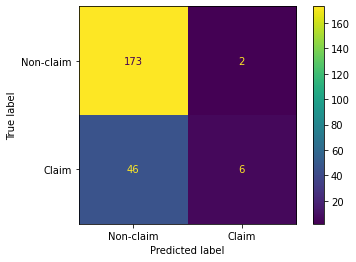

In [290]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_MALAYSIA': 3, 'Full_GGTP': 2, 'SubClass_Shippers_&_Packers': 1, 'Ded_100Pct_USD': 2, 'Limit_100Pct_USD': 1, 'BrokerFeePct': 2}
gain:  {'Territory_MALAYSIA': 249.6252138666667, 'Full_GGTP': 32.84680175, 'SubClass_Shippers_&_Packers': 8.48745728, 'Ded_100Pct_USD': 14.11999845, 'Limit_100Pct_USD': 18.422966, 'BrokerFeePct': 4.36070383}
cover:  {'Territory_MALAYSIA': 218.41666666666666, 'Full_GGTP': 206.5, 'SubClass_Shippers_&_Packers': 112.5, 'Ded_100Pct_USD': 48.375, 'Limit_100Pct_USD': 35.5, 'BrokerFeePct': 8.5}
total_gain:  {'Territory_MALAYSIA': 748.8756416000001, 'Full_GGTP': 65.6936035, 'SubClass_Shippers_&_Packers': 8.48745728, 'Ded_100Pct_USD': 28.2399969, 'Limit_100Pct_USD': 18.422966, 'BrokerFeePct': 8.72140766

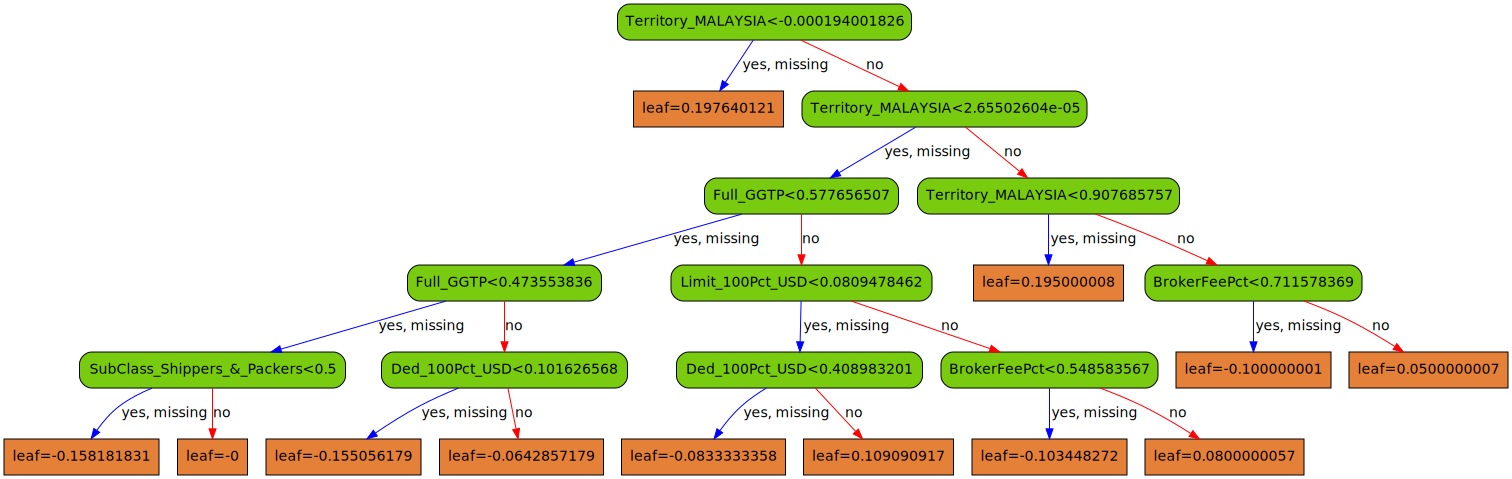

In [291]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_p, y_wcgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [292]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_e, y_wcgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [293]:
# print(optimal_params.best_params_)

In [294]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_e, y_wcgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.44683
[1]	validation_0-aucpr:0.49395


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.50200
[3]	validation_0-aucpr:0.63424
[4]	validation_0-aucpr:0.62737
[5]	validation_0-aucpr:0.63460
[6]	validation_0-aucpr:0.70294
[7]	validation_0-aucpr:0.70309
[8]	validation_0-aucpr:0.67737
[9]	validation_0-aucpr:0.64339
[10]	validation_0-aucpr:0.64950
[11]	validation_0-aucpr:0.63656
[12]	validation_0-aucpr:0.62572
[13]	validation_0-aucpr:0.62402
[14]	validation_0-aucpr:0.67867
[15]	validation_0-aucpr:0.68893
[16]	validation_0-aucpr:0.68197


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [295]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.703088
Best iteration: 7


In [296]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 94.51%
ROC AUC: 0.6875
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        83
         1.0       1.00      0.38      0.55         8

    accuracy                           0.95        91
   macro avg       0.97      0.69      0.76        91
weighted avg       0.95      0.95      0.93        91



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9420180722891567
Precision-Recall AUC: 0.7028176501860712


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


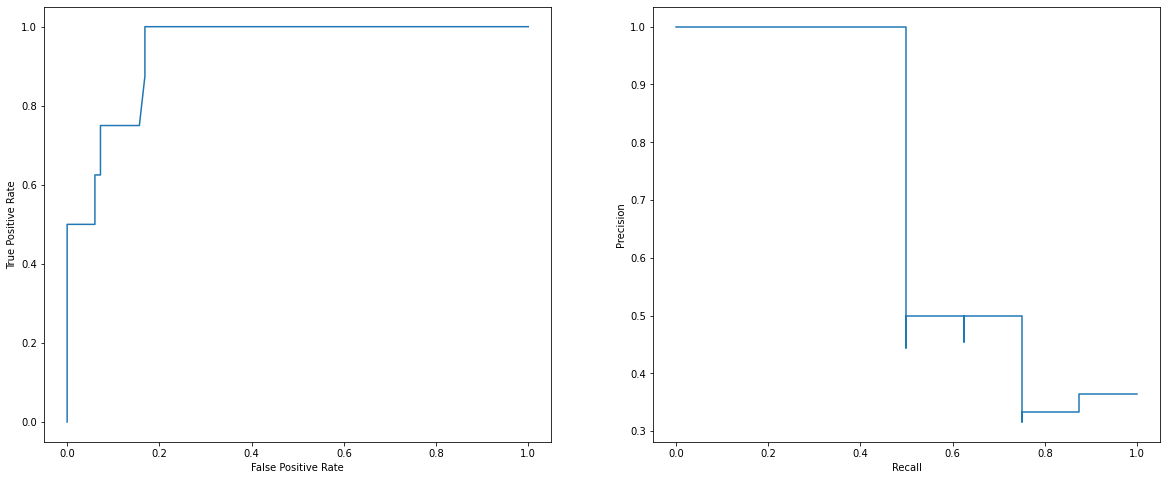

In [297]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wcgan_e, tpr_wcgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wcgan_e = RocCurveDisplay(fpr=fpr_wcgan_e, tpr=tpr_wcgan_e)
roc_auc_wcgan_e = auc(fpr_wcgan_e, tpr_wcgan_e)

prec_wcgan_e, recall_wcgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wcgan_e = PrecisionRecallDisplay(precision=prec_wcgan_e, recall=recall_wcgan_e)
pr_auc_wcgan_e = auc(recall_wcgan_e, prec_wcgan_e)

print('ROC AUC:', roc_auc_wcgan_e)
print('Precision-Recall AUC:', pr_auc_wcgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_e.plot(ax=ax1)
pr_display_wcgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


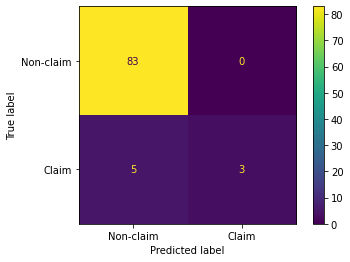

In [298]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:16:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_WORLDWIDE': 1, 'Territory_QATAR': 1, 'SubClass_Corporate_Collection': 1, 'Territory_ARGENTINA': 1, 'BrokerUltimateName_AON': 2, 'Full_GGTP': 1, 'LeaderLinePct': 1, 'StatsMinorClassCode_WA': 1, 'BrokerFeePct': 1, 'BrokerUltimateName_MARSH': 1, 'SubClass_J_Form': 1}
gain:  {'Territory_WORLDWIDE': 399.115265, 'Territory_QATAR': 79.0684204, 'SubClass_Corporate_Collection': 11.2405853, 'Territory_ARGENTINA': 3.39637756, 'BrokerUltimateName_AON': 104.13731369999999, 'Full_GGTP': 18.3707161, 'LeaderLinePct': 15.9528828, 'StatsMinorClassCode_WA': 10.7171707, 'BrokerFeePct': 11.505722, 'BrokerUltimateName_MARSH': 0.086619854, 'SubClass_J_Form': 2.42478943}
cover:  {'Territory_WORLDWIDE': 332.0, 'Territory_QATAR': 65.0, 'SubCla

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


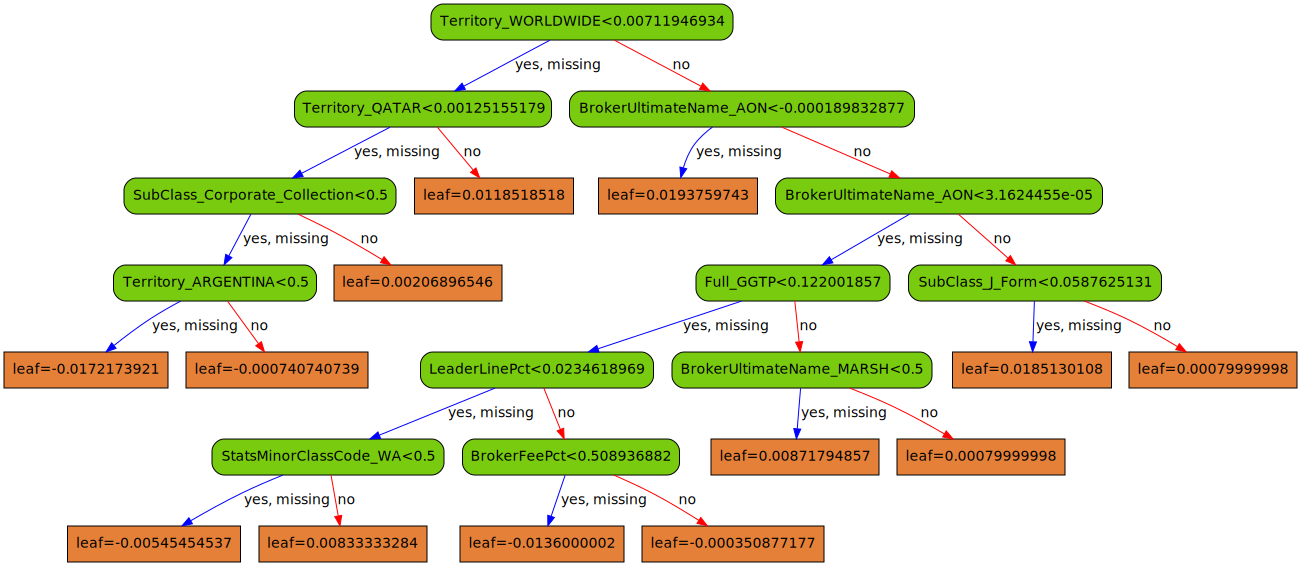

In [299]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.01,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_e, y_wcgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Comparison Plots

In [300]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_e))]
fpr, tpr, _ = roc_curve(y_test_e, random_probs, pos_label=1)

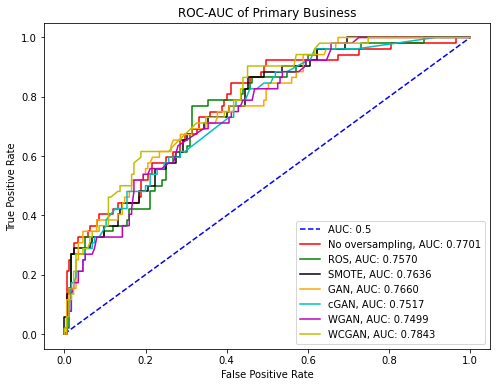

In [301]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_p, tpr_p, color='r', label='No oversampling, AUC: %.4f' % roc_auc_p)
plt.plot(fpr_ros_p, tpr_ros_p, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_p)
plt.plot(fpr_sm_p, tpr_sm_p, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_p)
plt.plot(fpr_gan_p, tpr_gan_p, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_p)
plt.plot(fpr_cgan_p, tpr_cgan_p, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_p)
plt.plot(fpr_wgan_p, tpr_wgan_p, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_p)
plt.plot(fpr_wcgan_p, tpr_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_p)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Primary Business')
plt.legend(loc='lower right')

plt.show()

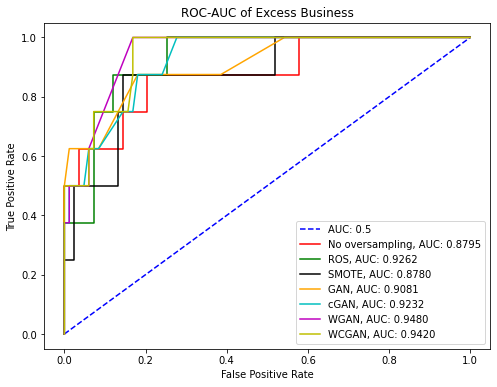

In [302]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_e, tpr_e, color='r', label='No oversampling, AUC: %.4f' % roc_auc_e)
plt.plot(fpr_ros_e, tpr_ros_e, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_e)
plt.plot(fpr_sm_e, tpr_sm_e, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_e)
plt.plot(fpr_gan_e, tpr_gan_e, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_e)
plt.plot(fpr_cgan_e, tpr_cgan_e, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_e)
plt.plot(fpr_wgan_e, tpr_wgan_e, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_e)
plt.plot(fpr_wcgan_e, tpr_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_e)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Excess Business')
plt.legend(loc='lower right')

plt.show()

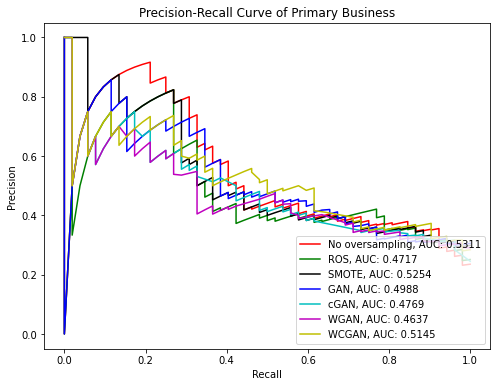

In [303]:
plt.figure(figsize=(8,6))

plt.plot(recall_p, prec_p, color='r', label='No oversampling, AUC: %.4f' % pr_auc_p)
plt.plot(recall_ros_p, prec_ros_p, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_p)
plt.plot(recall_sm_p, prec_sm_p, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_p)
plt.plot(recall_gan_p, prec_gan_p, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_p)
plt.plot(recall_cgan_p, prec_cgan_p, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_p)
plt.plot(recall_wgan_p, prec_wgan_p, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_p)
plt.plot(recall_wcgan_p, prec_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_p)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Primary Business')
plt.legend(loc='lower right')

plt.show()

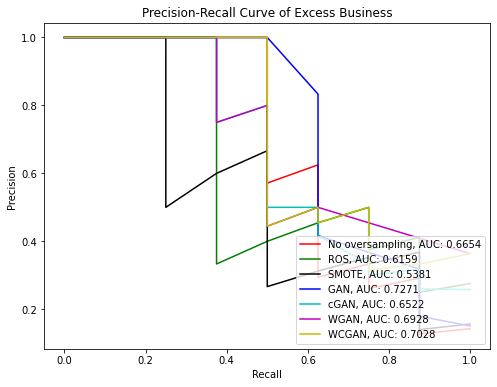

In [304]:
plt.figure(figsize=(8,6))

plt.plot(recall_e, prec_e, color='r', label='No oversampling, AUC: %.4f' % pr_auc_e)
plt.plot(recall_ros_e, prec_ros_e, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_e)
plt.plot(recall_sm_e, prec_sm_e, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_e)
plt.plot(recall_gan_e, prec_gan_e, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_e)
plt.plot(recall_cgan_e, prec_cgan_e, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_e)
plt.plot(recall_wgan_e, prec_wgan_e, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_e)
plt.plot(recall_wcgan_e, prec_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_e)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Excess Business')
plt.legend(loc='lower right')

plt.show()

## PCA

In [305]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

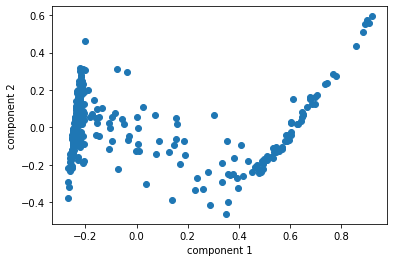

In [306]:
projected = pca.fit_transform(gan_samples_e)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

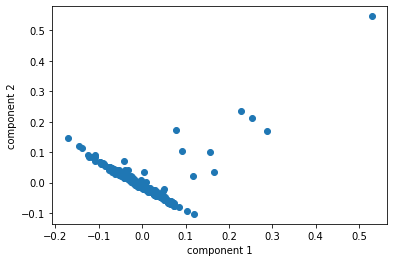

In [307]:
projected = pca.fit_transform(cgan_samples_e)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

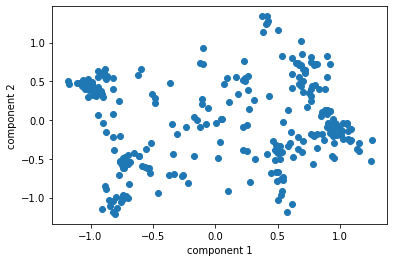

In [308]:
projected = pca.fit_transform(wgan_samples_e)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

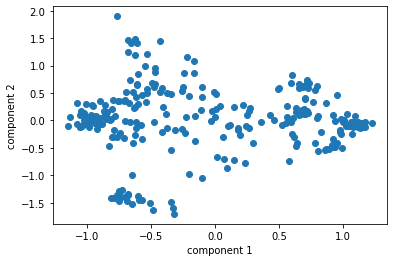

In [309]:
projected = pca.fit_transform(wcgan_samples_e)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot